 # Import Necessary Packages and Define Helper Functions

In [1]:

#import the python scientific suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab
import statsmodels

from sklearn.cross_validation import *
from sklearn import svm, linear_model
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree

from textblob import TextBlob

import statsmodels.api as sm

In [2]:
from collections import defaultdict

In [3]:
# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
#plot figures inline in Jupyter notebooks
%matplotlib inline 

#use seaborn for plotting
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')
pylab.rcParams.update({'figure.autolayout': True})

In [4]:
def WordCount(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count

def WordFreq(corpus, keywords):
    count = 0 #start the counter at 0
    upper_words = [w.upper() for w in keywords]
    
    for word in corpus.split(): #for each word in the corpus
        if word.upper() in upper_words: #if the word is the keyword
            count = count + 1 #add one to the counter
    return count/len(corpus.split())

def Polarity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.polarity

def Subjectivity(corpus):
    blob = TextBlob(unicode(corpus, 'utf-8'))
    return blob.sentiment.subjectivity

#define some helper functions 
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

def RollingGaussianMean(df, x, y, centers, eps):
    df = df.dropna()
    rolling = [] #start a list to hold the rolling mean
    for bc in centers: #for each bin center in the list of bin centers
            w = scipy.stats.norm.pdf((df[x] - bc)/(eps))
            if sum(w) != 0.0:
                rolling.append((bc, np.average(df[y], weights = w))) #take the mean and add it to the stack
            else:
                rolling.append((bc, np.average(df[y])))
    return(pd.DataFrame(rolling).rename(columns = {0: 'x', 1: 'y'}))

 # Reading in Data Files

In [5]:
#read in the data from the files
file_dir = '/Users/zihaoxu/Desktop/Pomona/2017_Spring/Data Science Research/yz_data/' #replace this with the path to your data files

f = {'R': 'R_review_stat.csv', 'T': 'T_review_text.csv', 'N': 'N_neighborhood.csv',\
    'B': 'B_business_2.csv', 'U': 'U_user.csv'}

d = defaultdict() #initialize an empty dictionary to hold the dataframes

for fi in f: #for each file in the dictinary of files
    d[fi] = pd.read_csv(file_dir + f[fi]) #read in the files and hold them in the dataframe dictionary

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
print(d.keys()) #the list of files in the data dictionary

dict_keys(['U', 'T', 'R', 'B', 'N'])


The object 'd' is our data dictionary. It contains five dataframes that are the entirety of the combined yelp and zillow datasets. For example, let's access the review statistics:

In [7]:
d['R'].head()

Unnamed: 0               review_id  words  sentences   ease  grade  \
0           0  6ZWmWypGMdnwwavY8ykXlg    197         13  73.17    6.8   
1           1  3m6vLe955opYMSrTrlLIKw    385         25  90.09    4.4   
2           2  MkHaKWwZ_OngdUsMt_xAqg     55          4  92.12    3.6   
3           3  gB-kzO-Jg_u2p7Cmf9xG_w    206         12  79.60    6.4   
4           4  cCh6xPIcV6P2ben4bCsq7Q    208          9  65.05    9.9   

   dale_chall  stars             business_id  z_hood  latest_zhvi  \
0        6.62      4  uI0LvTXFACid1308KFO5ew  343635          NaN   
1        6.10      2  uI0LvTXFACid1308KFO5ew  343635          NaN   
2        7.15      2  uI0LvTXFACid1308KFO5ew  343635          NaN   
3        6.70      4  uI0LvTXFACid1308KFO5ew  343635          NaN   
4        8.19      3  uI0LvTXFACid1308KFO5ew  343635          NaN   

   latest_sqft        lat        lon  bbox_area  polarity  subjectivity  \
0          NaN  40.392222 -79.947974   5.378061  0.260963      0.527941   
1          NaN  40.392222 -79.947974   5.378061  0.009410      0.485827   
2          NaN  40.392222 -79.947974   5.378061  0.190000      0.580000   
3          NaN  40.392222 -79.947974   5.378061  0.324351      0.606169   
4          NaN  40.392222 -79.947974   5.378061  0.209776      0.511859   

          year                 user_id  
0  2009.624658  iTmWHtltCtk0Gm55AOxrUA  
1  2011.197260  JEvkfVPf_DuhX-ntE5L6bQ  
2  2011.438356  QOdrDkYXhqA8jtPzfpugWQ  
3  2011.586301  qPGLUQUG43b3aBZKDUBlMw  
4  2011.679452  lJsCDFtnR2-AMhDdWtCRug

# Filtering Data

The first operation we will perform is the filtration of the data, to only include certain neighborhoods, businesses, and users. We usually want to apply filters to remove users and businesses with a small number of reviews. 

In [8]:
#begin filtration of data based on multiple criteria
min_reviews_per_business = 3
min_reviews_per_user = 5
min_business_per_neighborhood = 20

#perform the filtration by updating the dataframes
d['B'] = d['B'][(d['B']['review_count'] >= min_reviews_per_business)]
d['U'] = d['U'][(d['U']['n_reviews'] >= min_reviews_per_user)]
d['N'] = d['N'][(d['N']['n'] >= min_business_per_neighborhood)]

In the next cell, we will use the TopChains helper function that I have made to create a list of all businesses with more than 35 stores in the database.

In [9]:
min_stores_per_chain = 35
#list of all of the chains with over a certain number of reviews
top_chains = TopChains(d['B'], min_stores_per_chain) 
print(top_chains)

['Starbucks', 'Subway', "McDonald's", 'Walgreens', 'Taco Bell', 'Pizza Hut', 'The UPS Store', "Wendy's", 'Burger King', 'Bank of America', 'Wells Fargo Bank', 'Circle K', 'Great Clips', "Domino's Pizza", 'Panda Express', "Dunkin' Donuts", 'Chase Bank', 'Supercuts', 'Chipotle Mexican Grill', 'Jiffy Lube', 'US Post Office', 'QuikTrip', "Jimmy John's", "Papa John's Pizza", 'KFC', 'Enterprise Rent-A-Car', 'Dairy Queen', 'Cvs Pharmacy', 'Jack in the Box', 'FedEx Office Print & Ship Center', 'T-Mobile', "Denny's", "Arby's"]


 # Merging and Filtering Dataframes
 
 In order to create a dataset where all three filters are applied, we need to perform a series of merges on neighborhood and user identifiers. In the next cell, we will merge the N and B dataframes, so that only businesses in neighborhoods with greater than 20 business will be included in the B dataframe. We will call this dataframe FB for 'filtered businesses'. we compare the lengths of the two dataframes to see the effect of the filter.

In [10]:
d['FB'] = pd.merge(d['N'][['z_hood']], d['B'], on = 'z_hood') #create a new dataframe in the data dictionary
print('Before Neighborhood filter: ' + str(len(d['B'])))
print('After Neighborhood filter: ' + str(len(d['FB'])))

Before Neighborhood filter: 38599
After Neighborhood filter: 37074


We can apply multiple filters at once. In this next cell, we will create a dataframe of businesses in neighborhoods with over 20 businesses, that are also in our list of top chains. Because we are testing for list inclusion in a list we use the .isin() function, instead of performing a merge.

In [11]:
d['FFB'] = d['FB'][d['FB']['name'].isin(top_chains)] #filter to just the top chains
print('Before Chain filter: ' + str(len(d['FB'])))
print('After Chain filter: ' + str(len(d['FFB'])))

Before Chain filter: 37074
After Chain filter: 2242


We can always see a list of all of the dataframes in our data dictionary:

In [12]:
print(d.keys())

['B', 'N', 'FB', 'R', 'U', 'T', 'FFB']


 # Comparing Distributions
 
 In the next cell, we will take our dataframe of chains and compare the disribution of star ratings for each chain. We can create a visualization using seaborn's built in boxplot function. First, let's sort the chains according the mean yelp stars that their stores recieve. I have created a helper function called OrderName that will list our chains in order.

In [13]:
#sort by mean stars
print(OrderName(d['FFB'], 'name', 'mean_stars'))
print('\n')
#sort by number of reviews
print(OrderName(d['FFB'], 'name', 'review_count'))

['KFC', 'Pizza Hut', "McDonald's", 'Burger King', "Wendy's", 'Bank of America', 'US Post Office', "Papa John's Pizza", 'Jack in the Box', 'Cvs Pharmacy', 'Circle K', "Denny's", 'T-Mobile', 'Panda Express', 'Taco Bell', "Dunkin' Donuts", 'Dairy Queen', "Arby's", "Jimmy John's", 'Walgreens', 'Wells Fargo Bank', 'Subway', "Domino's Pizza", 'FedEx Office Print & Ship Center', 'The UPS Store', 'Chase Bank', 'Great Clips', 'Chipotle Mexican Grill', 'Starbucks', 'Supercuts', 'Jiffy Lube', 'Enterprise Rent-A-Car', 'QuikTrip']


['Chase Bank', 'Circle K', 'Wells Fargo Bank', 'T-Mobile', 'Subway', 'Bank of America', 'Supercuts', 'Jack in the Box', "Arby's", 'The UPS Store', 'Cvs Pharmacy', 'Burger King', 'Great Clips', 'QuikTrip', 'Taco Bell', 'Walgreens', "Papa John's Pizza", 'Pizza Hut', 'FedEx Office Print & Ship Center', 'KFC', "Wendy's", "McDonald's", "Domino's Pizza", 'Panda Express', 'Dairy Queen', 'Enterprise Rent-A-Car', 'US Post Office', 'Jiffy Lube', 'Starbucks', "Dunkin' Donuts", "De

Now, we can visualize the rating distribution of each chain using seaborn, plotting them in order from lowest mean stars to highest mean stars.

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


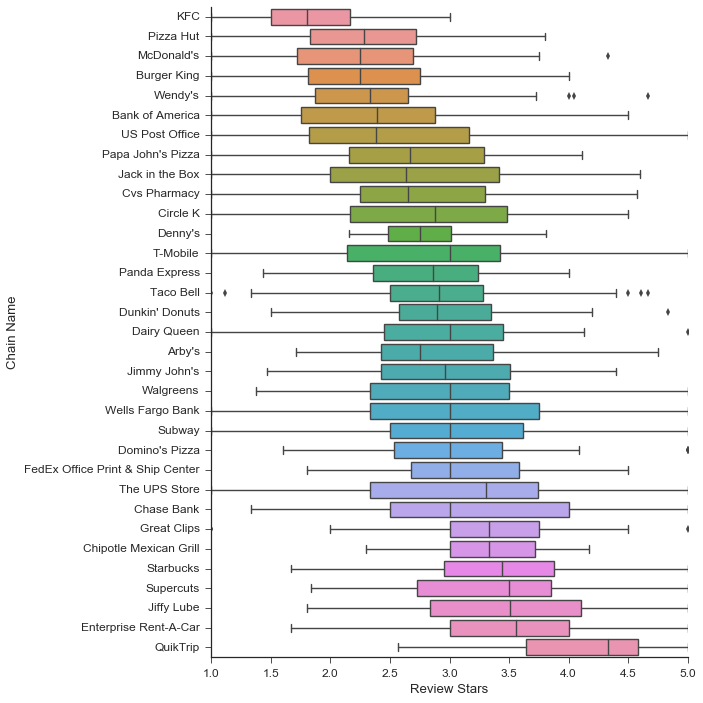

In [14]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0) #set figure parameters
sns.boxplot(data = d['FFB'], x = 'mean_stars', y = 'name', order = OrderName(d['FFB'], 'name', 'mean_stars'))
plt.xlabel('Review Stars')
plt.ylabel('Chain Name')
sns.despine()
plt.savefig('chain_stars.png', dpi = 300, fmt = 'png')
pylab.rcParams['figure.figsize'] = (6.0, 4.0) #reset figure parameters

In this next cell, we will learn how to loop through individual users, businesses, or neighborhoods. In this case we will loop through individual businesses. For each business, we will create a temporary dataframe in the loop, containing the review statistics for that business

 # Looping Through Businesses or Users
 
 Sometimes, we would like to perform a complex computation on all of the reviews pertaining to a certain neighborhood, business, or user. The next cell shows us how to select reviews corresponding to unique neighborhoods, businesses, or users.

In [15]:
for ids in np.unique(d['B']['business_id'])[0:10]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    
r.head() #let's see some of the review stats of this particular business: notice how all of the business_id are the same

Unnamed: 0               review_id  words  sentences   ease  grade  \
910023      910023  qoDP0T3iT3f98hdzOO5ARw     82          6  66.74    7.2   
910024      910024  K4ZZINk_QMXsQQOqge9Sgw    179         10  79.60    6.4   
910025      910025  o8nKXEuFxCKLN1o7dNjlTA     93          5  87.05    5.6   
910026      910026  CvM1tXAsVqnmQEYdXOSLag    423         21  76.56    7.6   
910027      910027  LxZMMG2kRXzyw2up0Seh-A    320         24  75.20    6.0   

        dale_chall  stars             business_id  z_hood  latest_zhvi  \
910023        7.55      5  --pOlFxITWnhzc7SHSIP0A  275101     471600.0   
910024        7.04      3  --pOlFxITWnhzc7SHSIP0A  275101     471600.0   
910025        6.74      4  --pOlFxITWnhzc7SHSIP0A  275101     471600.0   
910026        7.69      4  --pOlFxITWnhzc7SHSIP0A  275101     471600.0   
910027        7.88      5  --pOlFxITWnhzc7SHSIP0A  275101     471600.0   

        latest_sqft        lat        lon  bbox_area  polarity  subjectivity  \
910023        199.0  35.165215 -80.797661   1.385601  0.181593      0.542766   
910024        199.0  35.165215 -80.797661   1.385601  0.232818      0.470280   
910025        199.0  35.165215 -80.797661   1.385601  0.207744      0.569024   
910026        199.0  35.165215 -80.797661   1.385601  0.135623      0.458455   
910027        199.0  35.165215 -80.797661   1.385601  0.298242      0.605697   

               year                 user_id  
910023  2013.208219  JG4BZ6PWmhB3XHgpRKaicQ  
910024  2013.210959  ts7EG6Zv2zdMDg29nyqGfA  
910025  2013.213699  wyukT5LzQ5CQJ1KMVuojIQ  
910026  2013.213699  3Kn23qXbgPFmtV-CbHPJ2A  
910027  2013.219178  A6bPFcUjuuayRBoyybedDQ

 # Review Trend Computation

In the next cells, we will compute the trend of reviews over time in a random neighborhood. We will show a scatter plot of the review stars as a function of time.

Number of Reviews: 27338


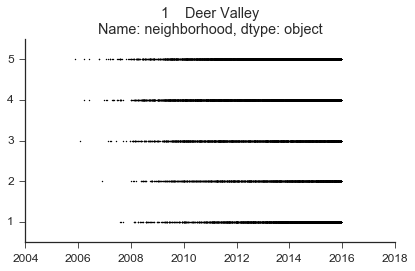

In [16]:
for ids in np.unique(d['N']['z_hood'])[0:1]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print('Number of Reviews: ' + str(len(r)))
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    sns.despine()

This shows that there were over 27,000 reviews in this neighborhood. This graph is a not easy to understand. It is hard to see how the distribution changes as a function of time. For this reason, I've created a helper function called RollingGaussianMean, which is a gaussian kernel smoother:

27338


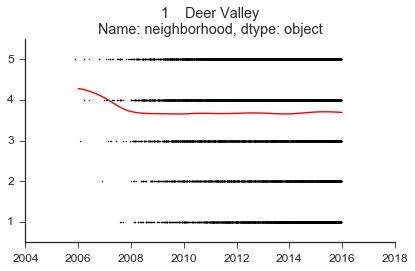

In [17]:
for ids in np.unique(d['N']['z_hood'])[0:1]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    plt.plot(gm['x'], gm['y'], c = 'red')
    sns.despine()

Looks like the mean is static as a function of time after the year 2008. Note that we can perform this analysis for all of the neighborhoods by looping through them.

1758
5516
38566
5563


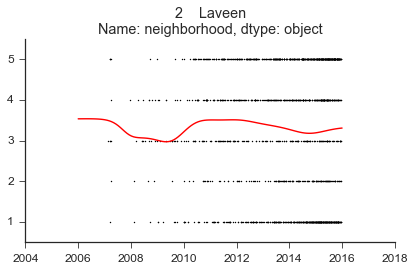

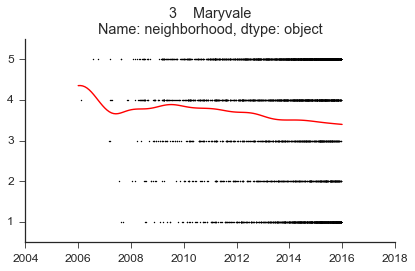

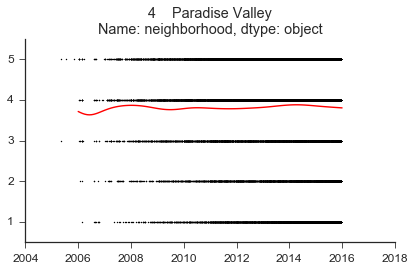

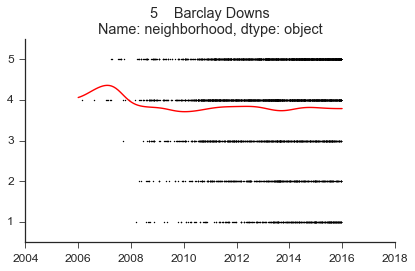

In [18]:
for ids in np.unique(d['N']['z_hood'])[1:5]: #for the unique business IDs 
    r = d['R'][d['R']['z_hood'] == ids]
    print(len(r))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(2006, 2016, 120), 0.5)
    plt.figure()
    plt.title(str(d['N']['neighborhood'][d['N']['z_hood'] == ids]))
    plt.scatter(r['year'], r['stars'], lw = 0, s = 2, c = 'black')
    plt.ylim(0.5,5.5)
    plt.plot(gm['x'], gm['y'], c = 'red')
    sns.despine()

Let's make a data map. In the next cell, we will learn how to plot all of the businesses in one neighborhood.

 # Map Creation

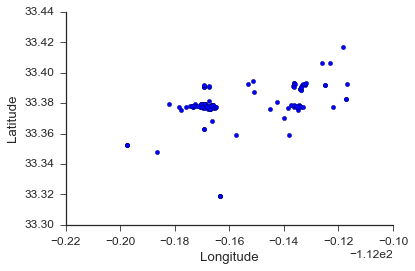

In [19]:
for ids in np.unique(d['N']['z_hood'])[1:2]: #for the unique business IDs 
    b = d['B'][d['B']['z_hood'] == ids]
    plt.scatter(b['longitude'], b['latitude'])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.despine()

When looking at data maps, it can be useful to encode a variable in the color axis of each point. In these next maps, the color of the point corresponds to the mean star rating of the business, while the size corresponds to the number of reviews that a business has.

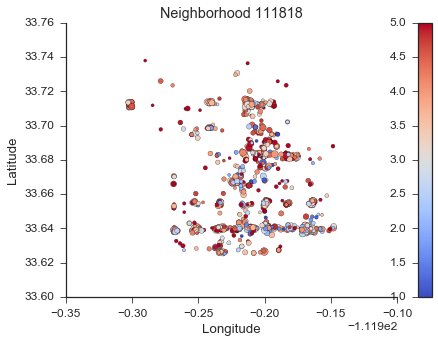

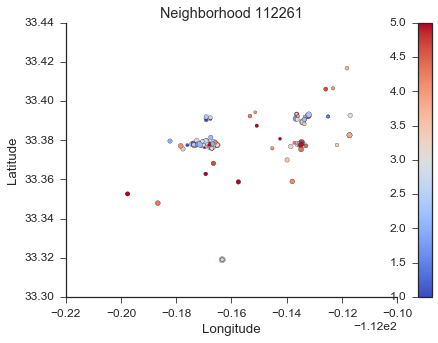

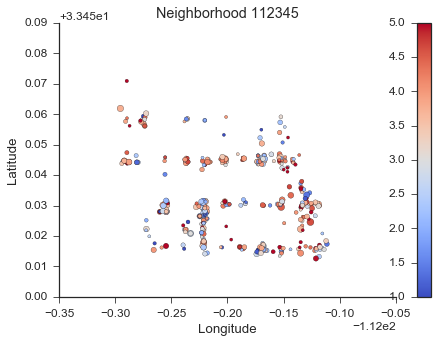

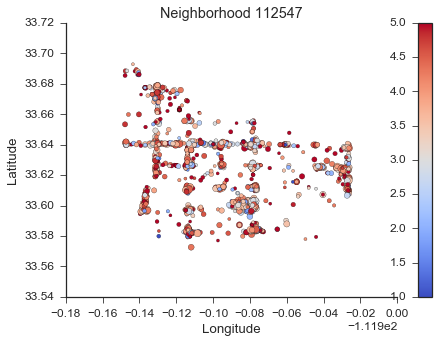

In [20]:
pylab.rcParams['figure.figsize'] = (7.0, 5.0) #use a bigger figure size for this data map
for ids in np.unique(d['N']['z_hood'])[0:4]: #for the unique business IDs 
    b = d['B'][d['B']['z_hood'] == ids]
    plt.figure()
    plt.title('Neighborhood ' + str(list(b['z_hood'])[0]))
    plt.scatter(b['longitude'], b['latitude'], c = b['mean_stars'], cmap = 'coolwarm', s = np.log10(b['review_count'])*20.0)
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    sns.despine()

 # Review Corpus Comparison
 
 We would like to compare the set of reviews with certain keywords to those which do not contain these certain keywords. To start we will combine the review text and the review stats data. 

In [21]:
d['RT'] = pd.merge(d['R'], d['T'], on = 'review_id') #merge the review text and stats

In [22]:
d['RT'].head()

Unnamed: 0_x               review_id  words  sentences   ease  grade  \
0             0  6ZWmWypGMdnwwavY8ykXlg    197         13  73.17    6.8   
1             1  3m6vLe955opYMSrTrlLIKw    385         25  90.09    4.4   
2             2  MkHaKWwZ_OngdUsMt_xAqg     55          4  92.12    3.6   
3             3  gB-kzO-Jg_u2p7Cmf9xG_w    206         12  79.60    6.4   
4             4  cCh6xPIcV6P2ben4bCsq7Q    208          9  65.05    9.9   

   dale_chall  stars             business_id  z_hood  \
0        6.62      4  uI0LvTXFACid1308KFO5ew  343635   
1        6.10      2  uI0LvTXFACid1308KFO5ew  343635   
2        7.15      2  uI0LvTXFACid1308KFO5ew  343635   
3        6.70      4  uI0LvTXFACid1308KFO5ew  343635   
4        8.19      3  uI0LvTXFACid1308KFO5ew  343635   

                         ...                          latest_sqft        lat  \
0                        ...                                  NaN  40.392222   
1                        ...                                  NaN  40.392222   
2                        ...                                  NaN  40.392222   
3                        ...                                  NaN  40.392222   
4                        ...                                  NaN  40.392222   

         lon  bbox_area  polarity  subjectivity         year  \
0 -79.947974   5.378061  0.260963      0.527941  2009.624658   
1 -79.947974   5.378061  0.009410      0.485827  2011.197260   
2 -79.947974   5.378061  0.190000      0.580000  2011.438356   
3 -79.947974   5.378061  0.324351      0.606169  2011.586301   
4 -79.947974   5.378061  0.209776      0.511859  2011.679452   

                  user_id Unnamed: 0_y  \
0  iTmWHtltCtk0Gm55AOxrUA          800   
1  JEvkfVPf_DuhX-ntE5L6bQ          801   
2  QOdrDkYXhqA8jtPzfpugWQ          802   
3  qPGLUQUG43b3aBZKDUBlMw          803   
4  lJsCDFtnR2-AMhDdWtCRug          804   

                                                text  
0  I'm not into waterparks as much as I am into a...  
1  The evites are in the mail for the 2 for $99 s...  
2  It's fun, but not as fun as Kennywood. The boa...  
3  How many times do you get to fall at 70mph, we...  
4  Sandcastle is a mixed bag for the kiddos.  On ...  

[5 rows x 21 columns]

We will then use the WordCount and WordFreq helper functions to append a column to the dataframe containing the frequency and count of the keyword. This operation can take up to a minute to perform for each set of keywords, because the program loops through over 1 million reviews.

In [23]:
keyword = ['great'] #input list of keywords

d['RT']['kw_count'] =  d['RT']['text'].apply(WordCount, args = (keyword,)) #add word count column
d['RT']['kw_freq'] =  d['RT']['text'].apply(WordFreq, args = (keyword,)) #add word frequency column
d['RT']['kw'] = str(keyword)

d['WI'] = d['RT'][d['RT']['kw_count'] > 0] #review with keywords
d['WO']  = d['RT'][d['RT']['kw_count'] == 0] #review without keywords

print(len(d['WI'])) #print how many reviews contain the keywords
print((len(d['WI'])/len(d['WO']))*100.0) #print what percentage of reviews contain one of the keywords

305594
39.3033296593


We can see the added columns 'kw_count', 'kw_freq', and 'kw':

In [24]:
d['RT'][['review_id','kw_count','kw_freq', 'kw']].head()

review_id  kw_count   kw_freq         kw
0  6ZWmWypGMdnwwavY8ykXlg         1  0.005076  ['great']
1  3m6vLe955opYMSrTrlLIKw         0  0.000000  ['great']
2  MkHaKWwZ_OngdUsMt_xAqg         0  0.000000  ['great']
3  gB-kzO-Jg_u2p7Cmf9xG_w         1  0.004854  ['great']
4  cCh6xPIcV6P2ben4bCsq7Q         0  0.000000  ['great']

We will again use the helper function RollingGaussian mean to describe trends in the reviews.

In [25]:
#compute rolling gaussian means
rdf = RollingGaussianMean(d['RT'], 'latest_zhvi', 'kw_freq', np.linspace(0,1000000,101), 20000.0)
tdf = RollingGaussianMean(d['WI'], 'year', 'kw_freq', np.linspace(2006,2016,120), 0.5)
sdf = RollingGaussianMean(d['WI'], 'latest_zhvi', 'stars', np.linspace(0,1000000,101), 20000.0)

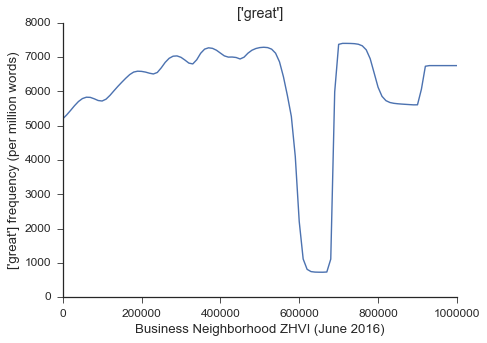

In [26]:
plt.figure()
plt.title(str(keyword))
plt.plot(rdf['x'],rdf['y']*1000000)
plt.xlim(0,1000000)
plt.ylim(0,)
plt.ylabel(str(keyword) +' frequency (per million words)')
plt.xlabel('Business Neighborhood ZHVI (June 2016)')
sns.despine()

We can see that the frequency of the word 'great' increases until the neighborhood home value is greater than 600K. The sparsity of data at high neighborhood home values calls the observed trend into question. The frequency of the word great has been on the rise: 

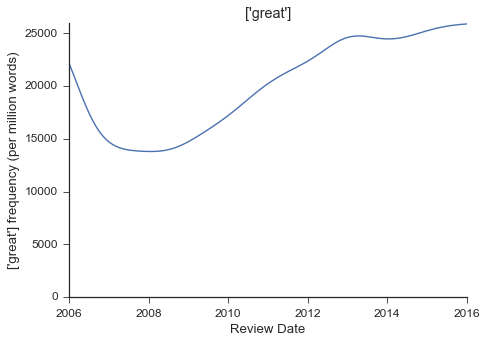

In [27]:
plt.figure()
plt.title(str(keyword))
plt.plot(tdf['x'],tdf['y']*1000000)
plt.xlim(2006,2016)
plt.ylim(0,)
plt.ylabel(str(keyword) +' frequency (per million words)')
plt.xlabel('Review Date')
sns.despine()

In this next plot, we can see that the mean stars for reviews countaining 'great' is constant as a function of ZHVI. 

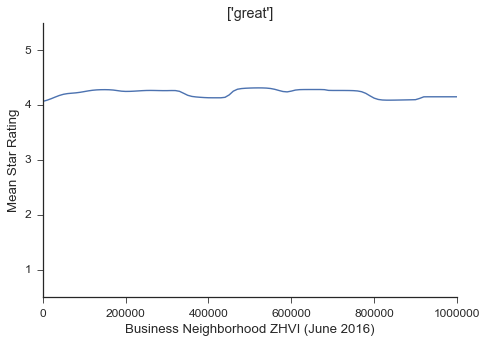

In [28]:
plt.figure()
plt.title(str(keyword))
plt.plot(sdf['x'],sdf['y'])
plt.ylabel('Mean Star Rating')
plt.ylim(0.5,5.5)
plt.xlabel('Business Neighborhood ZHVI (June 2016)')
sns.despine()

In the next cell, we can see how the presence of the keywords in the list affects the rating star assigment. Predictably, the set of reviews containing 'great' has a higher frequency of 4 and 5 star reviews than the set of all reviews.

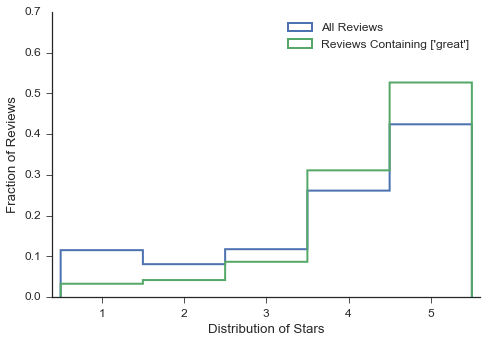

In [29]:
plt.figure()
plt.hist(d['RT']['stars'], range = [0.5,5.5], bins = 5, histtype = 'step', lw = 2, normed = True, label = 'All Reviews')
plt.hist(d['WI']['stars'], range = [0.5,5.5], bins = 5, histtype = 'step', lw = 2, normed = True,\
        label = 'Reviews Containing ' + str(keyword))
plt.ylim(0,0.7)
plt.xlim(0.4, 5.6)
plt.legend()
sns.despine()

plt.xlabel('Distribution of Stars')
plt.ylabel('Fraction of Reviews')

# Finding all about review trends of businesses! 


- Version 1.0: plotting all the business review trends using RollingGaussianMean
- Version 2.0: plotting all the business review trends using BinnedStatistics

In [41]:
# Filter out businesses with fewer that 100 reviews
min_reviews_per_business = 100

# Perform the filtration by updating the dataframes
d['B'] = d['B'][(d['B']['review_count'] >= min_reviews_per_business)]

Number of reviews112


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


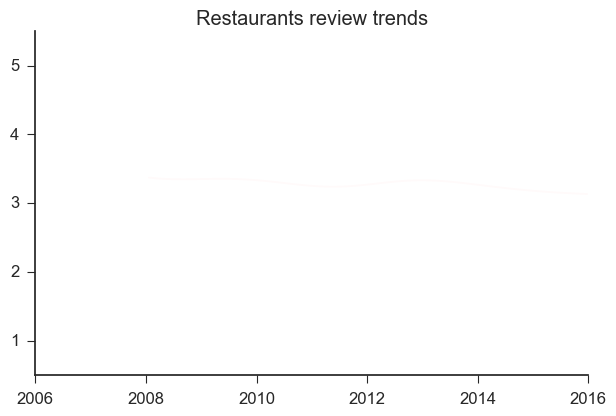

In [49]:
# - Version 1.0: plotting all the business review trends using RollingGaussianMean

for ids in np.unique(d['B']['business_id'])[0:1]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    print ("Number of reviews" + str(len(r)))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(min(r['year']),max(r['year']), 50), 1)
    plt.title('Restaurants review trends')
    plt.ylim(0.5, 5.5)
    plt.xlim(2006,2016)
    plt.plot(gm['x'], gm['y'], c = 'r', alpha = 0.02)
    sns.despine()

In [117]:
# - Version 2.0: plotting all the business review trends using BinnedStatistics

# Binned Statistics Func
def ResExam(x, y, bins = 10):
    
    bm, be, _ = scipy.stats.binned_statistic(x, y, statistic = 'mean', bins = bins)
    bs, _, _ = scipy.stats.binned_statistic(x, y, statistic = 'std', bins = bins)
    berr, _ ,_ = scipy.stats.binned_statistic(x, y, statistic = scipy.stats.sem, bins = bins)

    bin_width = (be[1] - be[0]) #compute the bin width, to calculate the bin centers
    bc = be[1:] - bin_width/2 #compute the bin centers

    fig = plt.figure()
    #plt.scatter(x,y, lw = 0, s = 0.5, alpha = 1, c = 'black') #lightly scatter the original data
    plt.errorbar(bc, bm, berr, fmt = '.',color = 'red', lw = 1) #now draw the binned statistic
    plt.axhline(0, c = 'grey', lw = 0.5) #plot the 0 residual line

    plt.gca().yaxis.set_label_coords(-0.12, 0.5)
    sns.despine()
    
    return pd.DataFrame({'x': bc, 'mean': bm, 'sem': berr}), np.std(y), fig



In [219]:
fit_params = defaultdict(list)

Number of reviews: 112
Number of reviews: 156


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 163
Number of reviews: 107
Number of reviews: 292


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 202
Number of reviews: 564
Number of reviews: 241


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 96
Number of reviews: 155
Number of reviews: 134


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 395
Number of reviews: 143
Number of reviews: 293


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 271
Number of reviews: 109


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 117
Number of reviews: 217
Number of reviews: 190


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


Number of reviews: 198
Number of reviews: 153
Number of reviews: 126


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 222
Number of reviews: 161


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 129
Number of reviews: 159


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 144
Number of reviews: 263


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 290
Number of reviews: 102


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 170
Number of reviews: 183
Number of reviews: 210


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 358
Number of reviews: 102


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 109
Number of reviews: 119


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 114
Number of reviews: 122


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 234
Number of reviews: 857


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 103
Number of reviews: 443


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 106
Number of reviews: 160
Number of reviews: 134


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 137
Number of reviews: 250


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 111
Number of reviews: 368


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 133
Number of reviews: 114


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 140
Number of reviews: 97
Number of reviews: 305


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 161
Number of reviews: 127


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 131
Number of reviews: 141


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 150
Number of reviews: 96


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 374
Number of reviews: 146


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 109
Number of reviews: 198


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 113
Number of reviews: 140


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 96
Number of reviews: 184


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 237
Number of reviews: 133


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 383
Number of reviews: 245
Number of reviews: 86


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.

Number of reviews: 91
Number of reviews: 209
Number of reviews: 229


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.

Number of reviews: 190
Number of reviews: 114
Number of reviews: 129


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 257
Number of reviews: 115
Number of reviews: 92


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 156
Number of reviews: 104
Number of reviews: 158


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 224
Number of reviews: 104
Number of reviews: 138


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 329
Number of reviews: 314
Number of reviews: 183


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 278
Number of reviews: 98


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 121
Number of reviews: 207


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 364
Number of reviews: 423


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 747
Number of reviews: 170


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 167
Number of reviews: 109


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 133
Number of reviews: 121


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 182
Number of reviews: 158


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 353
Number of reviews: 93


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 95
Number of reviews: 127


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 104
Number of reviews: 121
Number of reviews: 170


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 250
Number of reviews: 97
Number of reviews: 126


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.

Number of reviews: 357
Number of reviews: 1465


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 90
Number of reviews: 140


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 115
Number of reviews: 174
Number of reviews: 219


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 318


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 131
Number of reviews: 102
Number of reviews: 104


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 153
Number of reviews: 726
Number of reviews: 266


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.

Number of reviews: 221
Number of reviews: 164
Number of reviews: 102


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.

Number of reviews: 237
Number of reviews: 157


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 116
Number of reviews: 174


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 253
Number of reviews: 125


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 187


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 162
Number of reviews: 91


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 239
Number of reviews: 93


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 133
Number of reviews: 133


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 222
Number of reviews: 512


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 286
Number of reviews: 192


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 94
Number of reviews: 403


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 116
Number of reviews: 108


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 292
Number of reviews: 130


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 309
Number of reviews: 248


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 197
Number of reviews: 108


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 99
Number of reviews: 164


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 96


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 128


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 110
Number of reviews: 144


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 154
Number of reviews: 81


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 148
Number of reviews: 155


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 123
Number of reviews: 108
Number of reviews: 109


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 256
Number of reviews: 149


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 186


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 189
Number of reviews: 364


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 177


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 255
Number of reviews: 232


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 108


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 173
Number of reviews: 257


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 150
Number of reviews: 202
Number of reviews: 359


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 129
Number of reviews: 737
Number of reviews: 202


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.

Number of reviews: 152
Number of reviews: 847


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 133
Number of reviews: 107
Number of reviews: 194


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

Number of reviews: 290
Number of reviews: 266


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 103
Number of reviews: 567


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Number of reviews: 154


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


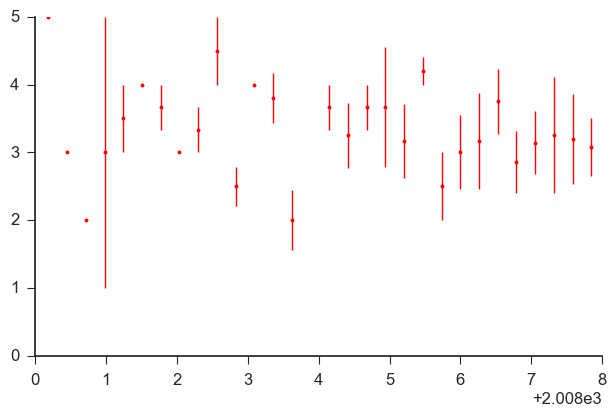

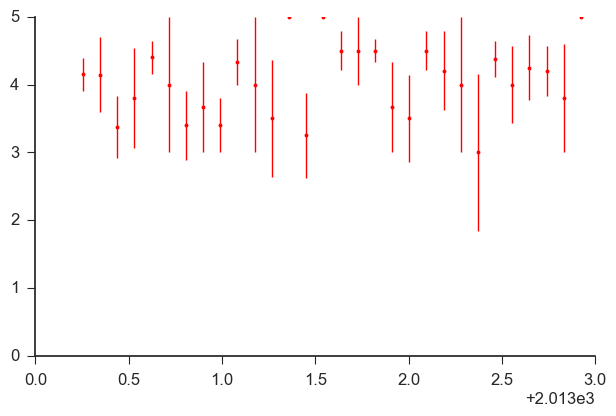

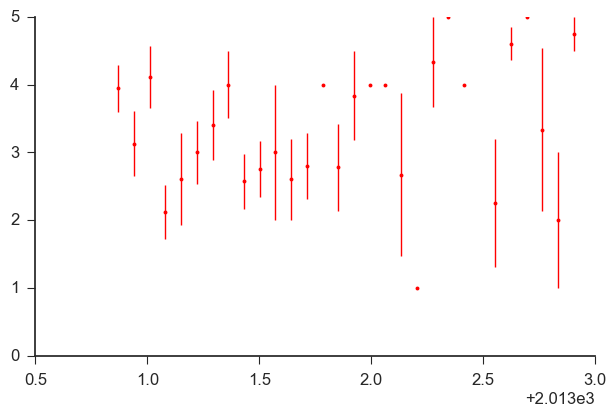

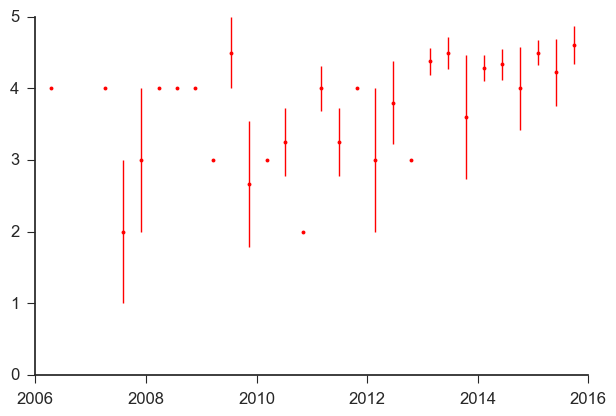

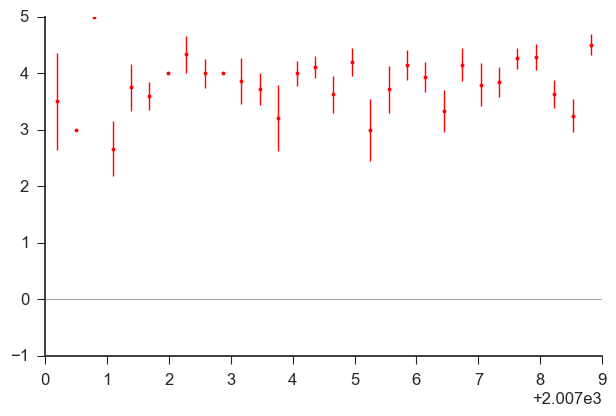

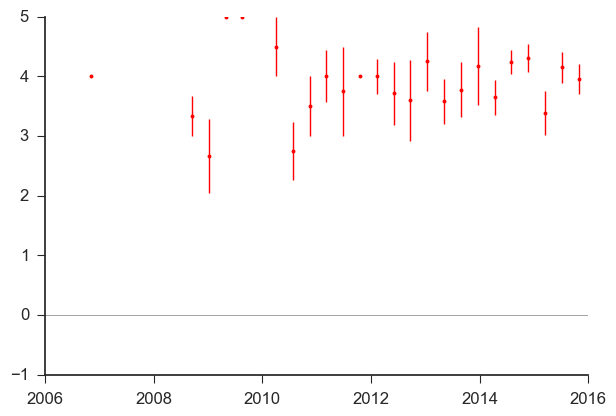

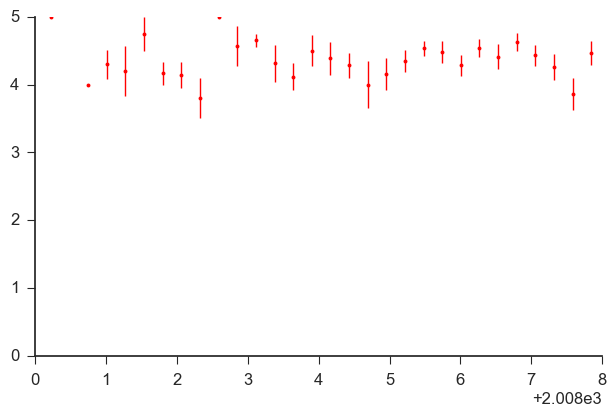

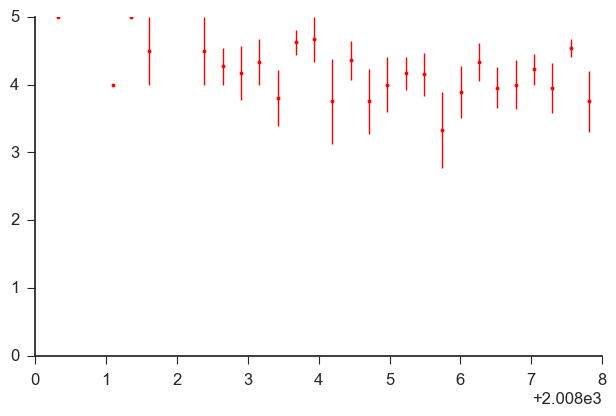

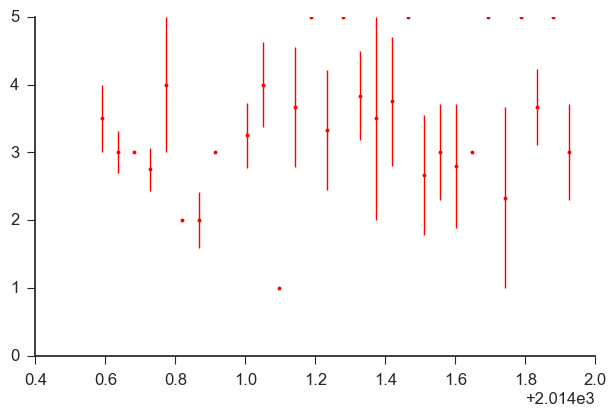

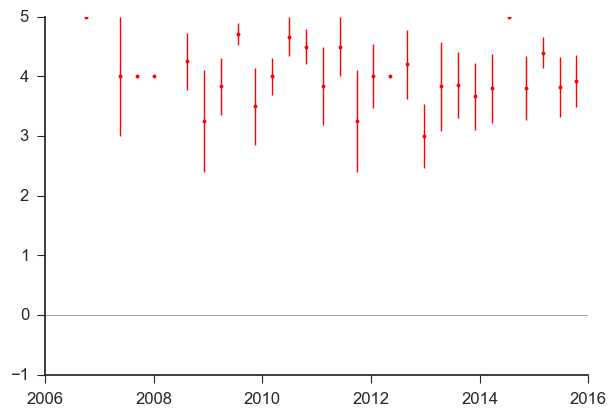

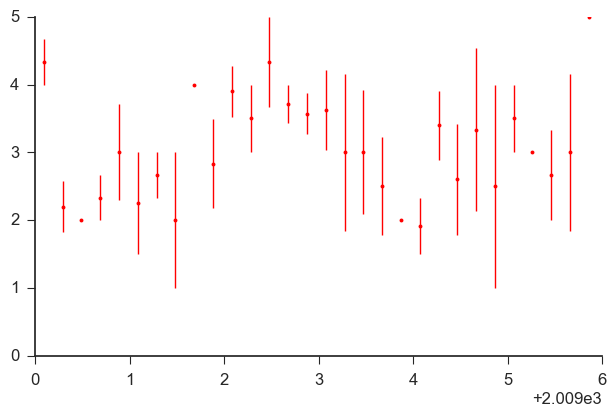

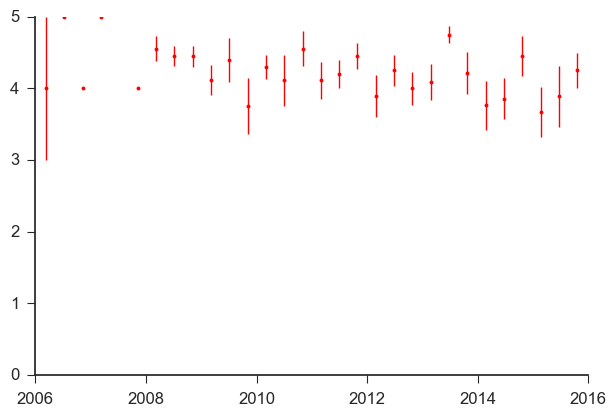

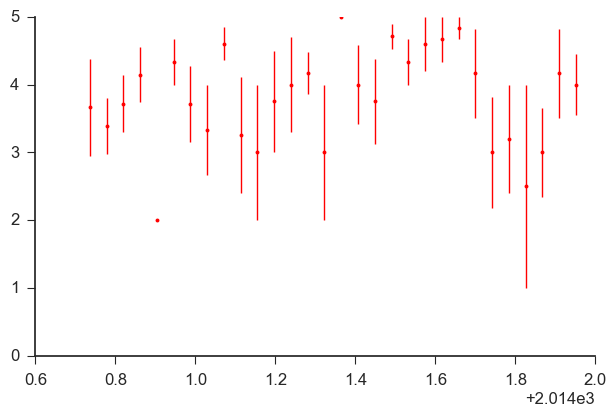

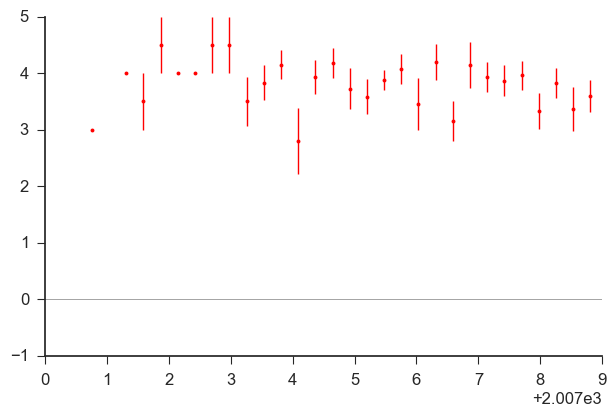

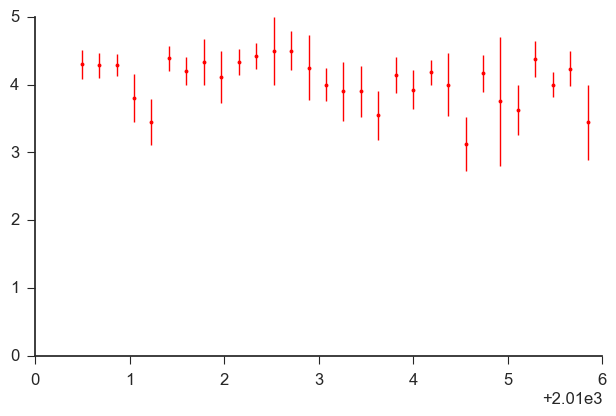

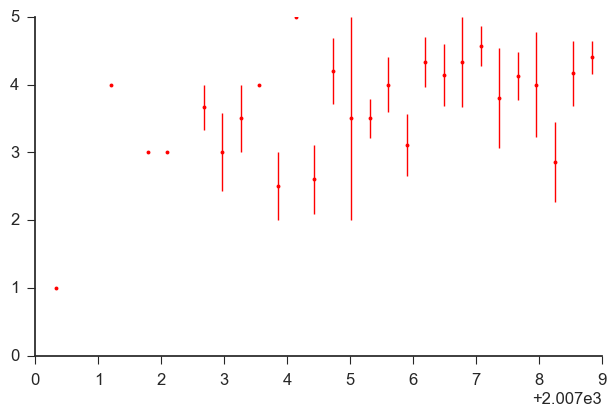

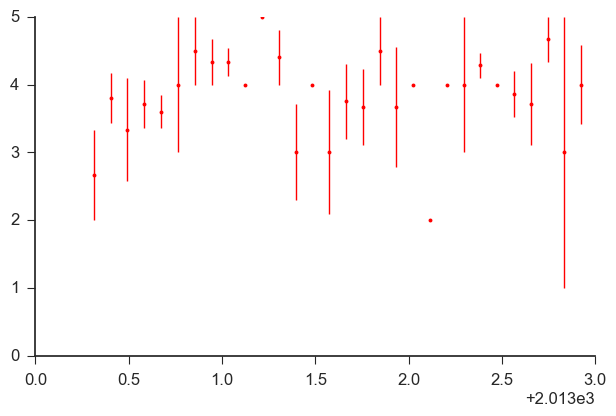

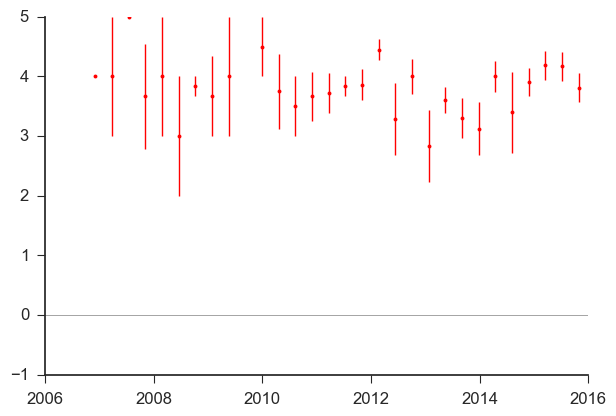

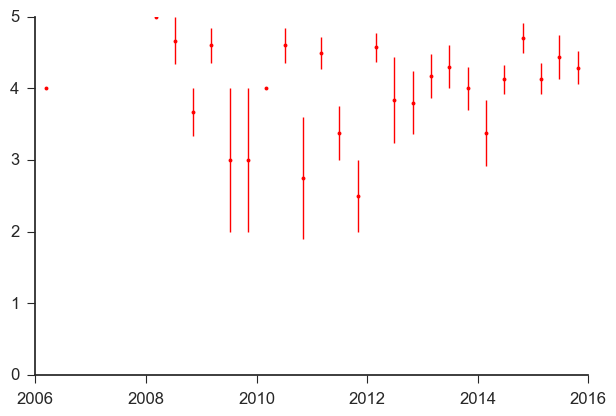

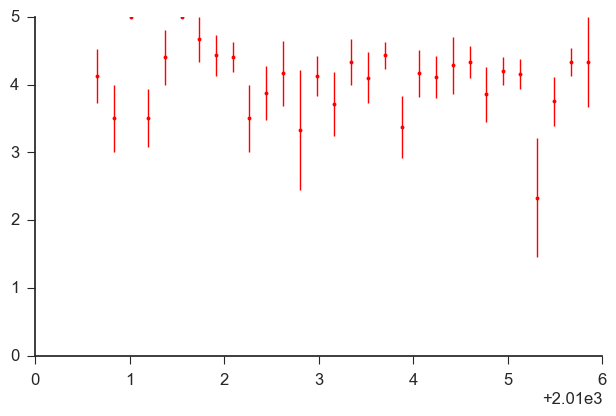

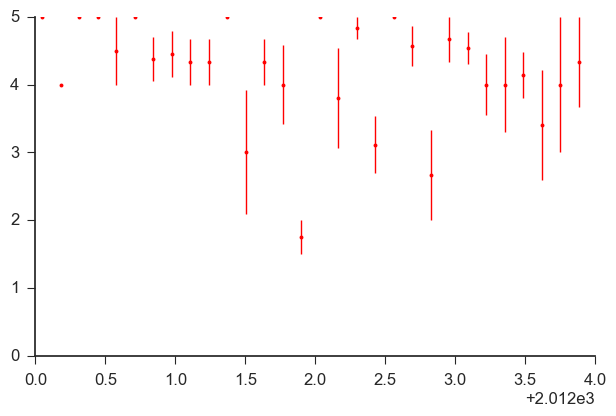

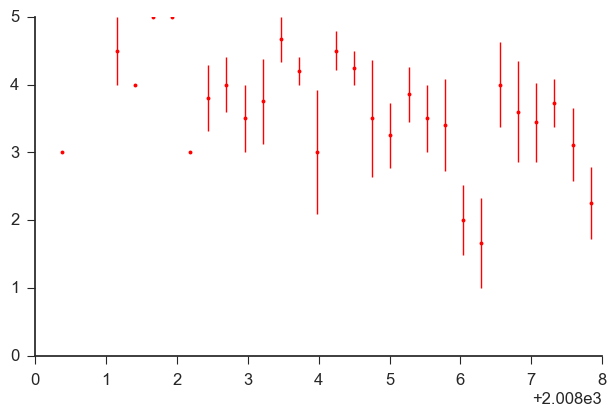

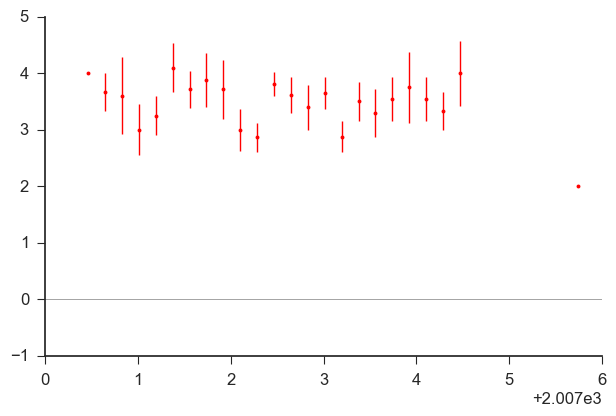

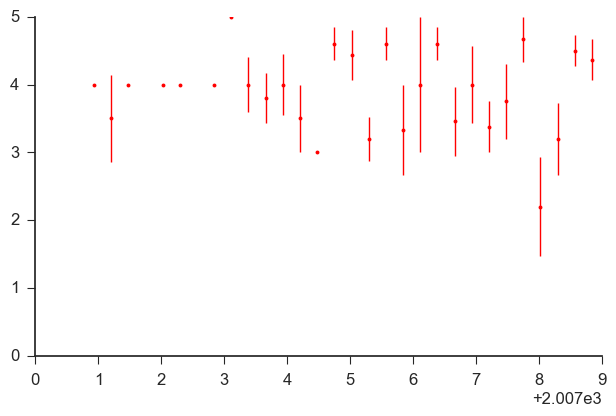

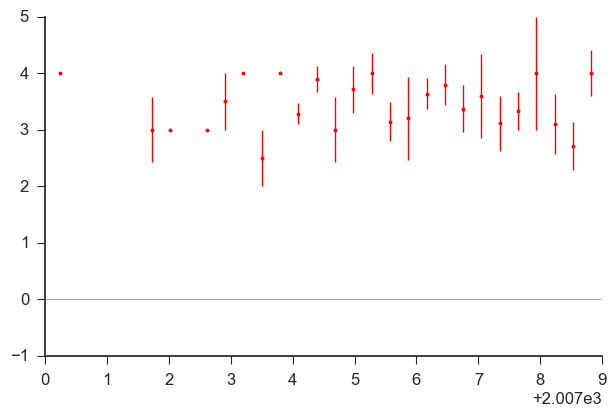

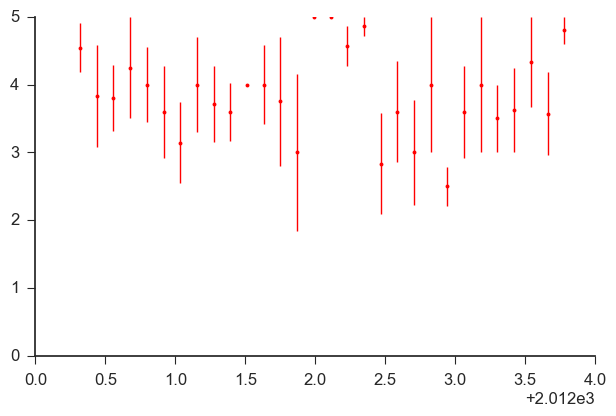

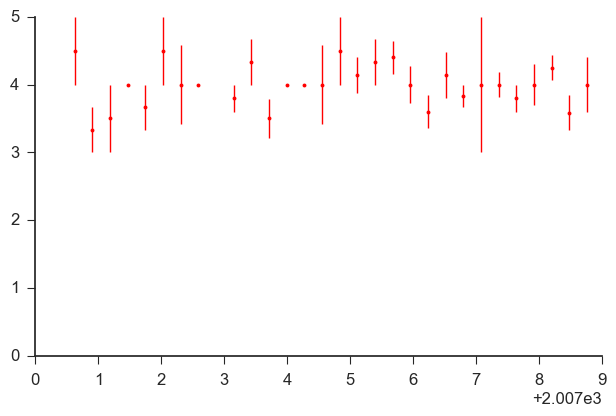

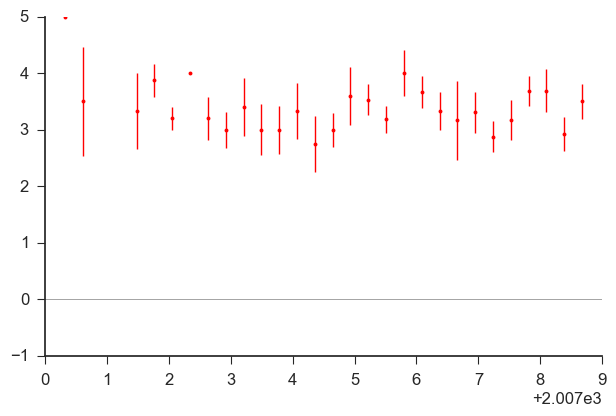

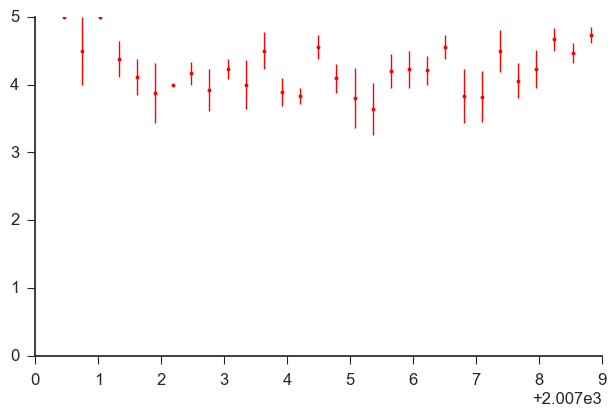

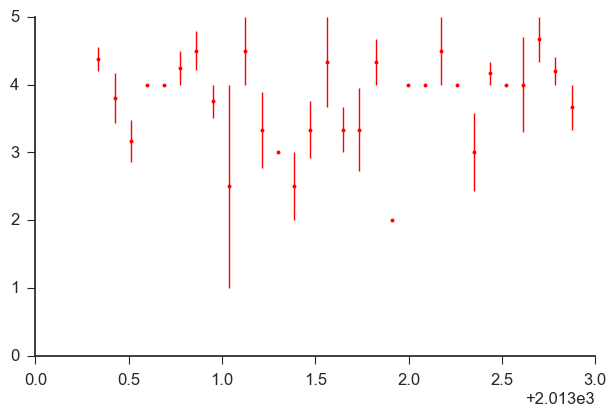

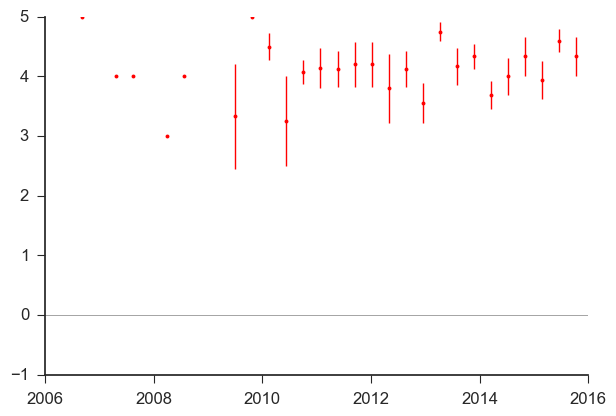

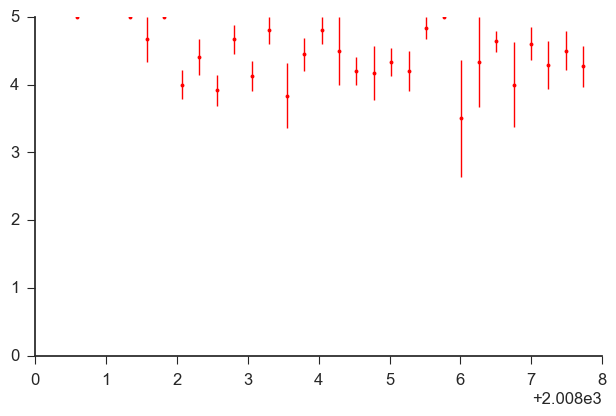

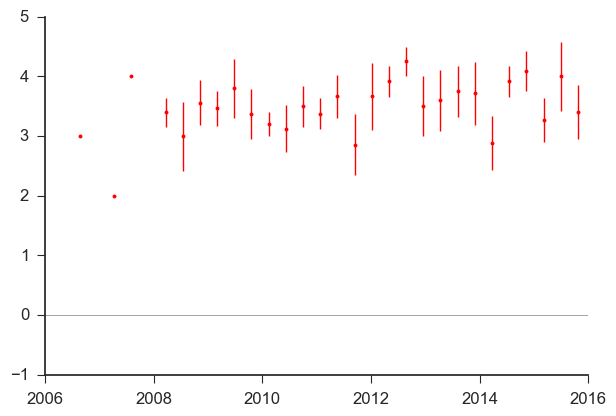

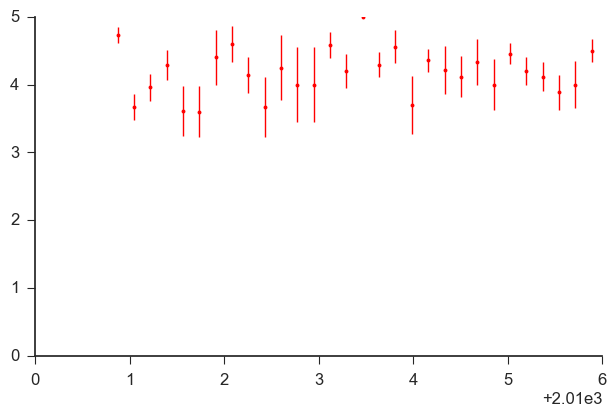

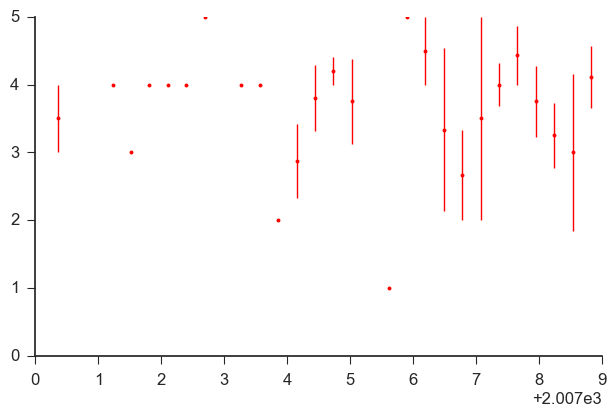

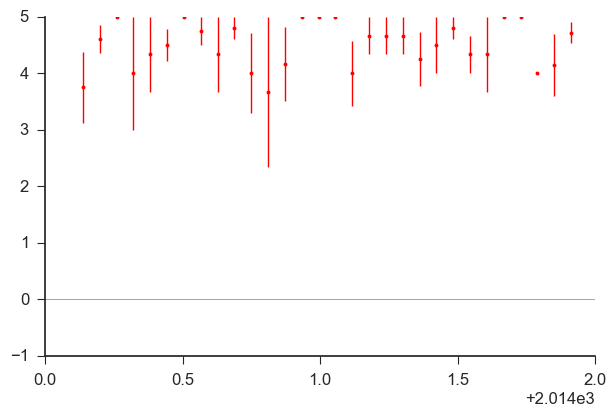

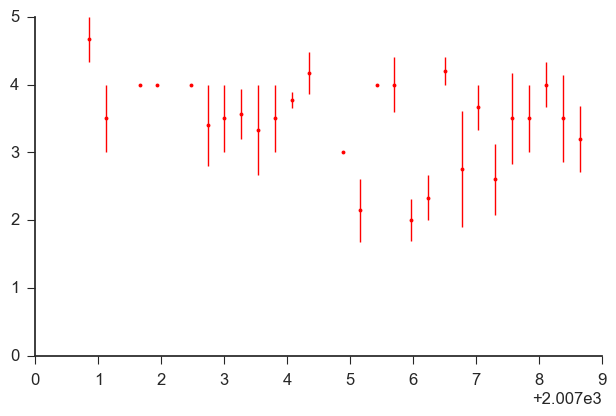

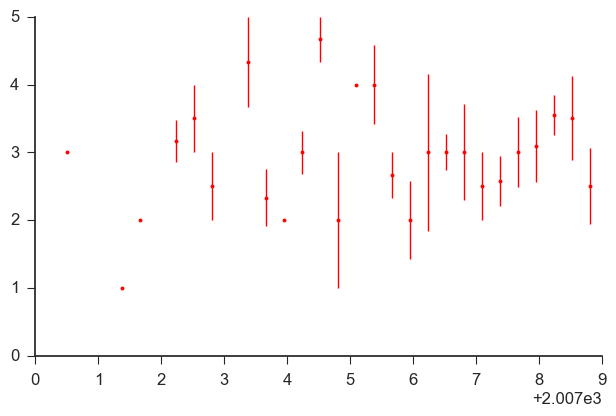

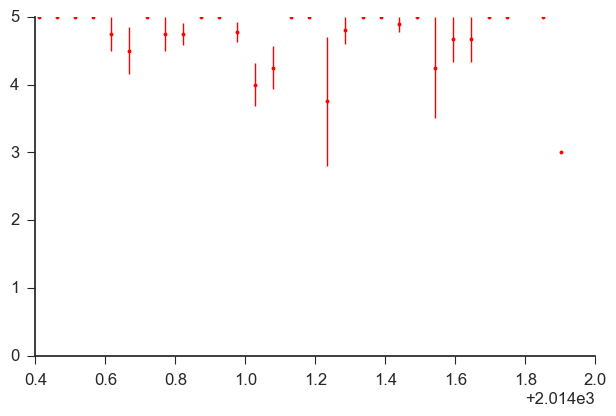

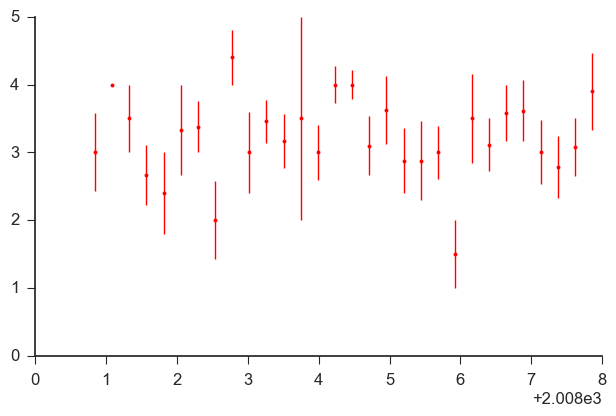

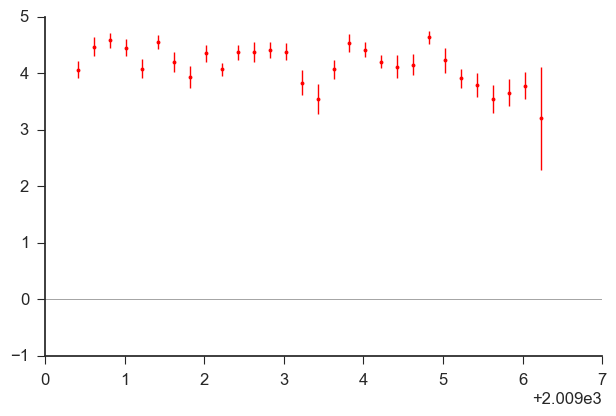

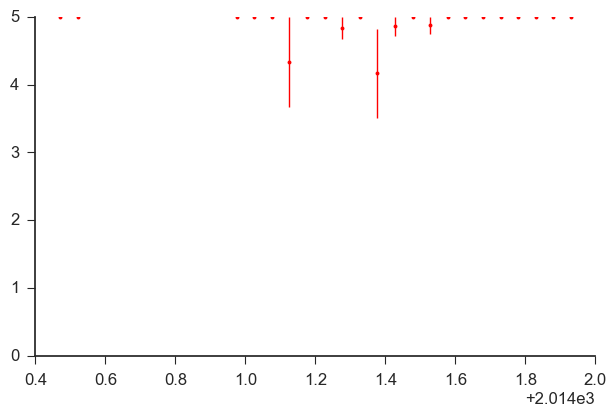

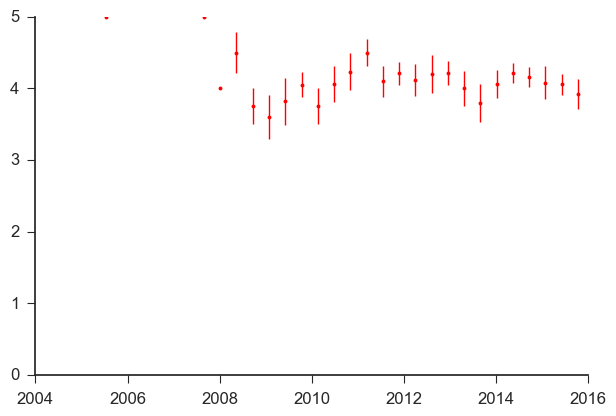

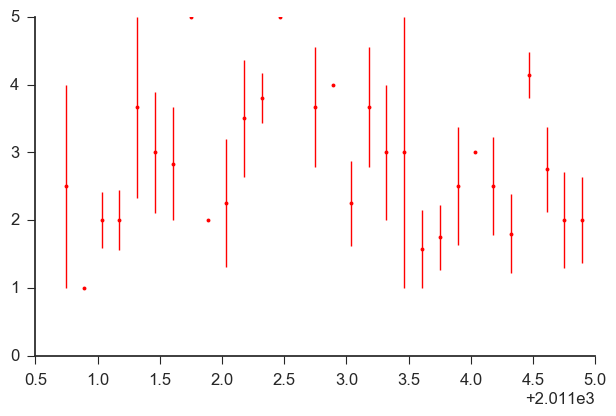

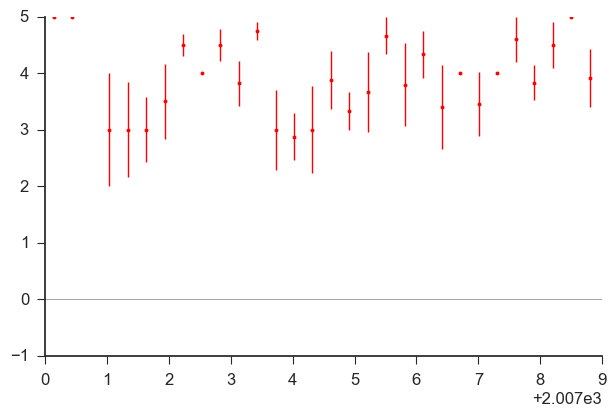

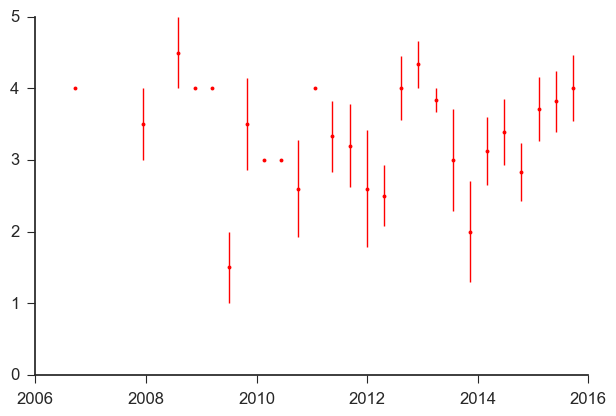

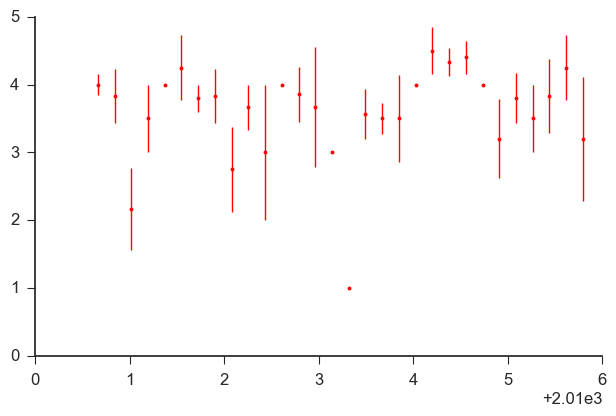

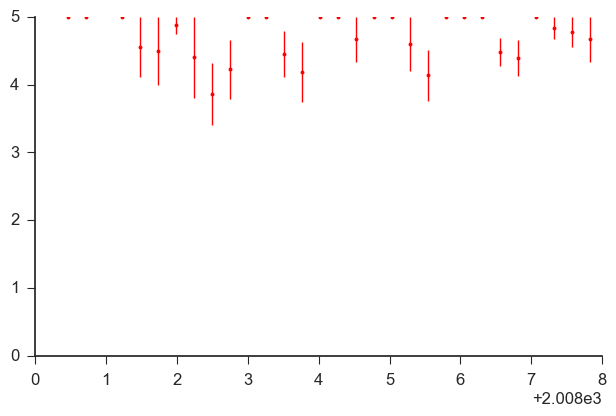

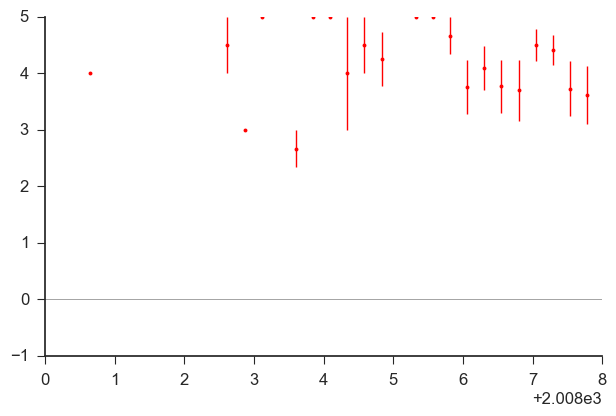

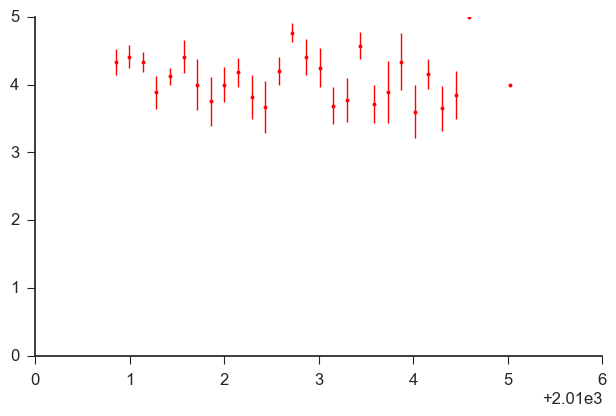

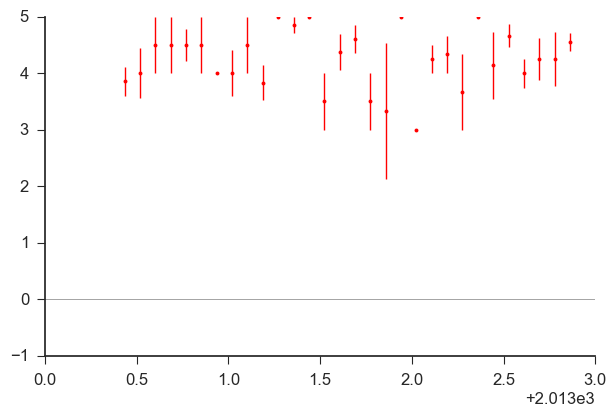

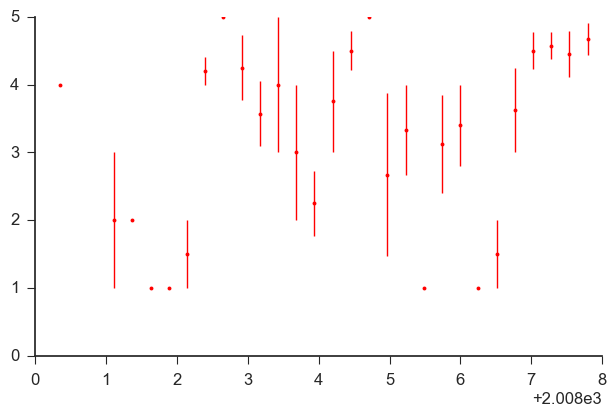

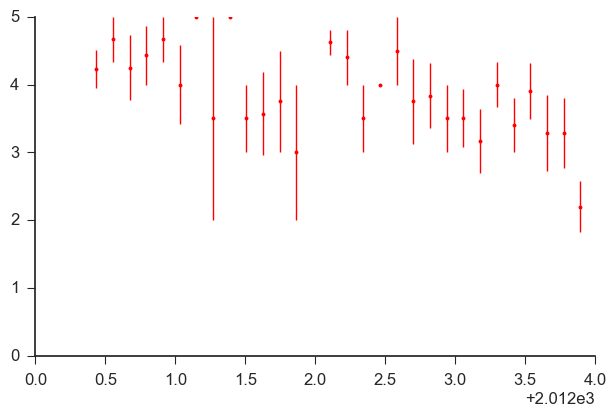

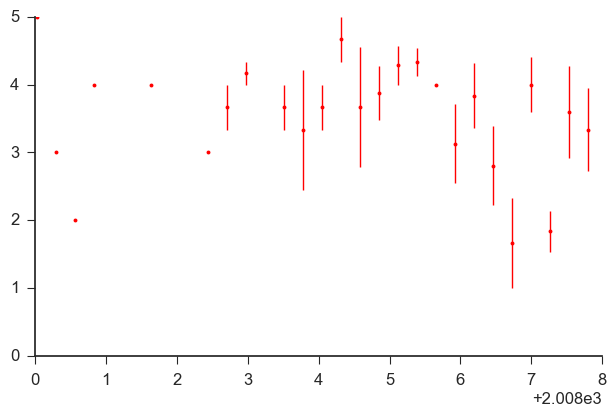

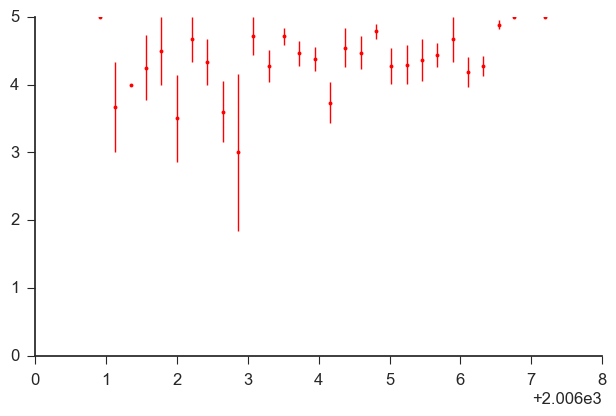

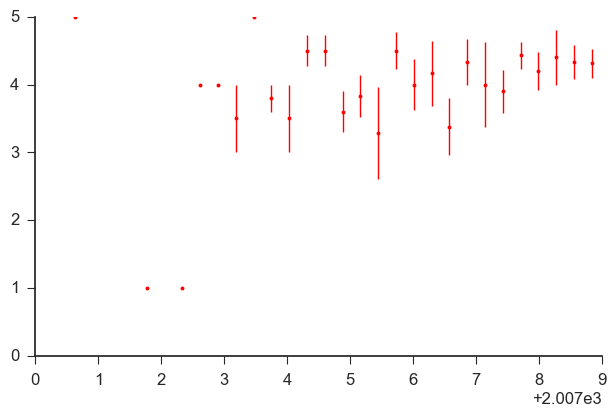

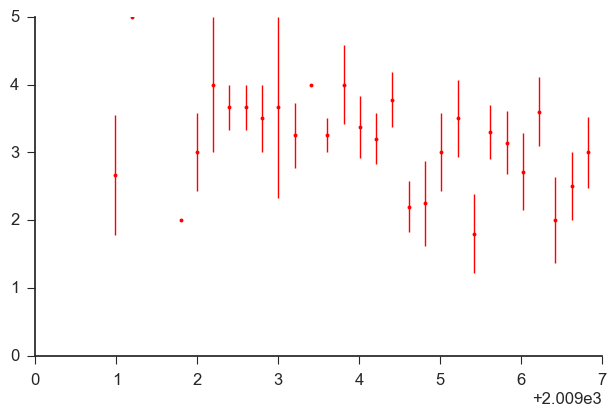

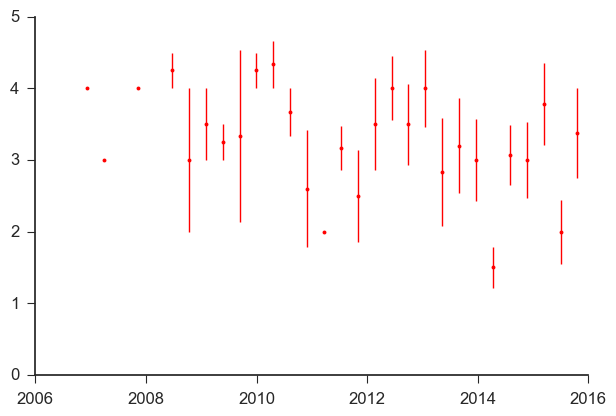

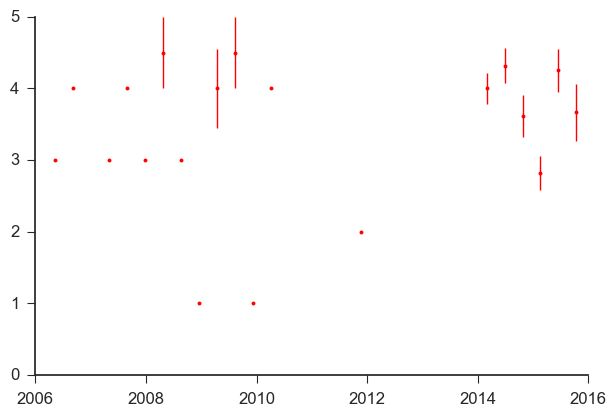

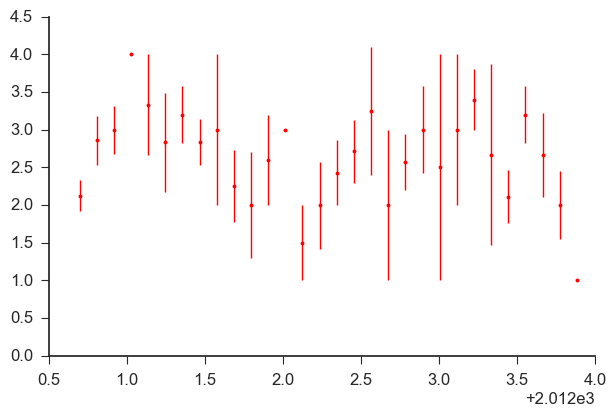

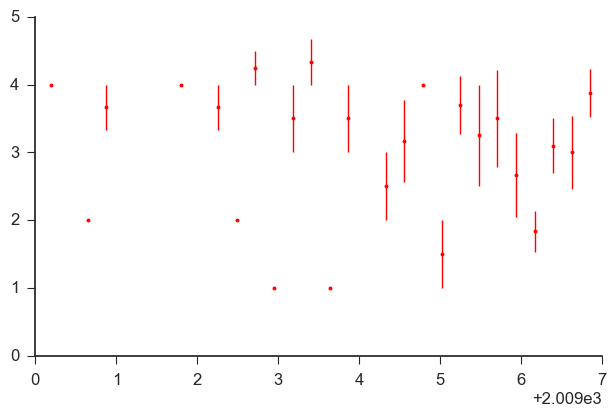

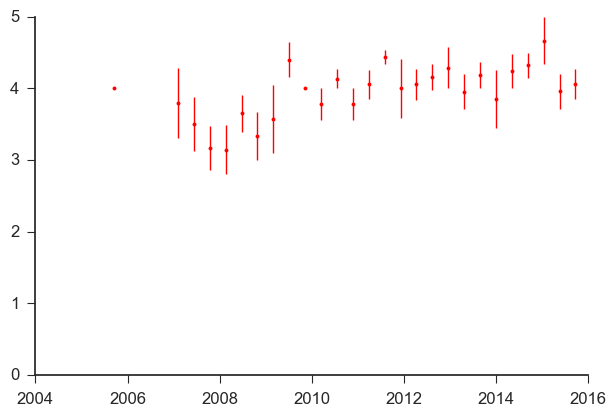

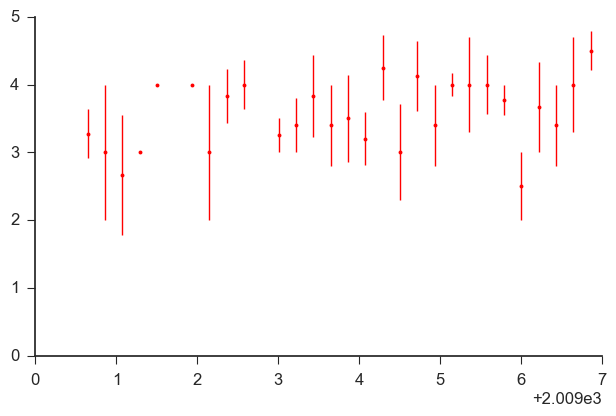

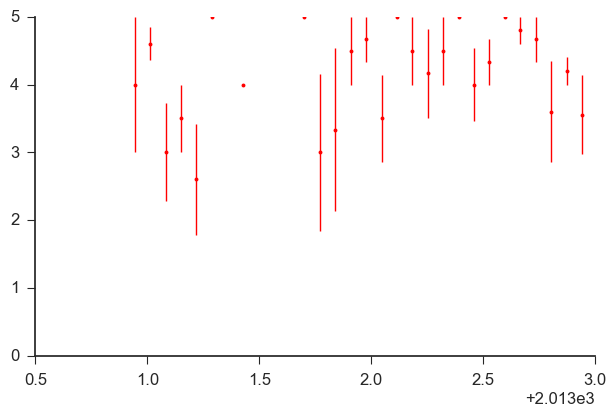

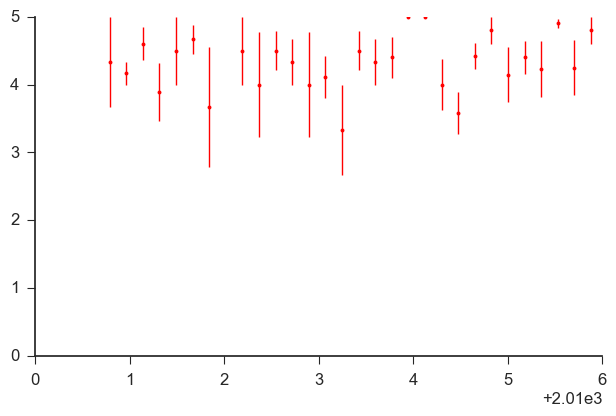

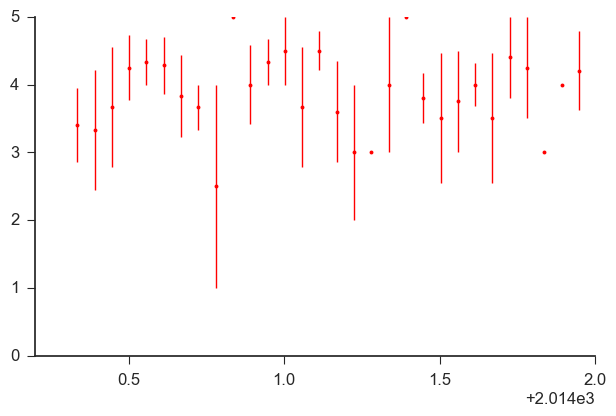

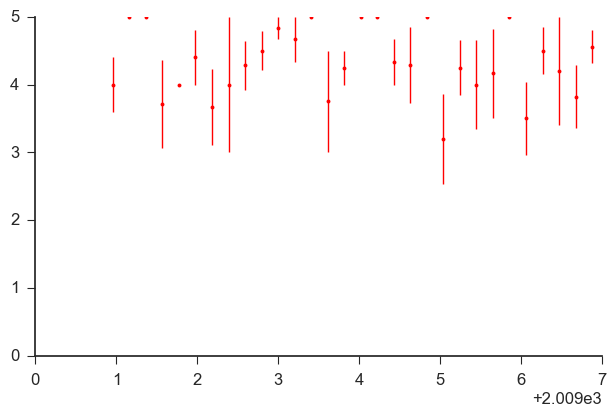

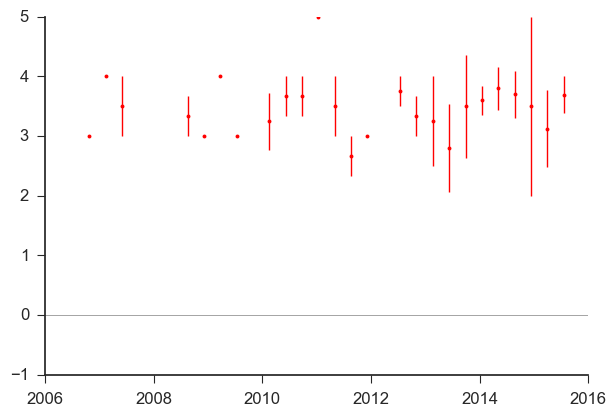

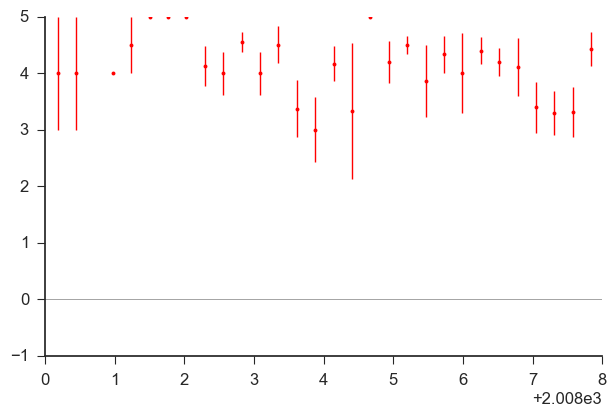

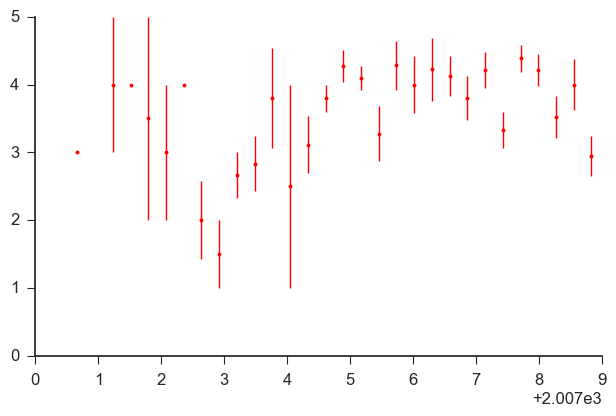

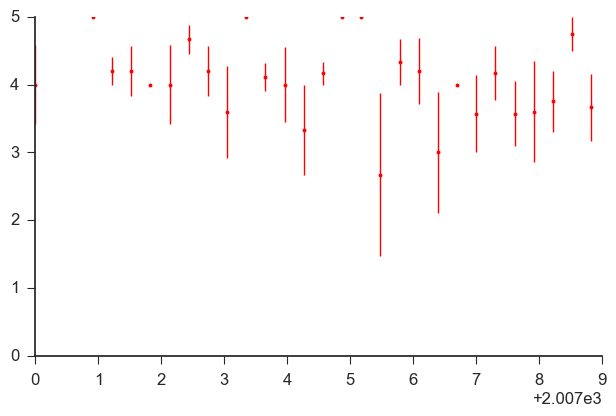

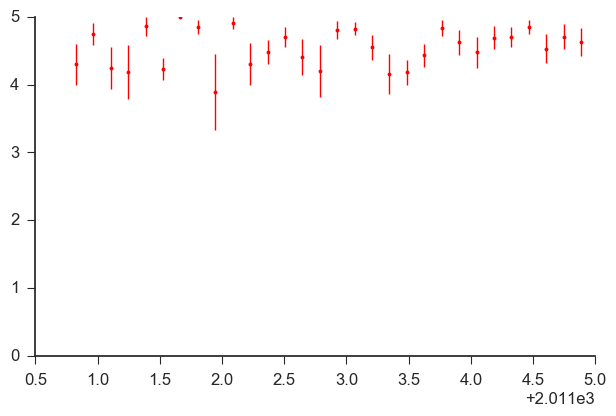

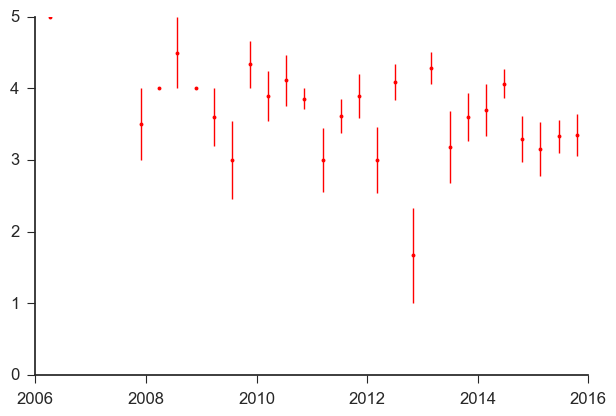

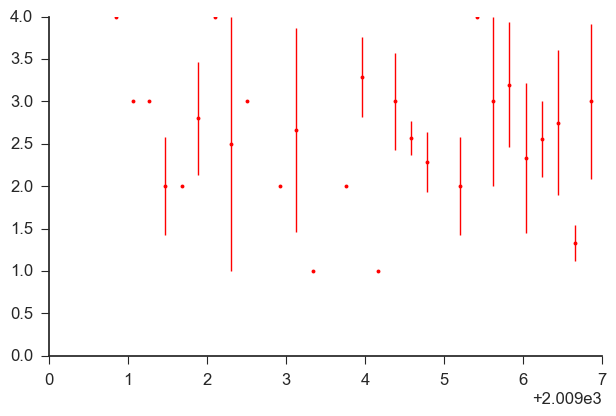

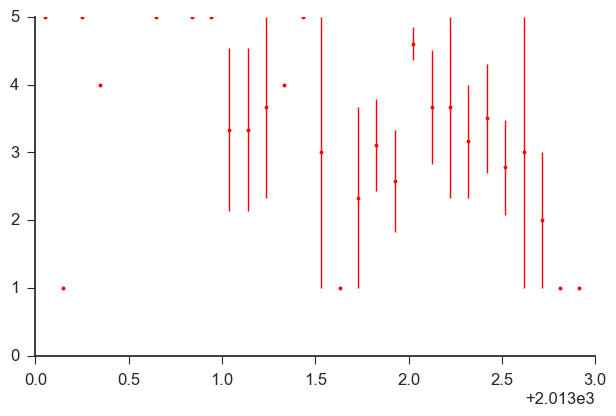

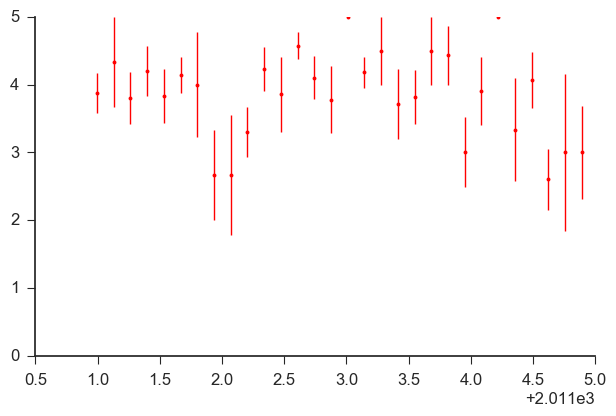

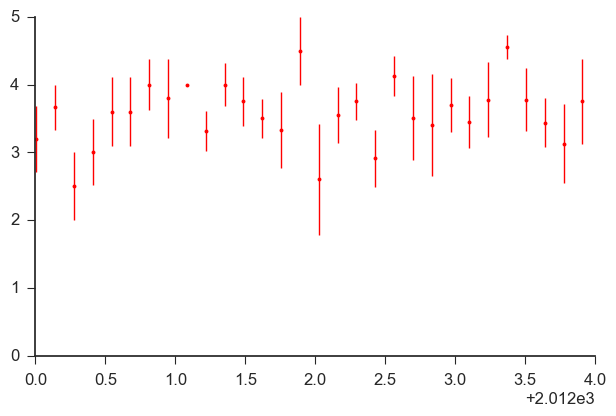

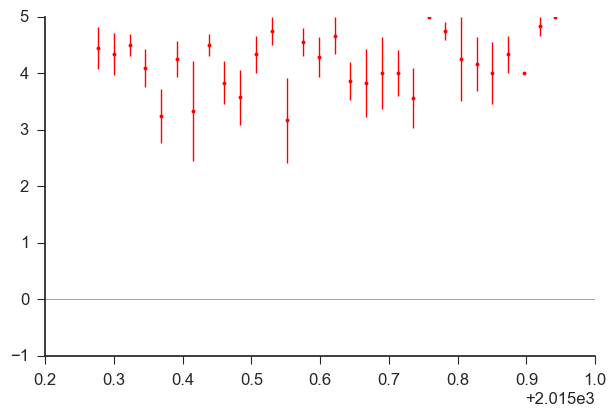

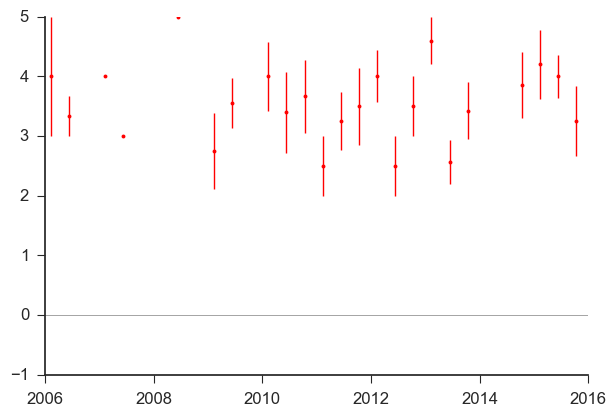

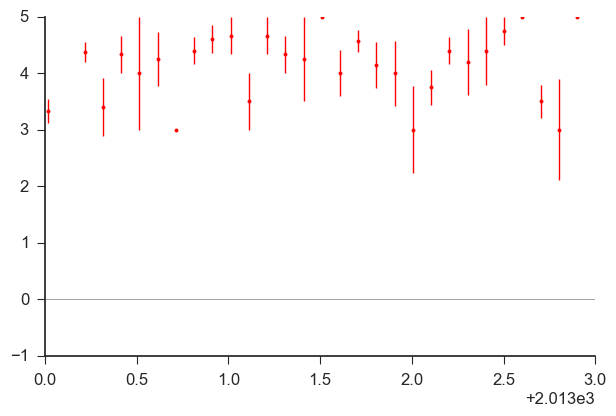

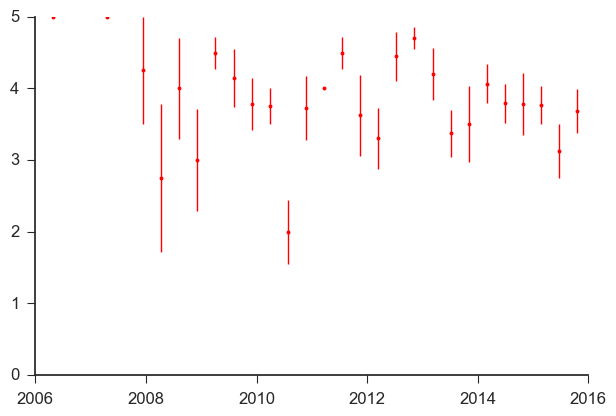

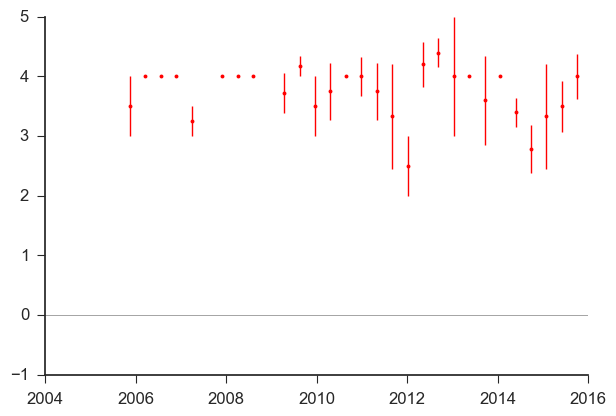

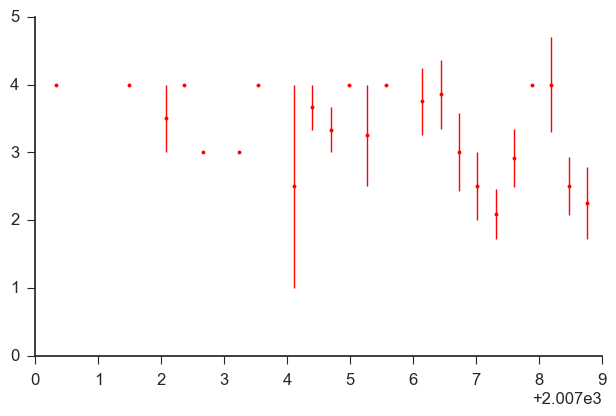

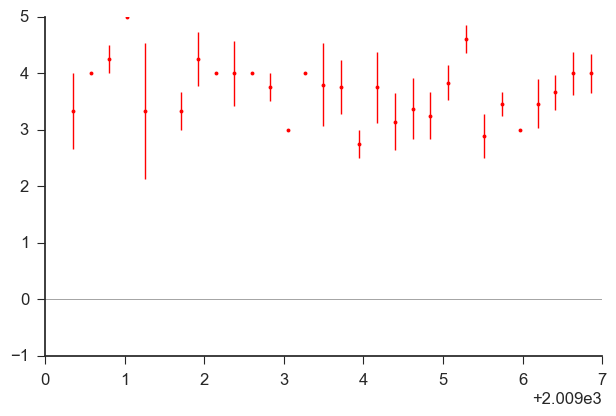

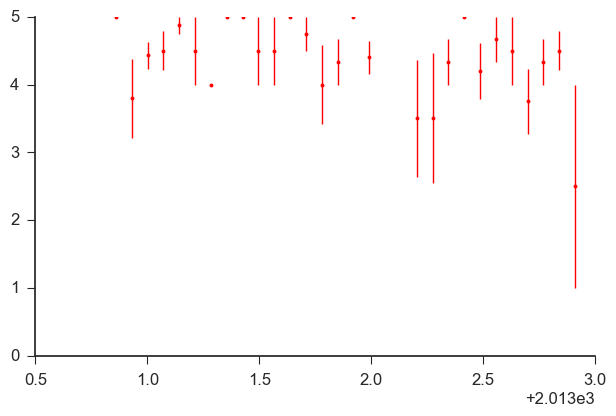

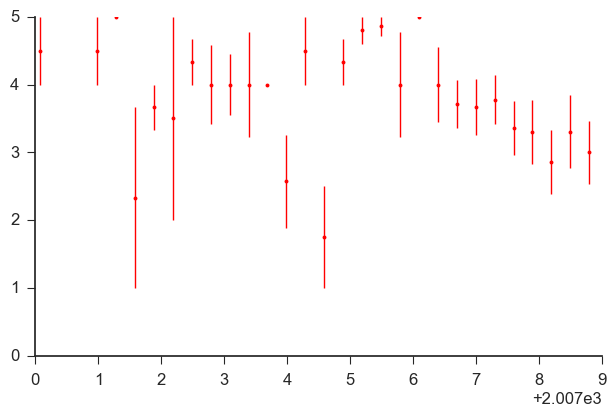

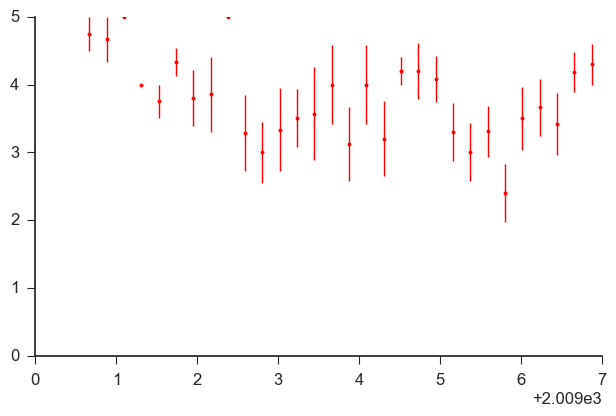

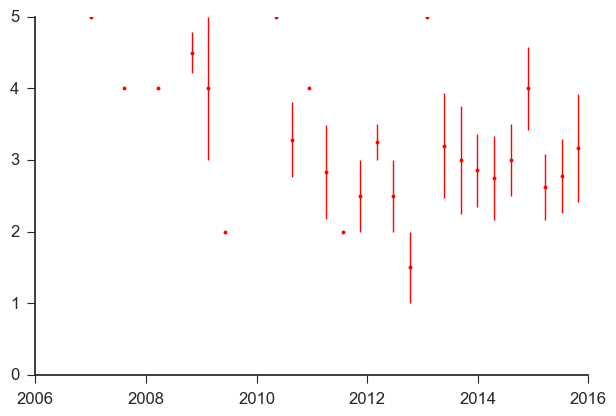

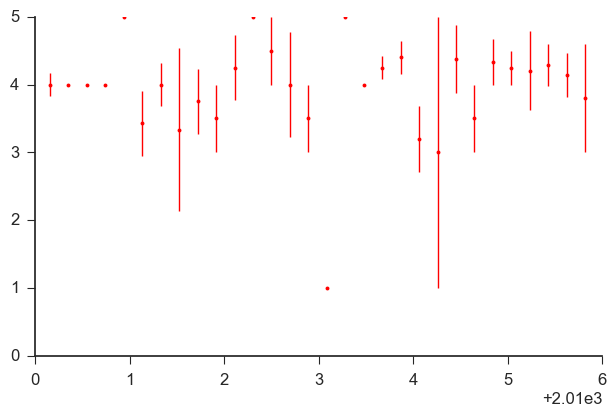

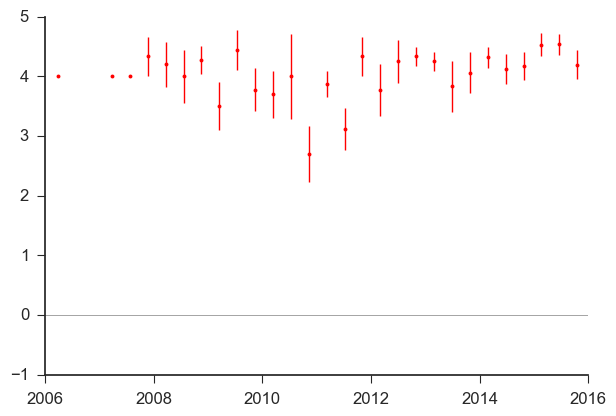

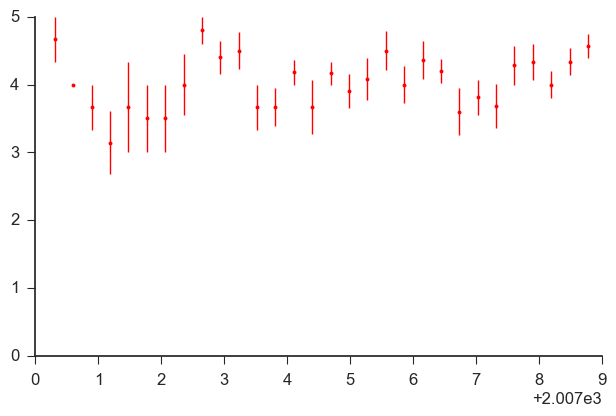

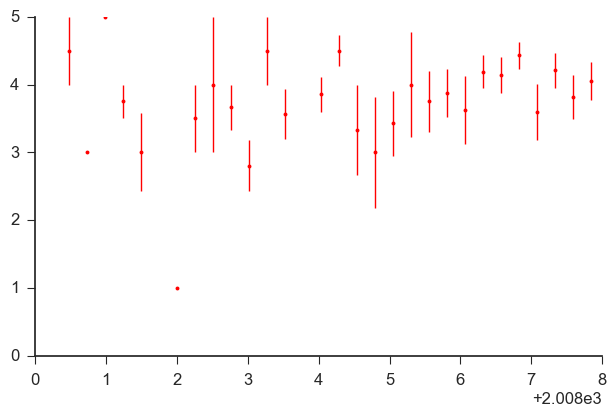

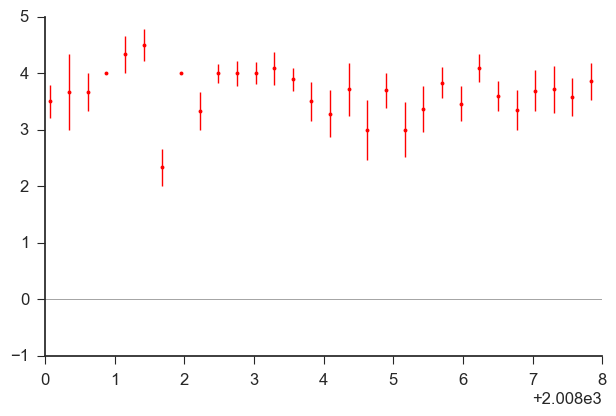

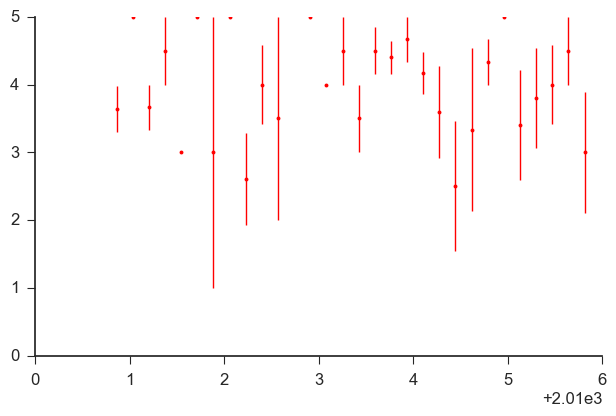

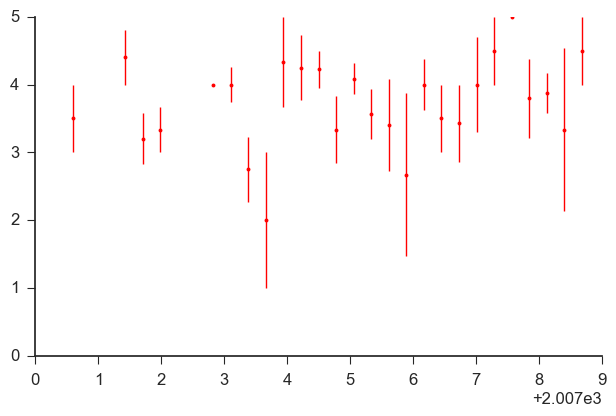

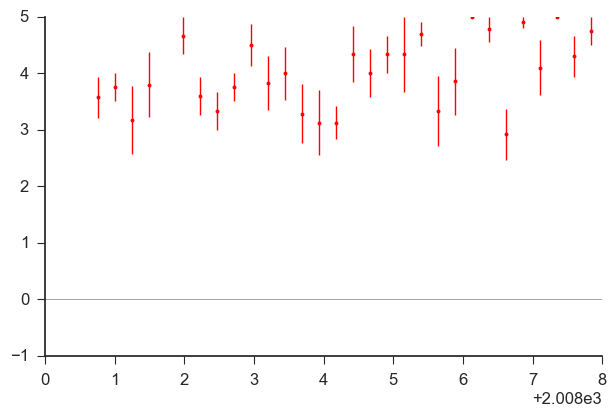

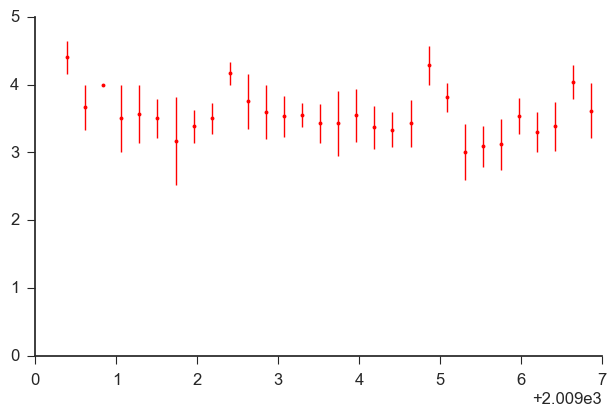

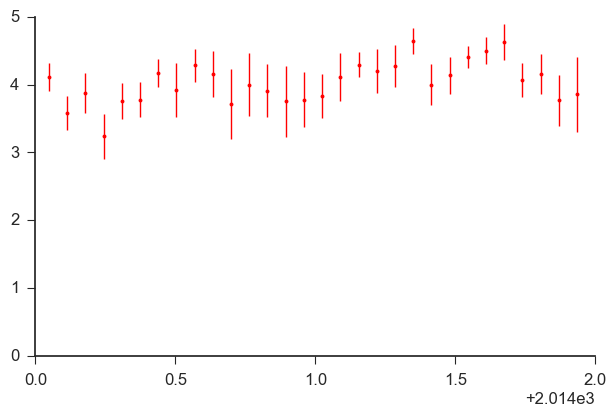

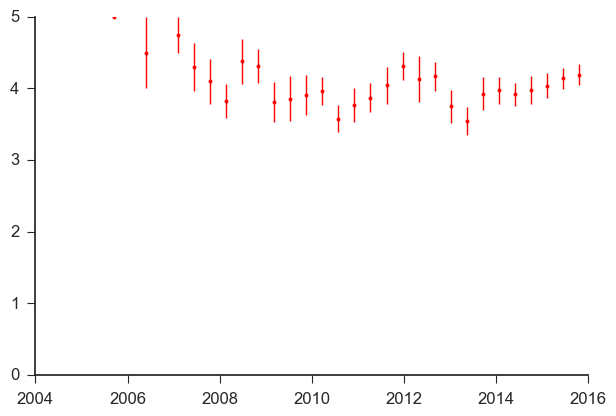

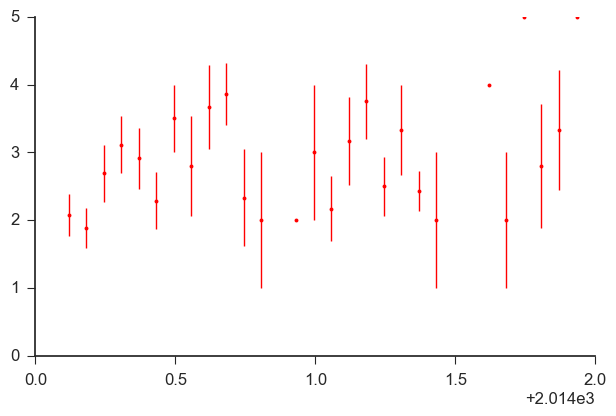

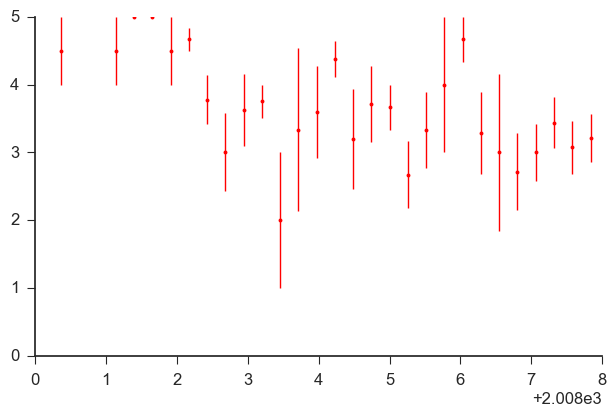

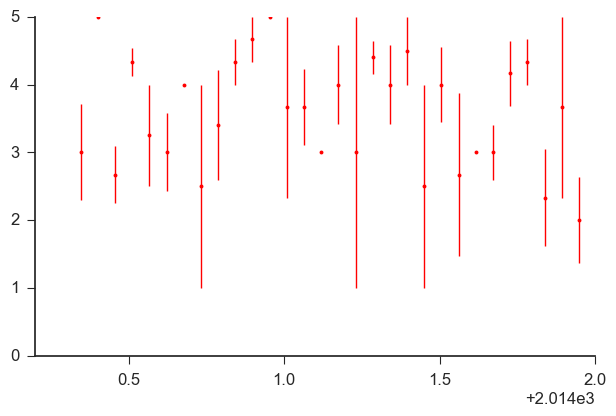

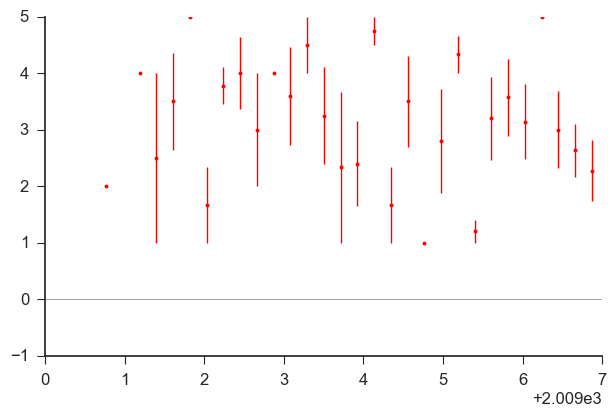

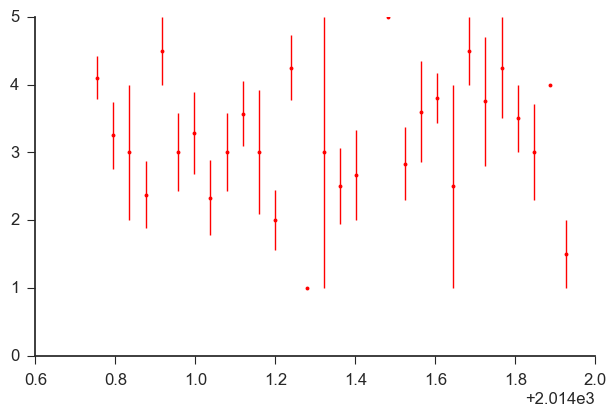

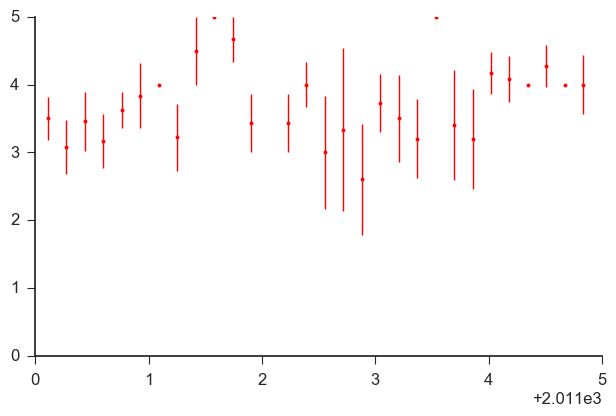

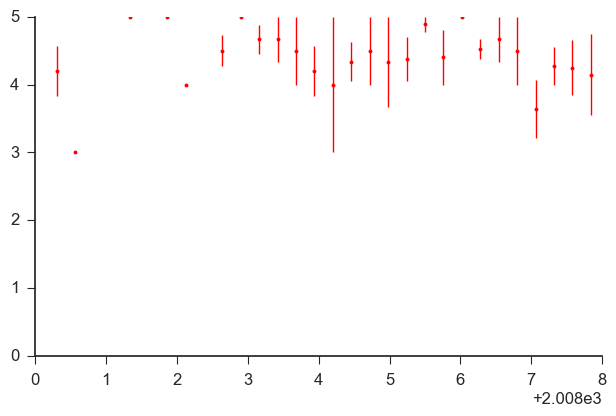

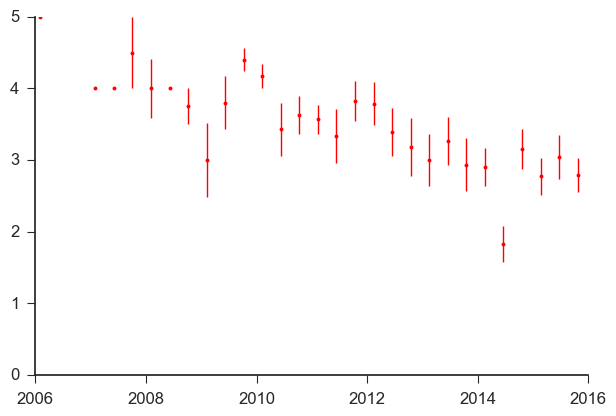

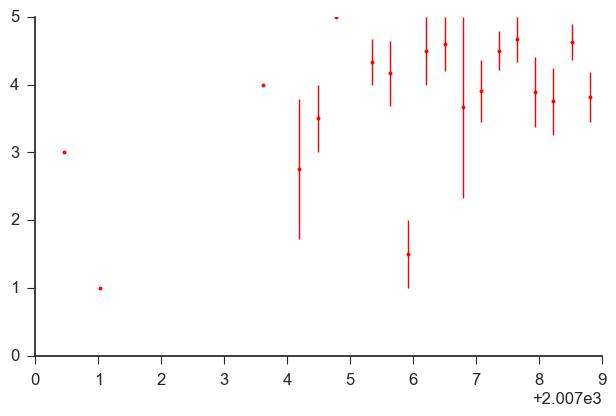

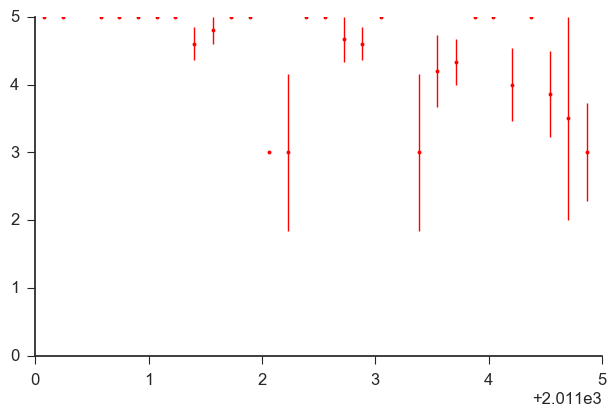

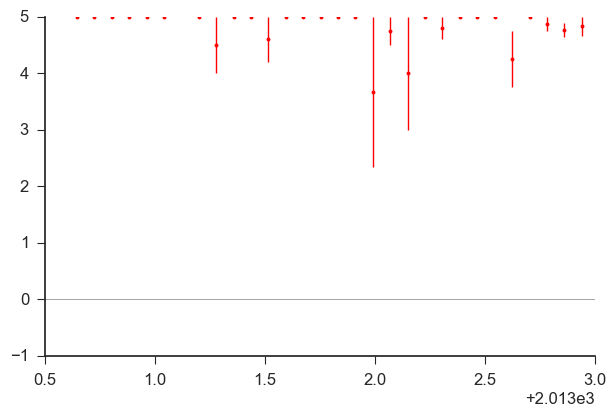

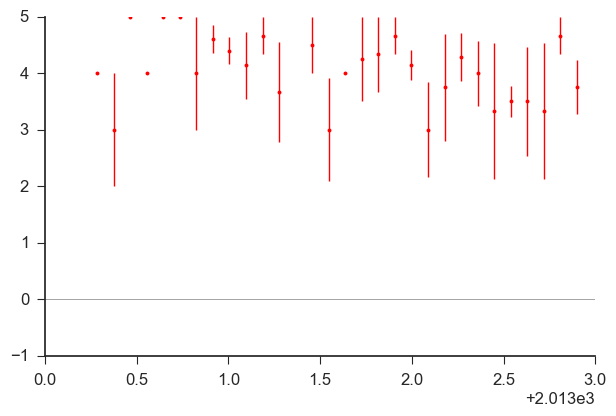

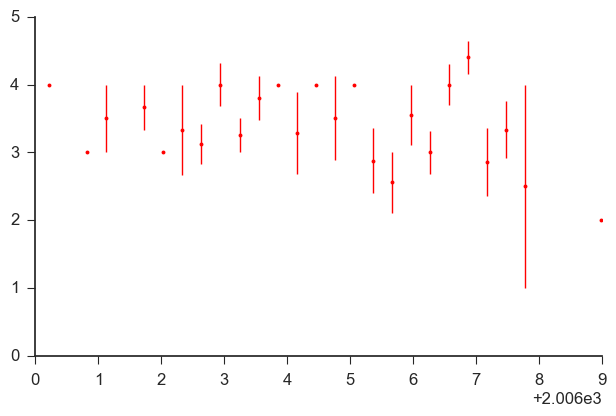

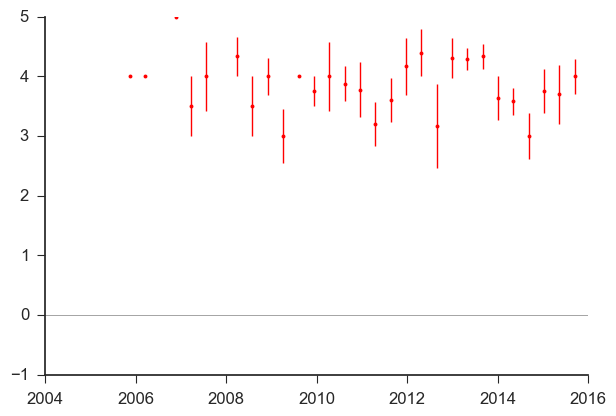

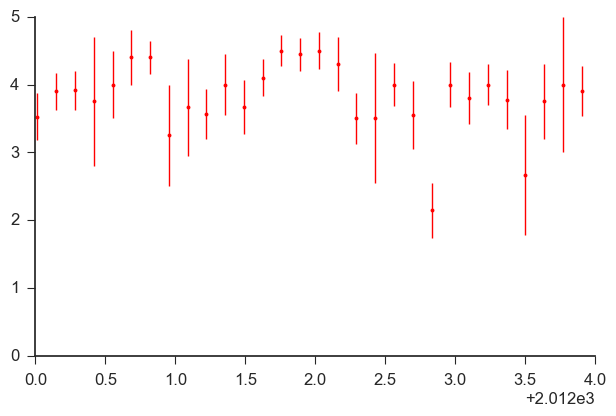

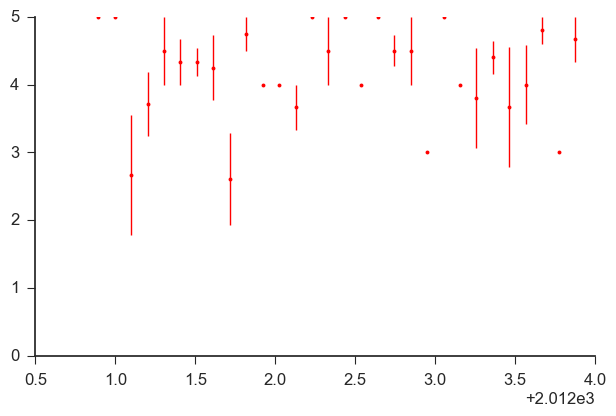

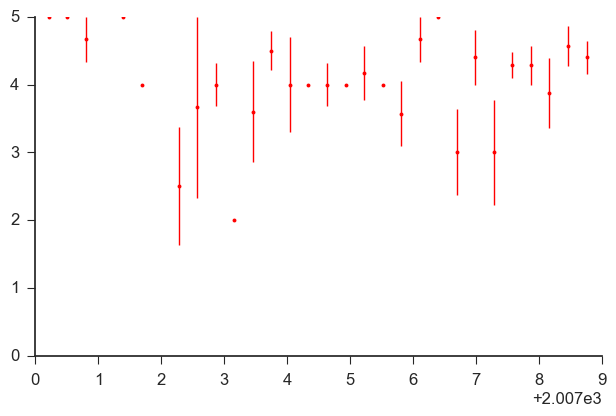

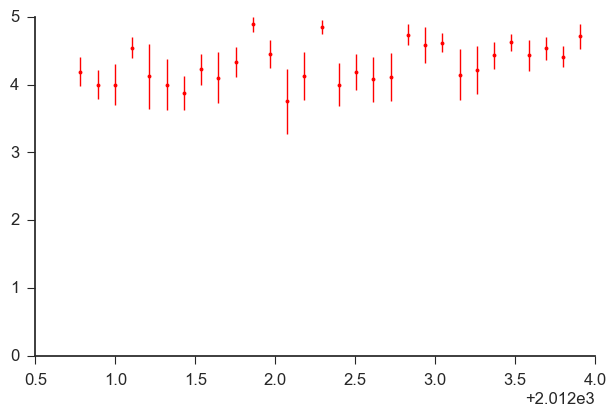

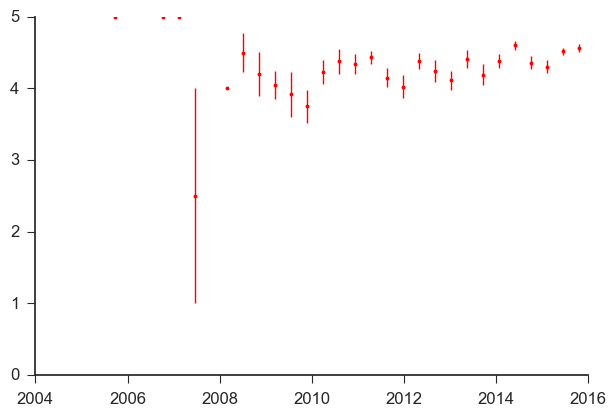

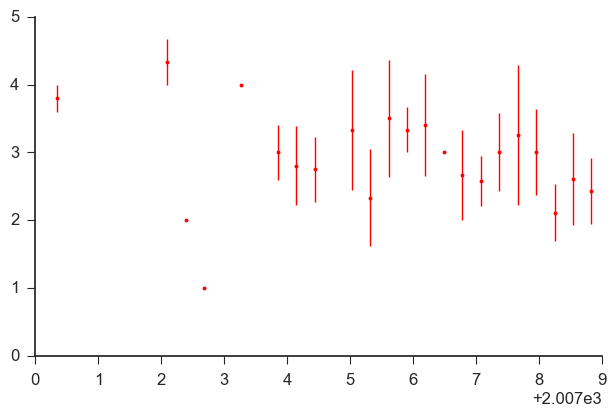

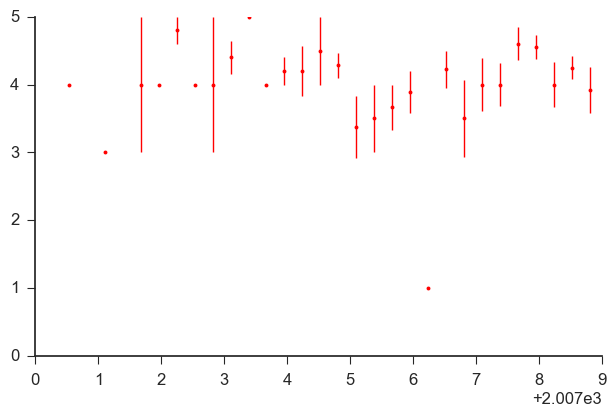

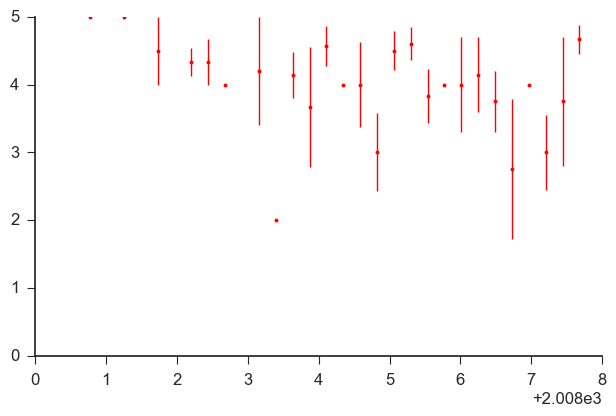

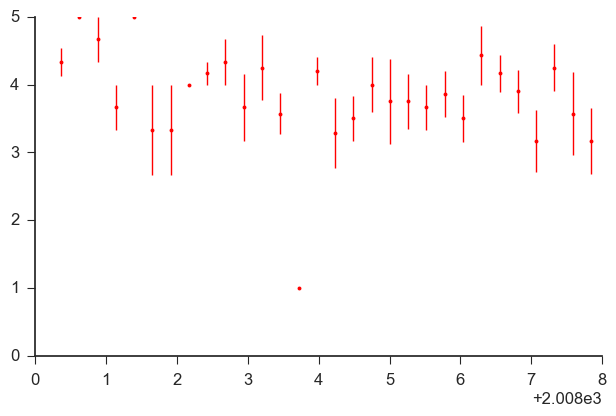

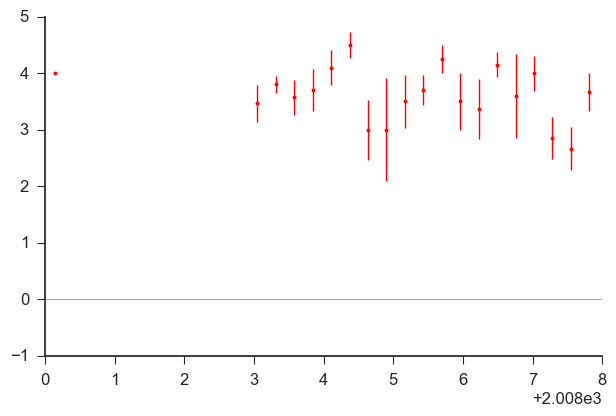

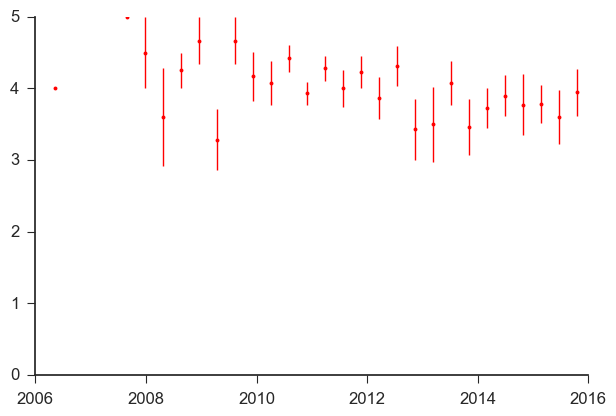

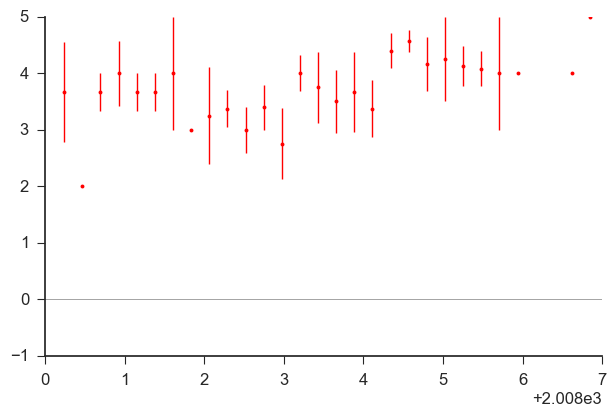

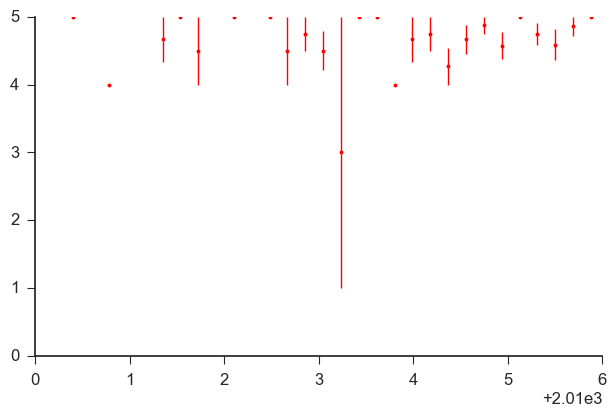

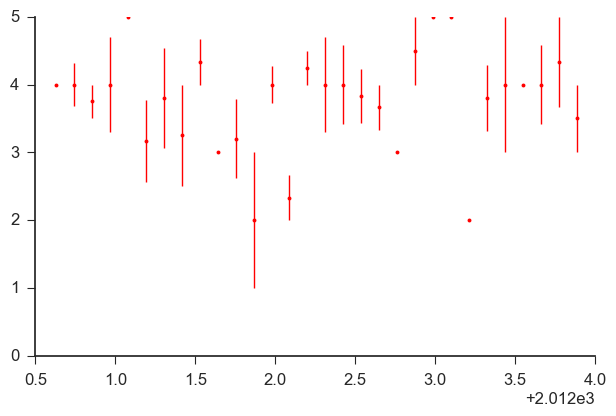

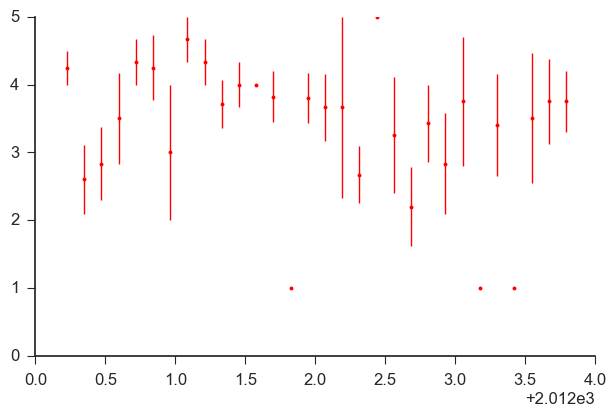

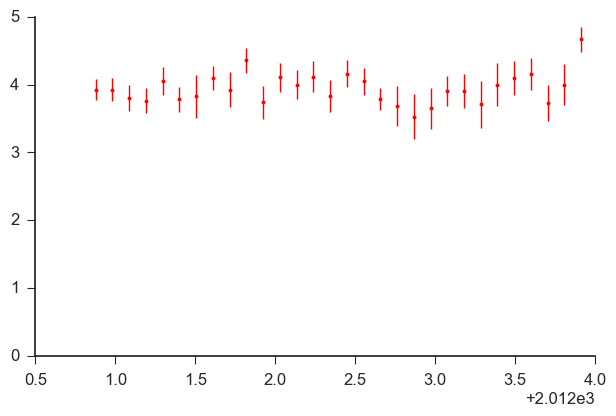

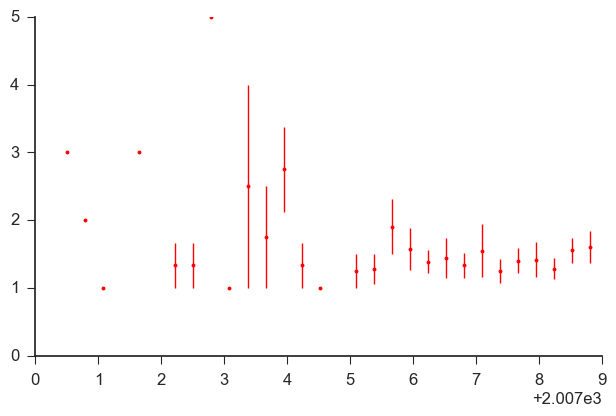

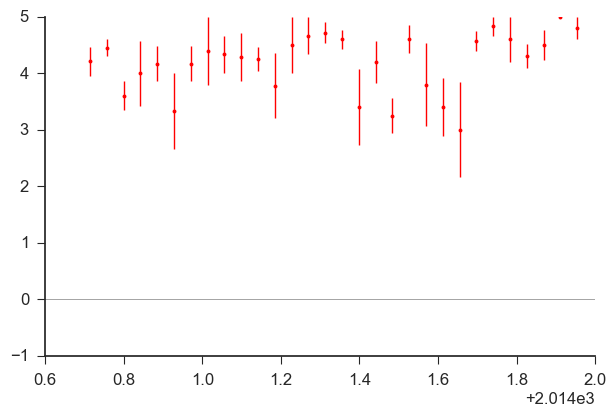

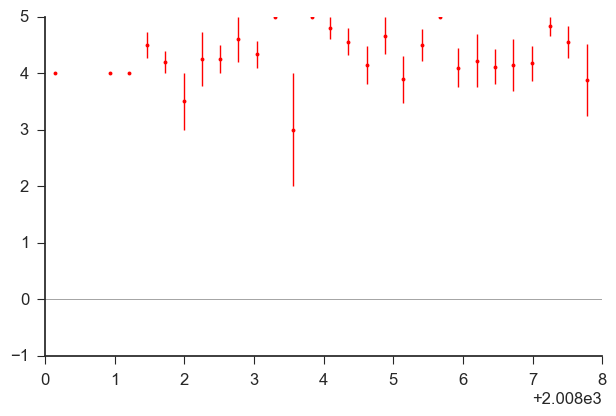

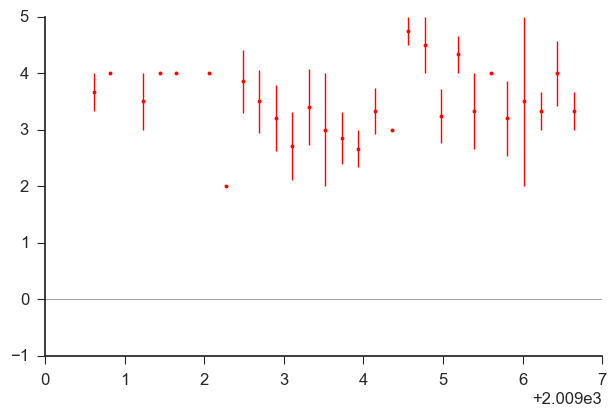

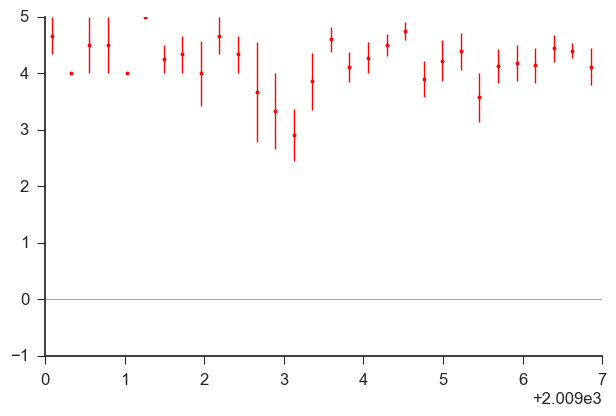

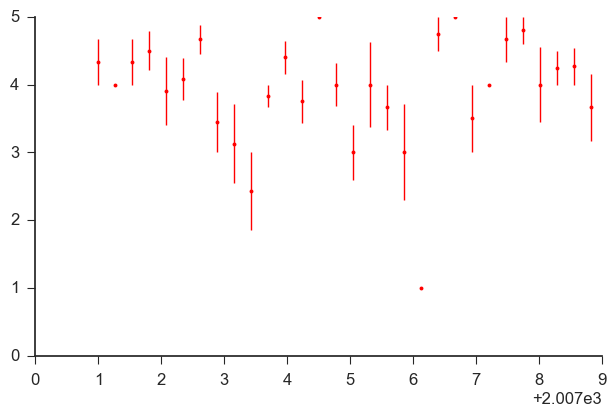

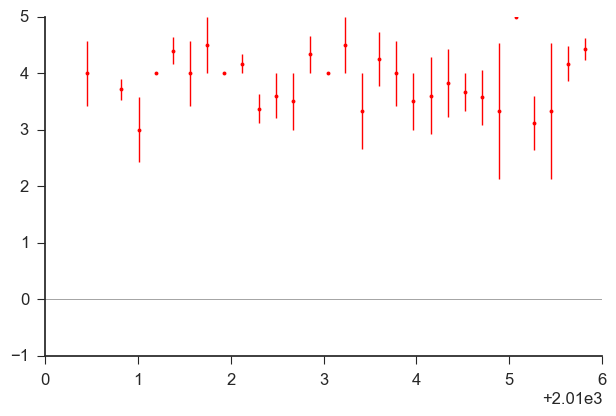

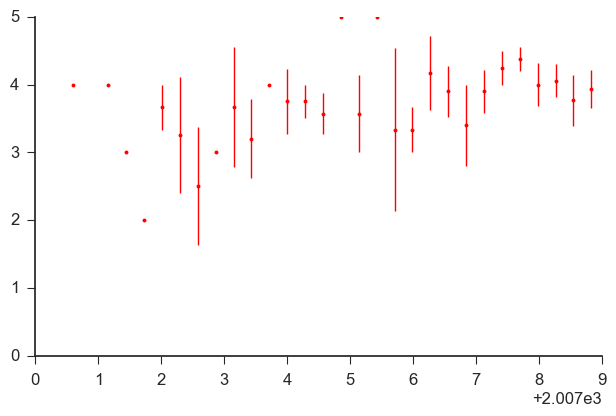

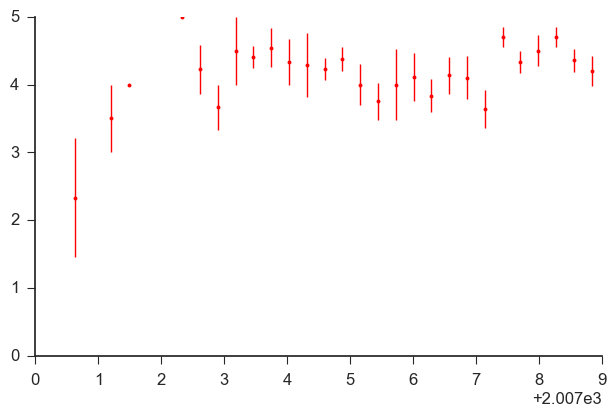

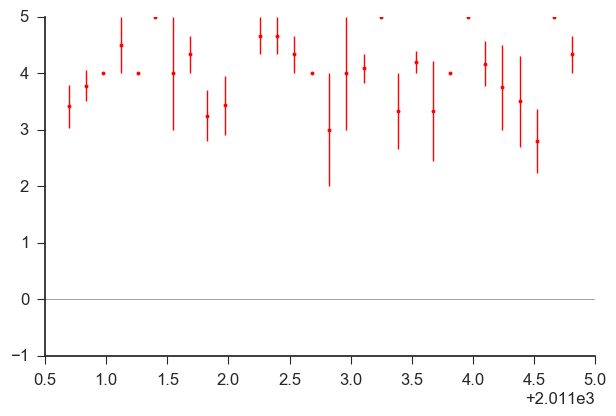

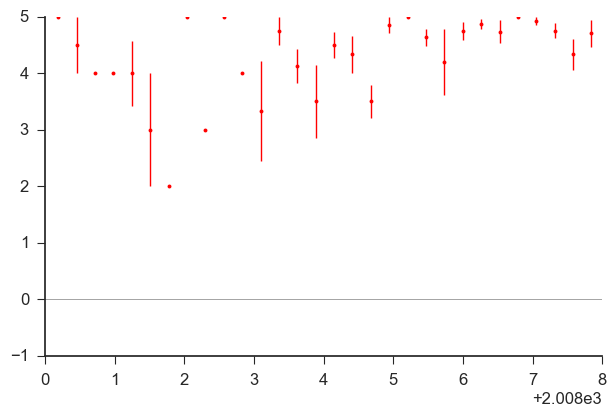

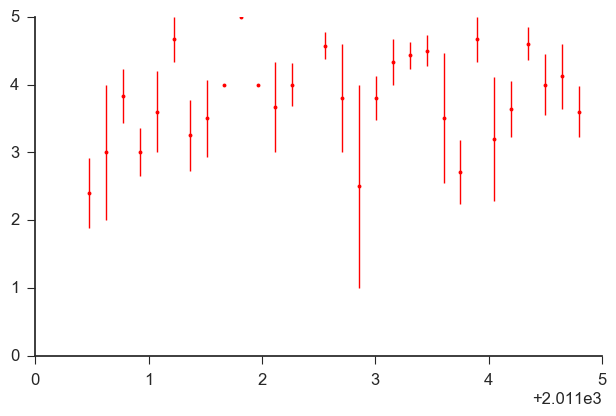

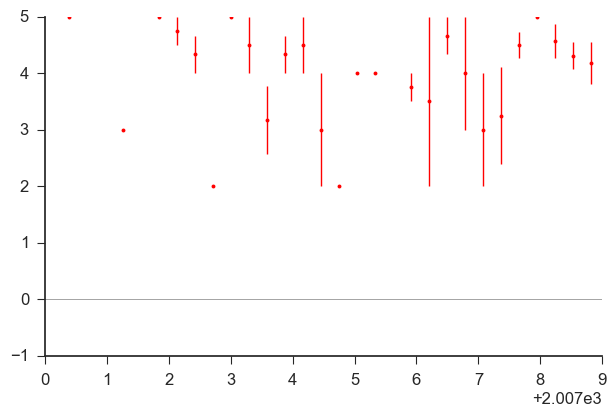

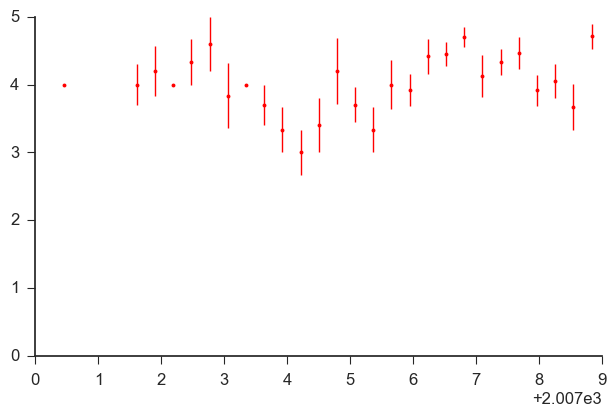

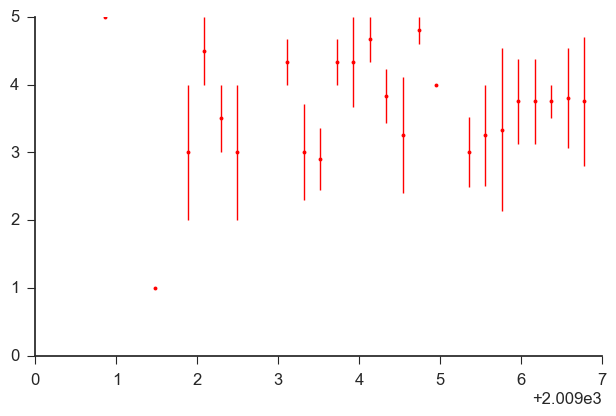

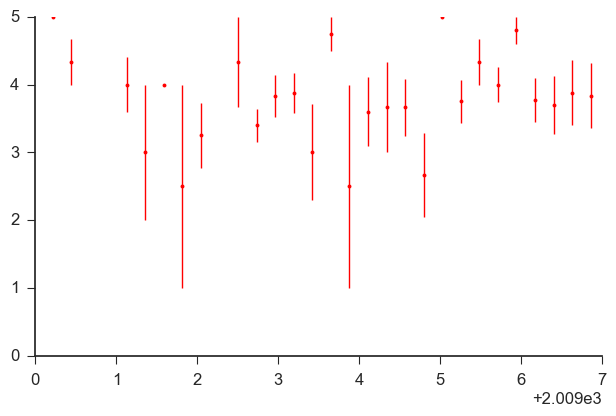

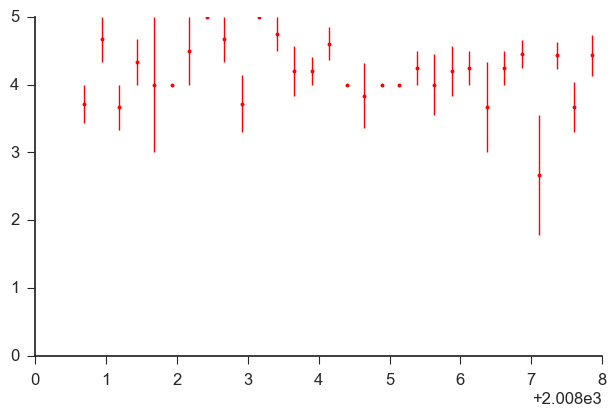

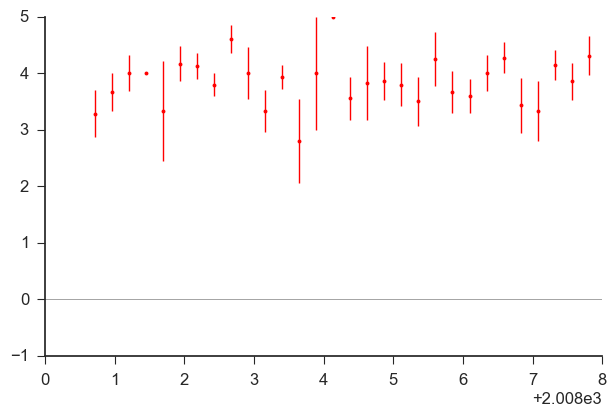

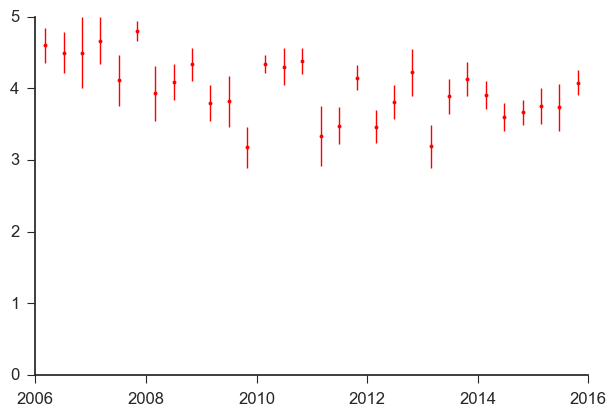

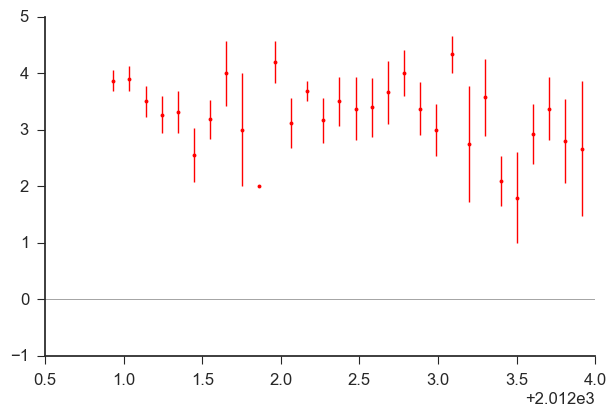

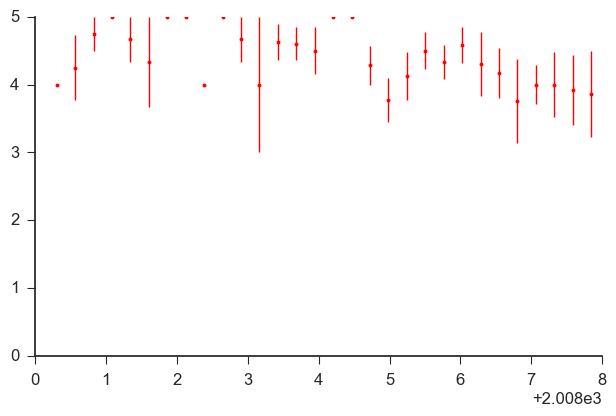

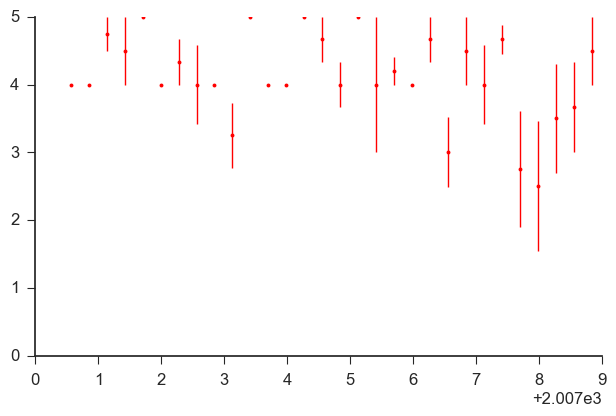

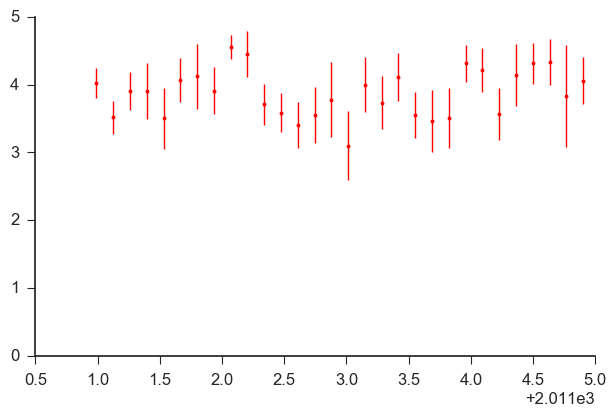

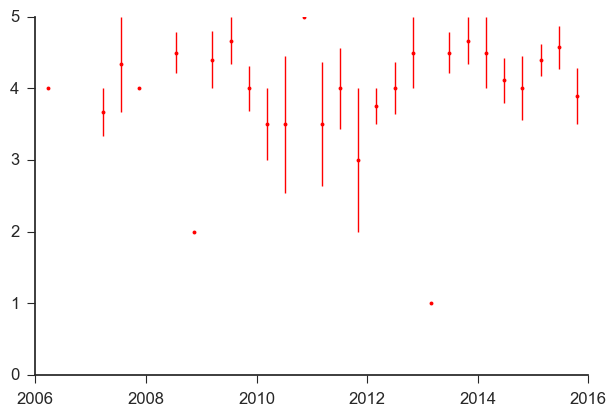

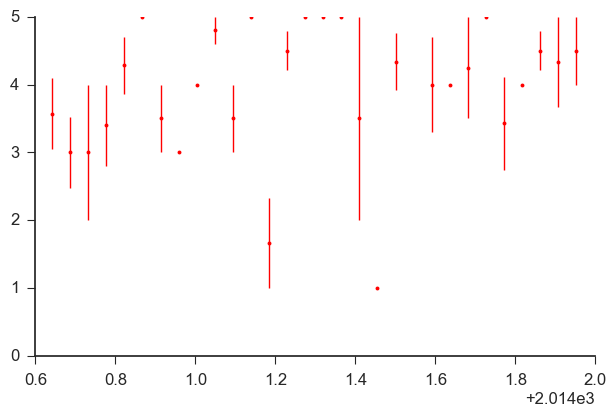

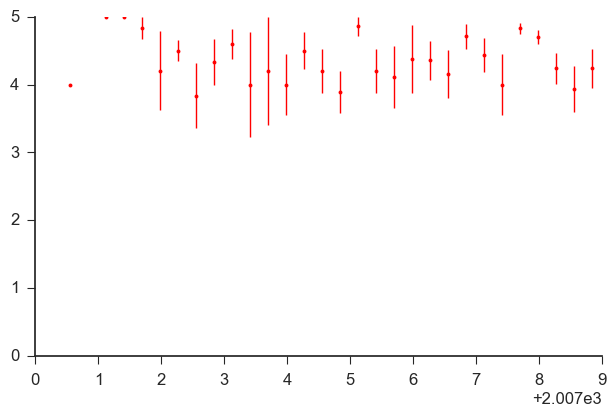

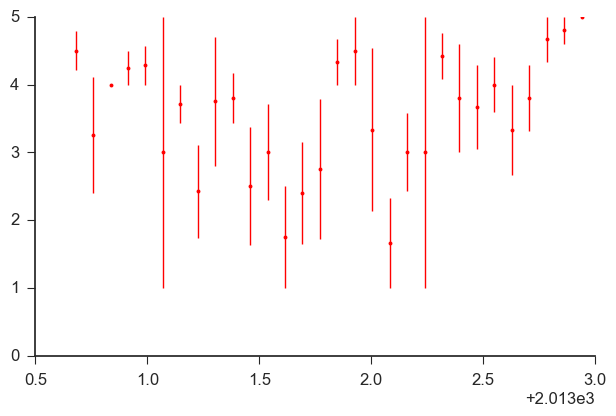

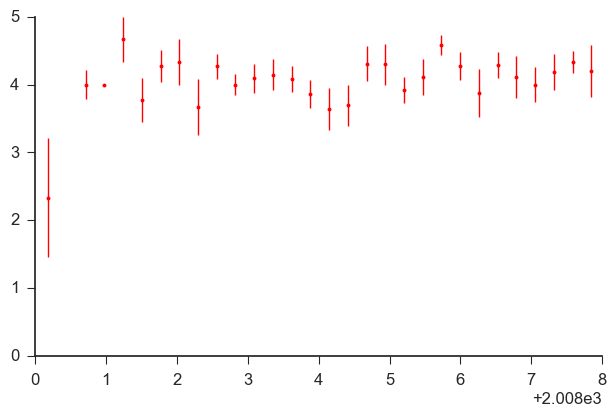

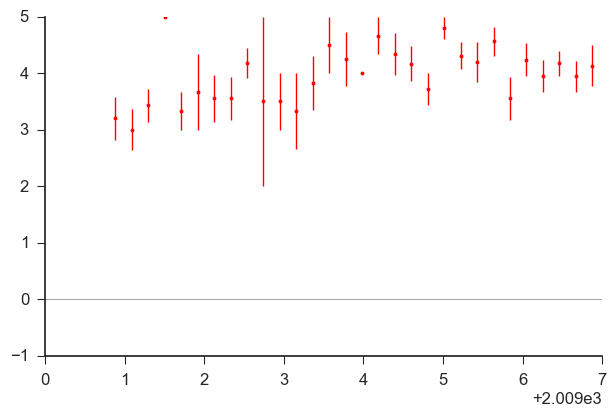

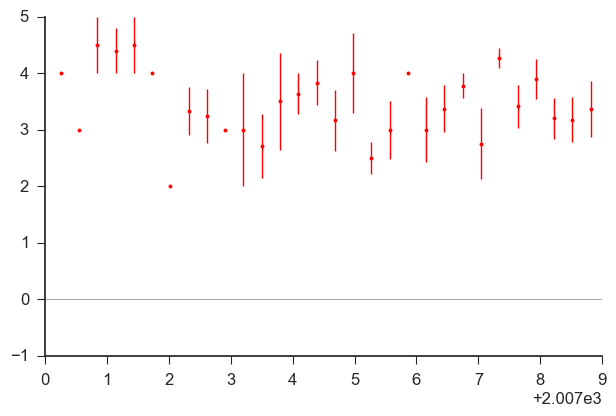

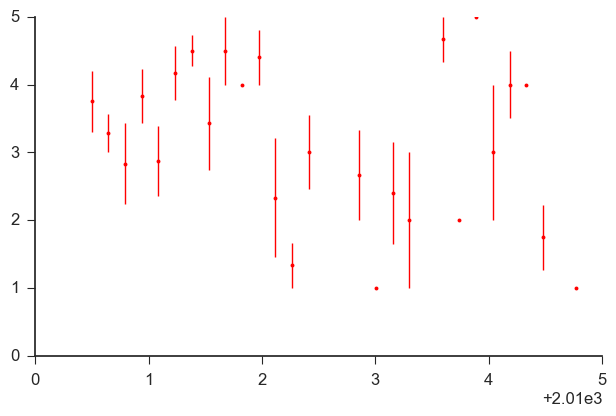

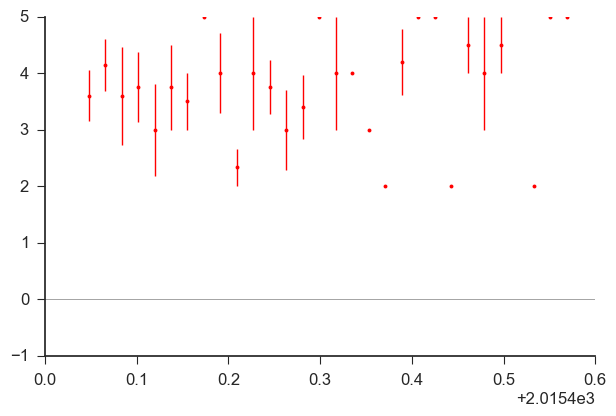

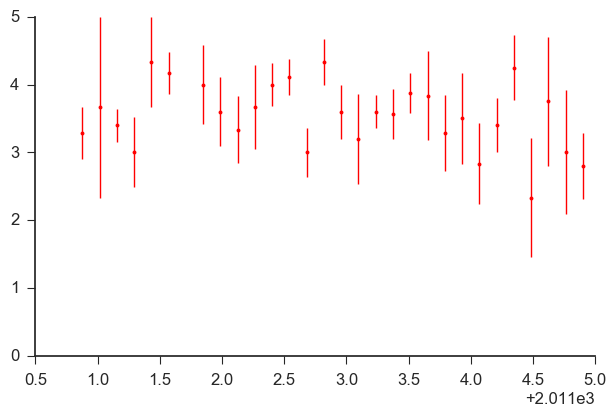

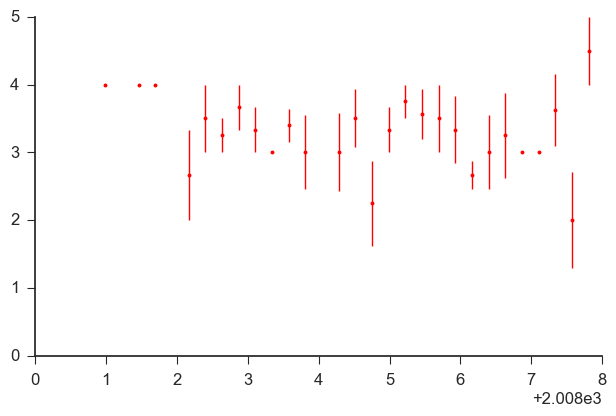

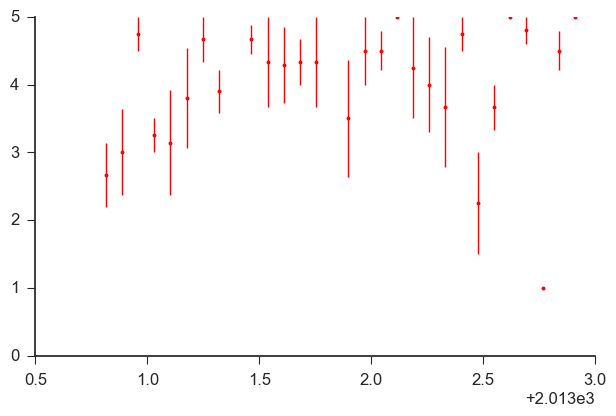

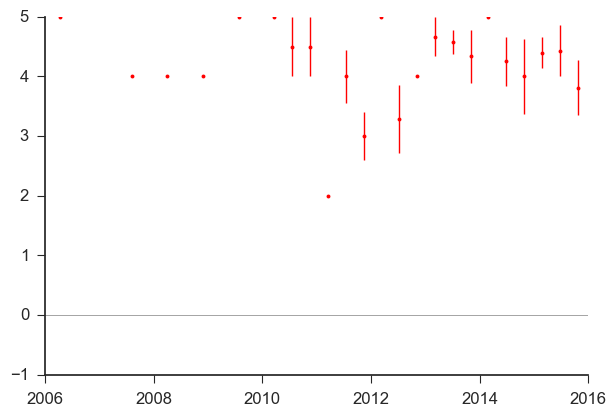

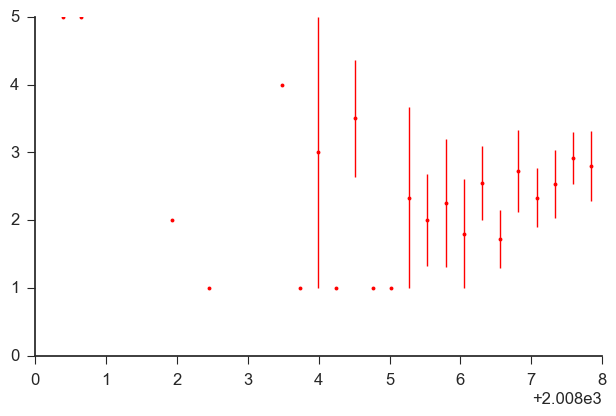

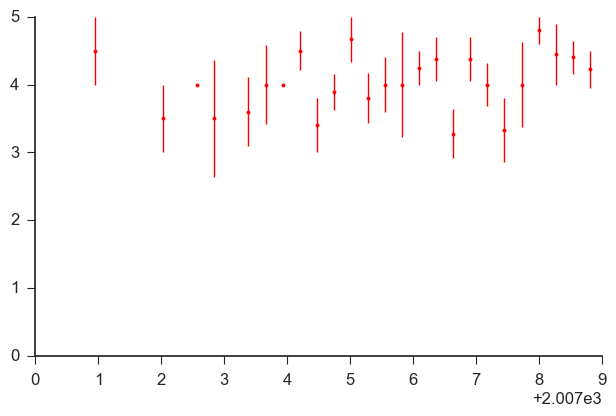

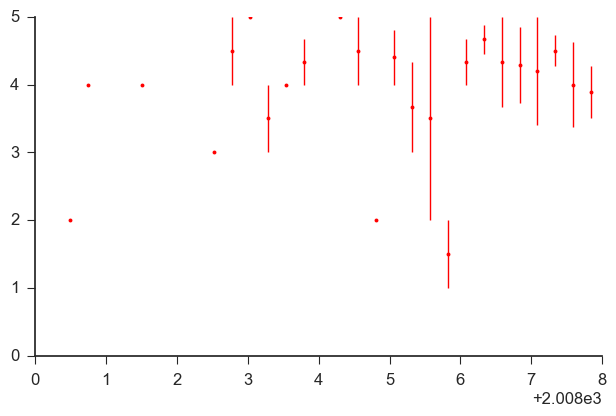

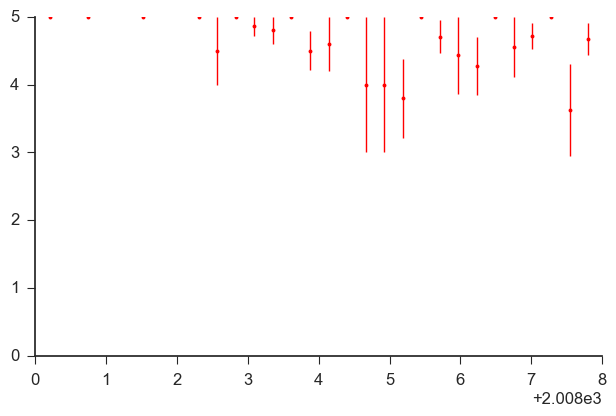

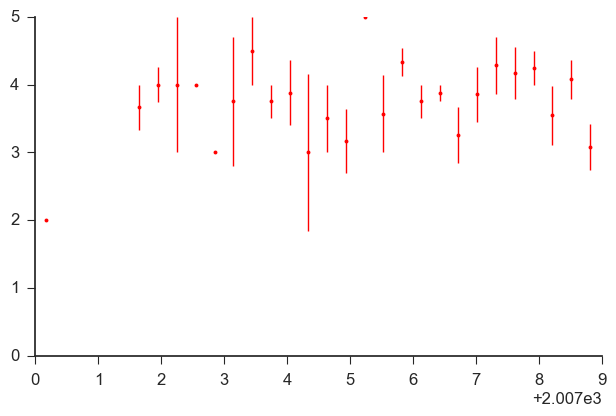

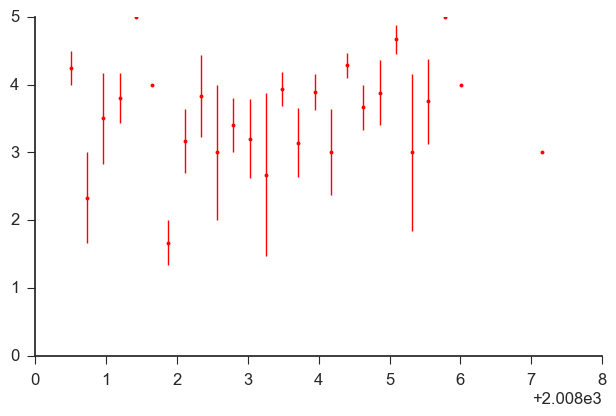

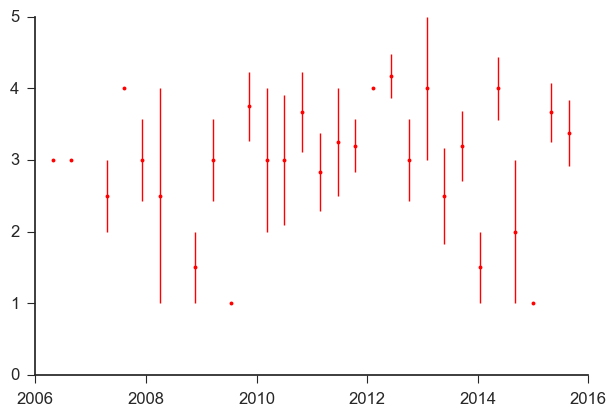

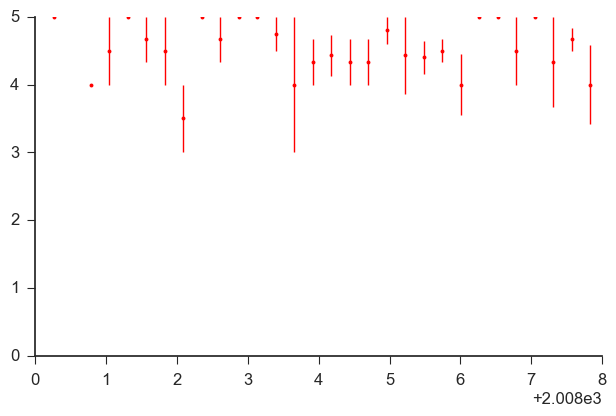

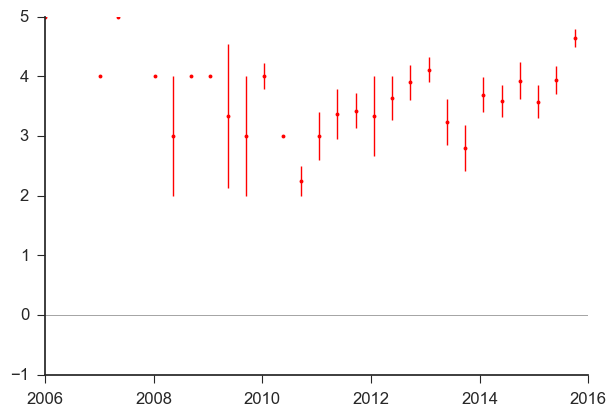

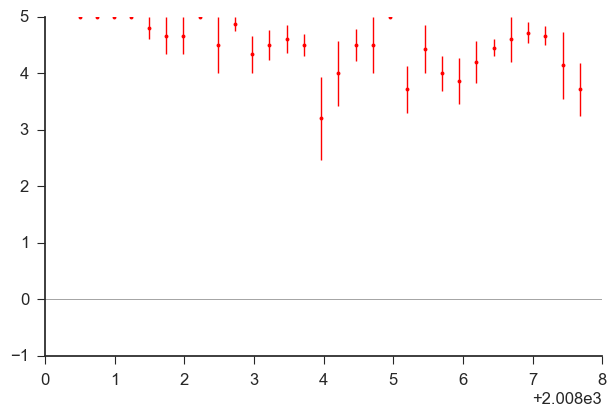

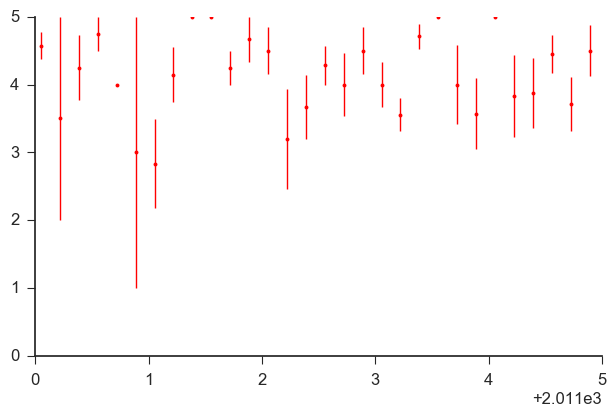

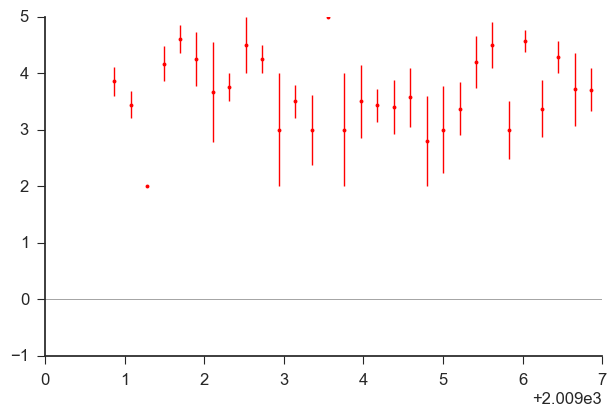

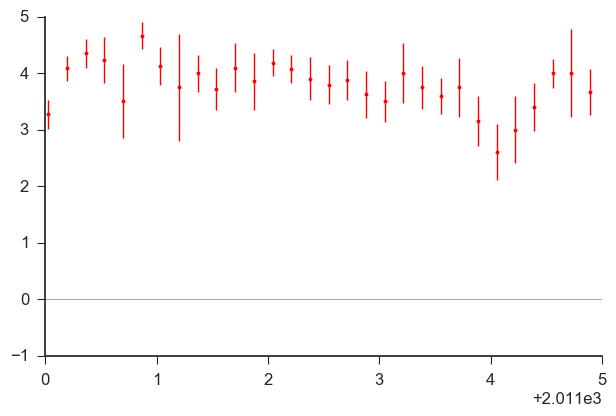

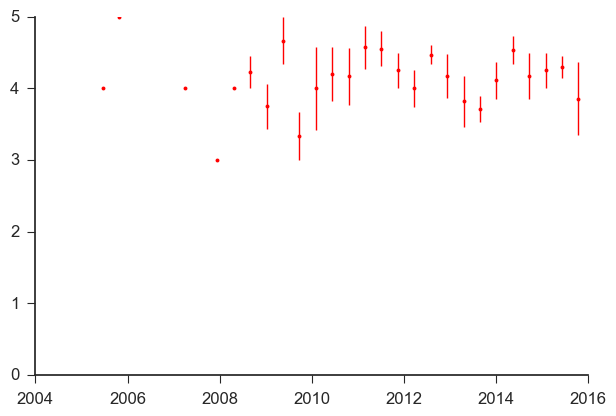

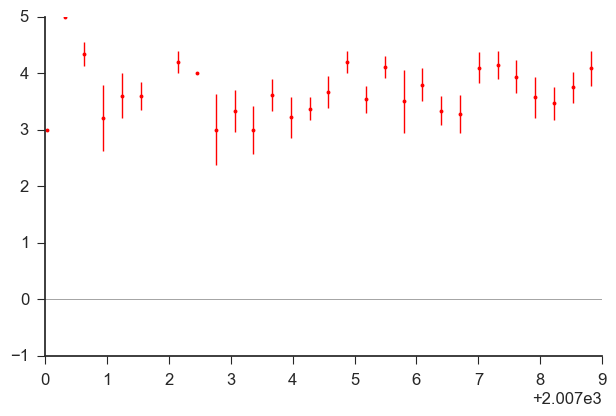

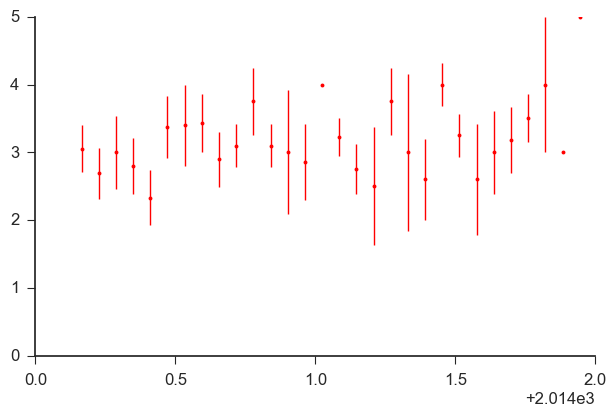

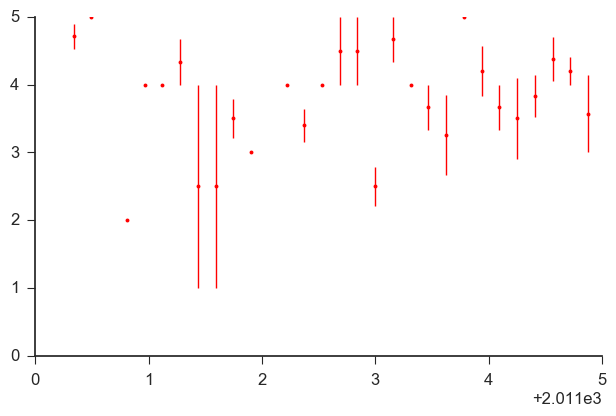

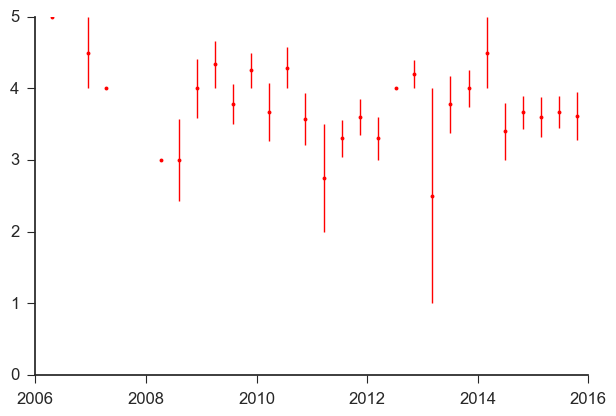

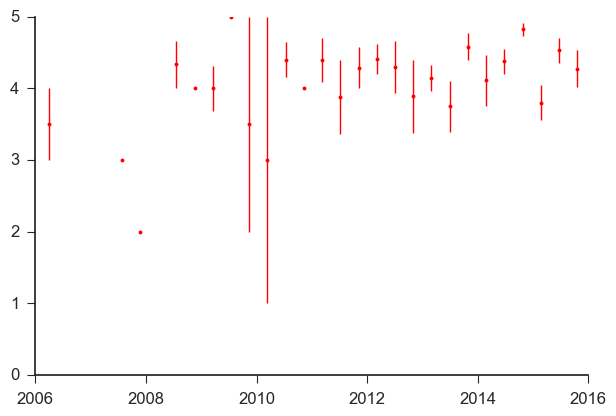

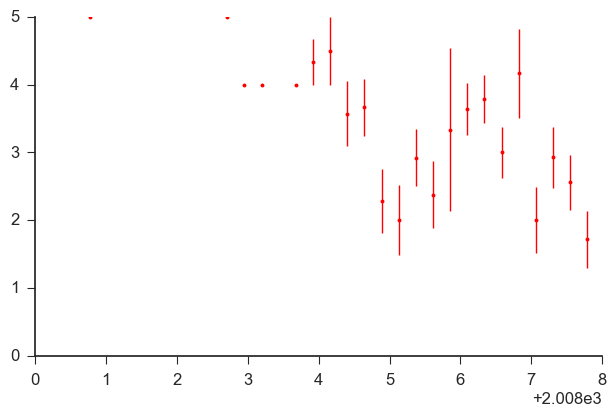

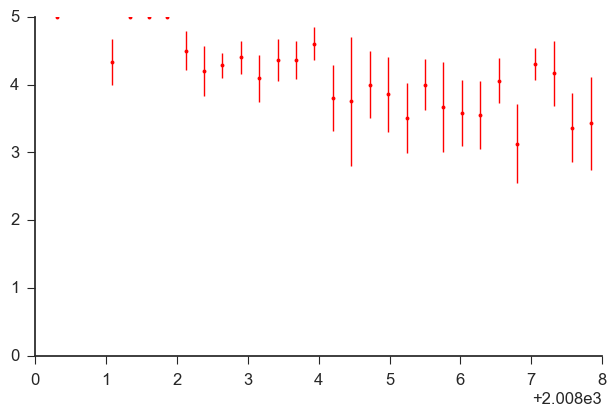

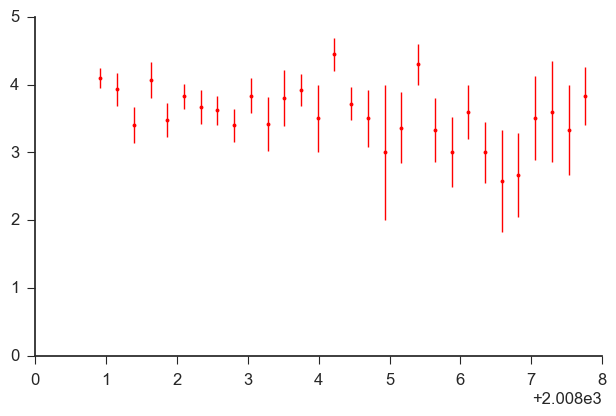

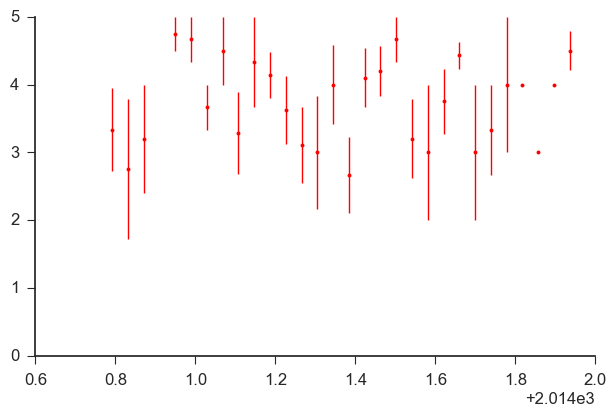

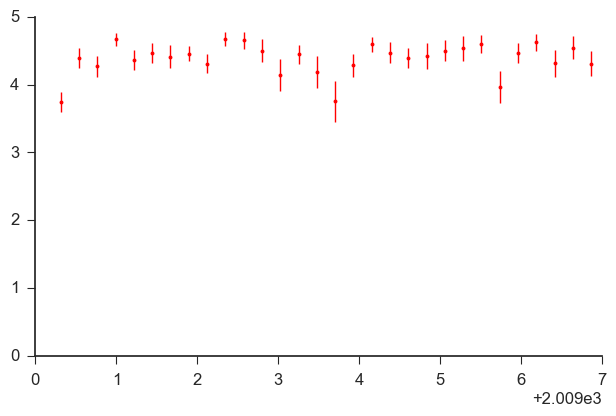

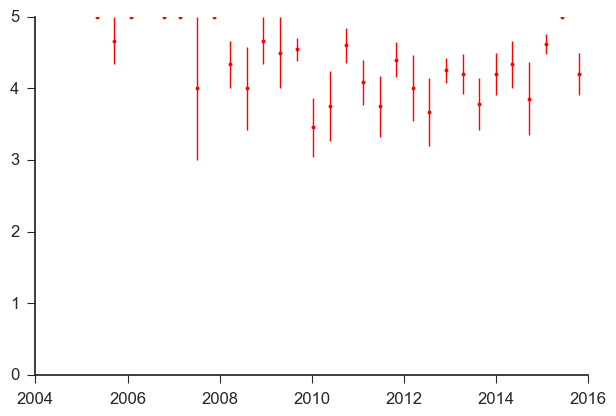

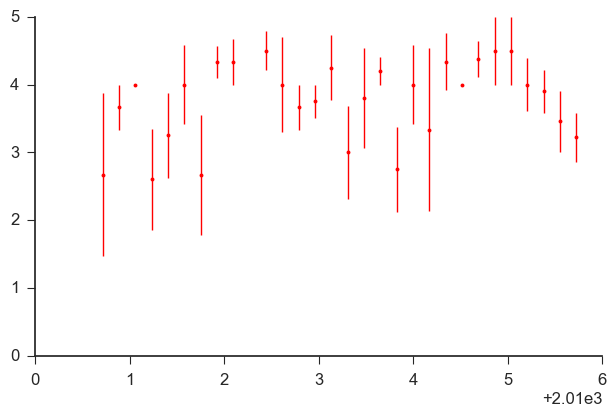

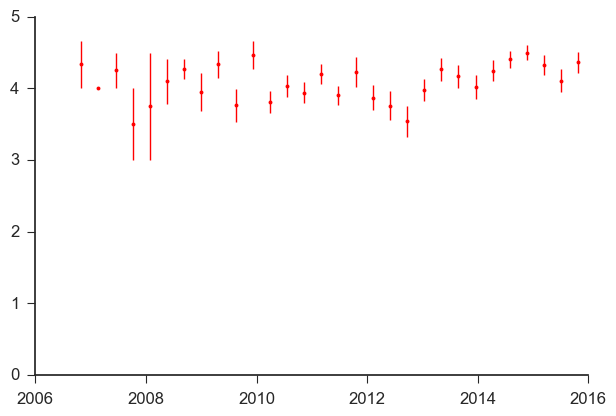

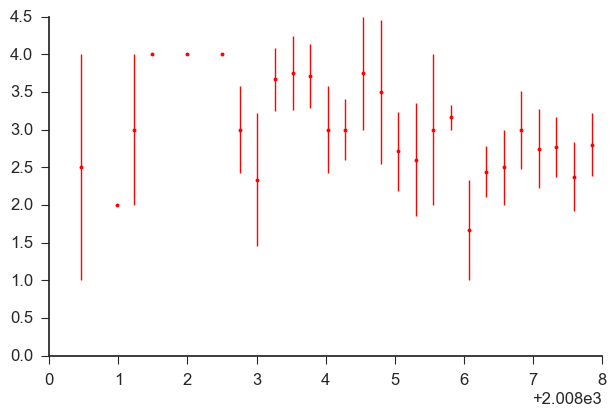

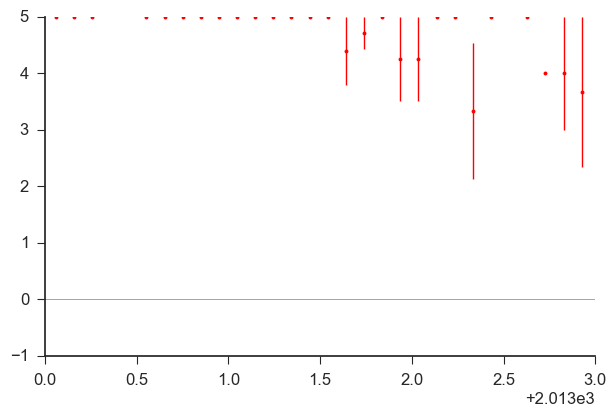

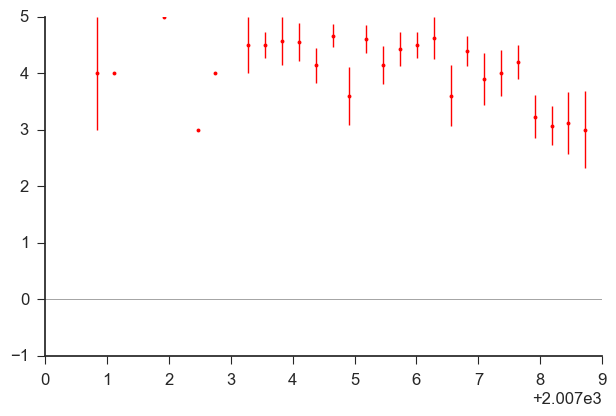

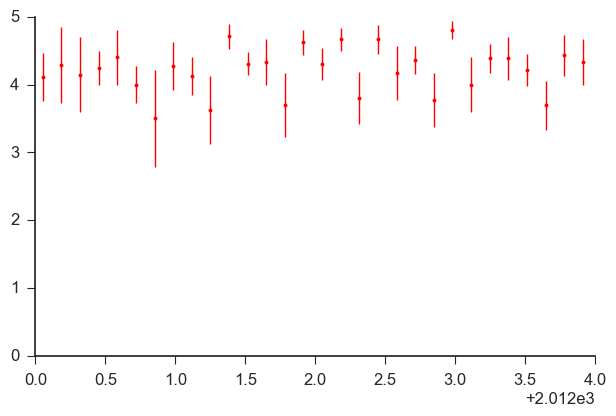

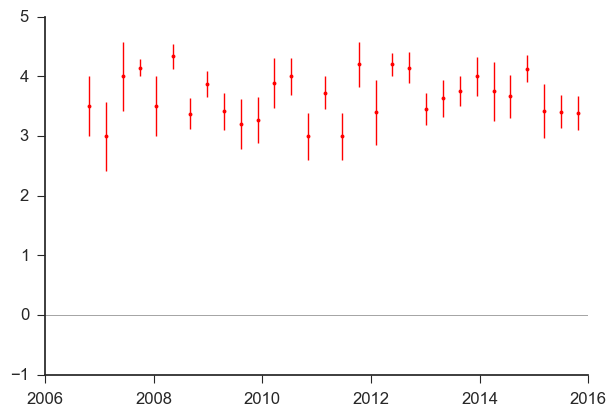

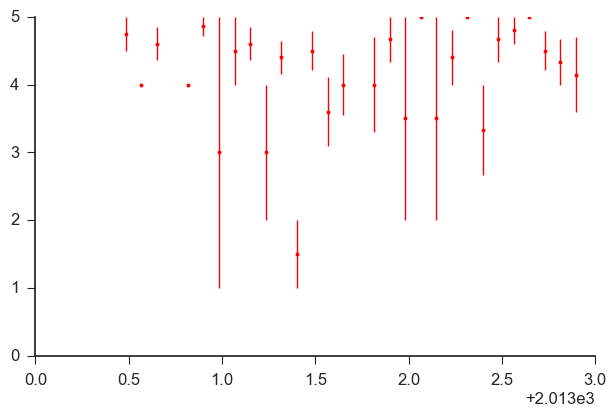

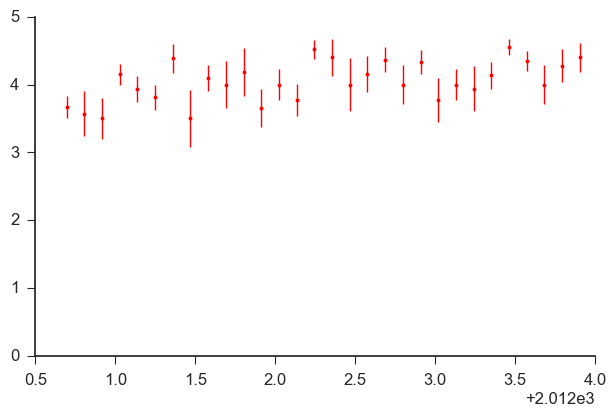

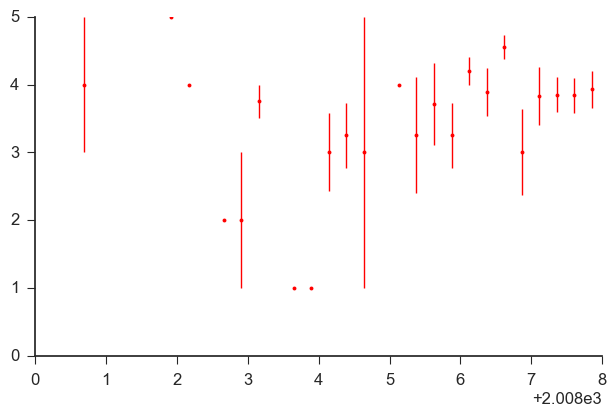

In [220]:
# plot a single/section of restaurant review trends, using Weighted Least Squares
# fill in values to fit_params

for ids in np.unique(d['B']['business_id'])[0:200]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    print ("Number of reviews: " + str(len(r)))
    
    df , _ , _ = ResExam(r['year'], r['stars'], 30)
    df = df.dropna() #drop missing bins from the dataset
    df = df[df['sem'] != 0.0] #drop bins with sem of 0 (only one observation).
    wls = sm.WLS(df['mean'], sm.add_constant(df['x']), 1.0/df['sem']).fit()
 
    fit_params['business_id'].append(ids)
    fit_params['slope'].append(wls.params['x'])
    fit_params['p_value'].append(wls.pvalues['x'])

    plt.plot(df['x'], wls.predict(sm.add_constant(df['x'])))
    plt.xlim(2006,2016)
    plt.ylim(0,5)
    
    plt.title('Linear Regression Plot for: ' + d['B']['name'][d['B']['business_id'] == ids])
    sns.despine()

In [221]:
fit_params = pd.DataFrame(fit_params)
print (fit_params)

                business_id   p_value     slope
0    --UE_y6auTgq3FXlvUMkbw  0.644816 -0.030980
1    --pOlFxITWnhzc7SHSIP0A  0.274876  0.114705
2    -1ERbsOf9XOC9wGbZYFr7g  0.053776  0.528147
3    -1bOb2izeJBZjHC7NWxiPA  0.000829  0.201989
4    -3WVw1TNQbPBzaKCaQQ1AQ  0.130345  0.051741
5    -3xbryp44xhpN4BohxXDdQ  0.025396  0.104414
6    -4A5xmN21zi_TXnUESauUQ  0.593968  0.011970
7    -584fn2GxYe9sLsgN2WeQA  0.304705 -0.039265
8    -6j-KVPPX2xKjCruNO2HnQ  0.647006  0.152407
9    -6n29ZcBHteJ9eEexoRQ7g  0.248259 -0.048788
10   -9pVS__IliMA2aNEYzrQrg  0.943819 -0.006646
11   -AAig9FG0s8gYE4f8GfowQ  0.147306 -0.035525
12   -ERMB7X_XZvr-XPK32ii4g  0.352680  0.304461
13   -EctXOb3B7T177jGYUhjVA  0.131686 -0.057927
14   -GZsHVDlI6wvLsgD1Yaj0g  0.067717 -0.062751
15   -JL0CWSLkkzFHZXlctnf8A  0.013711  0.173609
16   -KSjEAnm5w8TBdRVLVwi9Q  0.170360  0.171376
17   -LHHCgIUZy49sUU4j03T2w  0.799831  0.007984
18   -MgFDby-okrbKLBc-SYWdw  0.699542  0.021003
19   -Mh44q324VW8mpxIdH_HPw  0.995715  0

Number of reviews112
Number of reviews156
Number of reviews163
Number of reviews107
Number of reviews292
Number of reviews202
Number of reviews564
Number of reviews241
Number of reviews96
Number of reviews155
Number of reviews134
Number of reviews395
Number of reviews143
Number of reviews293


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Number of reviews271
Number of reviews109
Number of reviews117
Number of reviews217
Number of reviews190
Number of reviews198
Number of reviews153
Number of reviews126
Number of reviews222
Number of reviews161
Number of reviews129
Number of reviews159
Number of reviews144
Number of reviews263
Number of reviews290
Number of reviews102
Number of reviews170
Number of reviews183
Number of reviews210
Number of reviews358
Number of reviews102
Number of reviews109
Number of reviews119
Number of reviews114
Number of reviews122
Number of reviews234
Number of reviews857
Number of reviews103
Number of reviews443
Number of reviews106
Number of reviews160
Number of reviews134
Number of reviews137
Number of reviews250
Number of reviews111
Number of reviews368
Number of reviews133
Number of reviews114
Number of reviews140
Number of reviews97
Number of reviews305
Number of reviews161
Number of reviews127
Number of reviews131
Number of reviews141
Number of reviews150
Number of reviews96
Number of revie

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


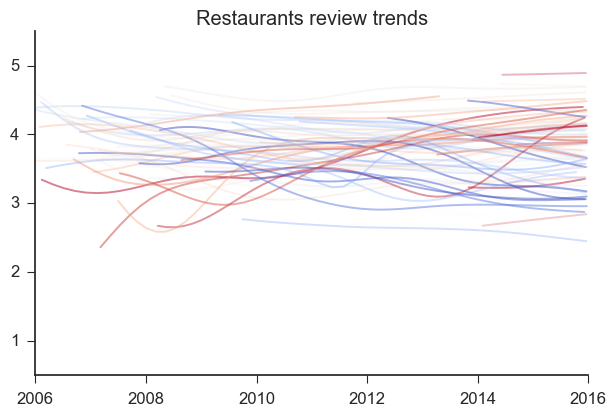

In [222]:
norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
cmap = cm.coolwarm

m = cm.ScalarMappable(norm=norm, cmap=cmap)

for ids in np.unique(d['B']['business_id'])[0:100]: #for the unique business IDs 
    r = d['R'][d['R']['business_id'] == ids]
    print ("Number of reviews" + str(len(r)))
    gm = RollingGaussianMean(r, 'year', 'stars', np.linspace(min(r['year']),max(r['year']), 50), 1)
    plt.title('Restaurants review trends')
    plt.ylim(0.5, 5.5)
    plt.xlim(2006,2016)
    color_values = m.to_rgba(fit_params['slope'][fit_params['business_id'] == ids])[0][0:3]
    alpha_p = (1-fit_params['p_value'][fit_params['business_id'] == ids])/2
    plt.plot(gm['x'], gm['y'], c = color_values, alpha = alpha_p)
    sns.despine()
    

# Rent Vs Dollar Sign


In [6]:
zhvi = pd.read_csv('Normalized_Neighborhood_Zri.csv')
zri = zhvi.drop(['Unnamed: 0', 'time'], axis = 1)
zri.columns = pd.to_numeric(pd.Series(zri.columns))
zri['time'] = zhvi['time']
cor_hoods = np.intersect1d(np.unique(d['N']['z_hood']), zri.dropna(axis=1).columns[:-1]) # the -1 needs to be added!!

In [7]:
zri = zri[zri['time']<= 2016.0]

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


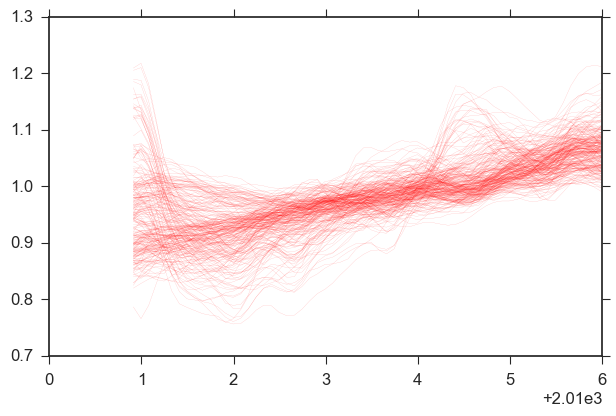

In [8]:
for col in cor_hoods:
    plt.plot(zri['time'], zri[col], c = 'r', lw = 0.1, alpha = 0.5)
plt.show()
sns.despine()

In [9]:
def MultipleWLS(df, y_cols, x_col, id_name, name, fdr = 0.1):
    
    fit_params = defaultdict(list)

    for col in y_cols: #for the unique business IDs 
        
        wls = sm.WLS(df[col], sm.add_constant(df[x_col])).fit()
    
        fit_params[id_name].append(col)
        fit_params[name + '_slope'].append(wls.params[x_col])
        fit_params[name + '_p_value'].append(wls.pvalues[x_col])
        fit_params[name + '_slope_err'].append(wls.bse[x_col])
        fit_params[name + '_mean'].append(np.mean(df[col]))
    
    fit_params = pd.DataFrame(fit_params)

    fit_params[name + '_c_hyp'], fit_params[name + '_c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(fit_params[name + '_p_value'],\
                                                  method = 'fdr_bh', alpha = fdr)
    
    return fit_params
def SelectMultipleWLS(df, y_col, x_col, id_list, id_name, name, fdr = 0.1):
    
    fit_params = defaultdict(list)

    for ids in id_list: #for the unique business IDs, i.e. for each neighborhood
        
        f = df[df[id_name] == ids][[x_col,y_col]] #create a review dataframe that is just for that neighborhood
        wls = sm.WLS(f[y_col], sm.add_constant(f[x_col])).fit()
        
        fit_params[id_name].append(ids)
        fit_params[name + '_slope'].append(wls.params[x_col])
        fit_params[name + '_p_value'].append(wls.pvalues[x_col])
        fit_params[name + '_slope_err'].append(wls.bse[x_col])
        fit_params[name + '_mean'].append(np.mean(f[y_col]))
    
    fit_params = pd.DataFrame(fit_params)

    fit_params[name + '_c_hyp'], fit_params[name + '_c_pvals'], _ , _, = statsmodels.sandbox.stats.multicomp.multipletests(fit_params[name + '_p_value'],\
                                                  method = 'fdr_bh', alpha = fdr)
        
    return fit_params

def InCategory(string_list, string):
    if string in string_list:
        out = 1
    else:
        out = 0
    return out

In [10]:
d['RB'] = pd.merge(d['R'], d['B'][['business_id', 'Price']], on = ['business_id'])
yelp_wls = SelectMultipleWLS(d['RB'], 'stars', 'year', cor_hoods, 'z_hood', 'all_yelp')

price_list = ['1.0', '2.0', '3.0', '4.0']

for price in price_list:
    d['RB'][price] = d['RB']['Price'].astype('str').apply(InCategory, args = (price,))
    d['CRB'] = d['RB'][d['RB'][price] == 1]
    yelp_wls = pd.merge(SelectMultipleWLS(d['CRB'], 'stars', 'year', np.unique(d['CRB']['z_hood']), 'z_hood', price), yelp_wls,\
                   on = 'z_hood', how = 'outer')

yelp_wls = yelp_wls.drop([col for col in yelp_wls.columns if '_pval' in col], axis = 1)
zri_wls = MultipleWLS(zri, cor_hoods, 'time', 'z_hood', 'zri') #calculate the rent wls

In [11]:
zy = pd.merge(yelp_wls, zri_wls, on = 'z_hood')

In [12]:
zy.head()

4.0_mean  4.0_p_value  4.0_slope  4.0_slope_err    z_hood 4.0_c_hyp  \
0  3.089552     0.148713  -0.179174       0.122601  111818.0     False   
1  1.826087     0.519582  -0.213246       0.325569  112345.0     False   
2  4.002283     0.441638  -0.021553       0.027986  112547.0     False   
3  4.107639     0.713772  -0.013290       0.036198  180250.0     False   
4  4.027027     0.058429  -0.133175       0.069252  210000.0     False   

   3.0_mean   3.0_p_value  3.0_slope  3.0_slope_err      ...       \
0  3.182432  7.922434e-01  -0.013807       0.052371      ...        
1  2.704918  7.214976e-02  -0.128288       0.070064      ...        
2  3.792934  9.945315e-04  -0.043677       0.013250      ...        
3  3.895785  9.963444e-02  -0.032488       0.019708      ...        
4  4.055263  1.608578e-07   0.167940       0.031450      ...        

  all_yelp_p_value  all_yelp_slope  all_yelp_slope_err  all_yelp_c_hyp  \
0     3.345848e-01        0.004650            0.004819           False   
1     6.435801e-10       -0.074606            0.012052            True   
2     4.566635e-02        0.007533            0.003769           False   
3     6.851797e-01       -0.003641            0.008981           False   
4     2.208386e-04        0.104215            0.027993            True   

   zri_mean   zri_p_value  zri_slope  zri_slope_err  zri_c_hyp   zri_c_pvals  
0  0.984530  1.271111e-20   0.017945       0.001278       True  2.322749e-20  
1  0.977009  1.786304e-12   0.017718       0.002003       True  2.607592e-12  
2  0.983826  1.117969e-10   0.016663       0.002139       True  1.534941e-10  
3  0.966387  8.099841e-40   0.056361       0.001732       True  4.034038e-39  
4  0.978451  3.273245e-15   0.051659       0.004920       True  4.978469e-15  

[5 rows x 32 columns]

In [13]:
nzy = pd.merge(d['N'], zy, on = 'z_hood')

In [14]:
min_n = 50
nnzy = nzy[nzy['n']>min_n]

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


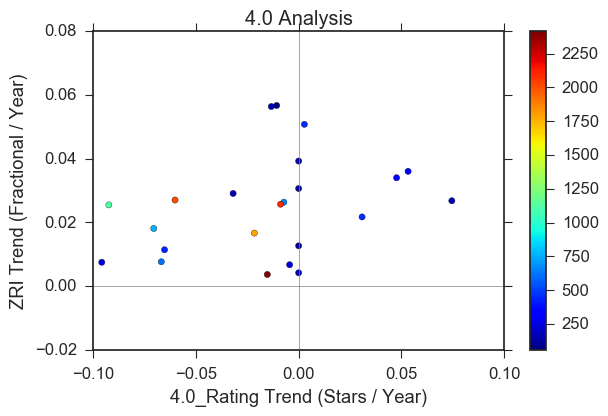

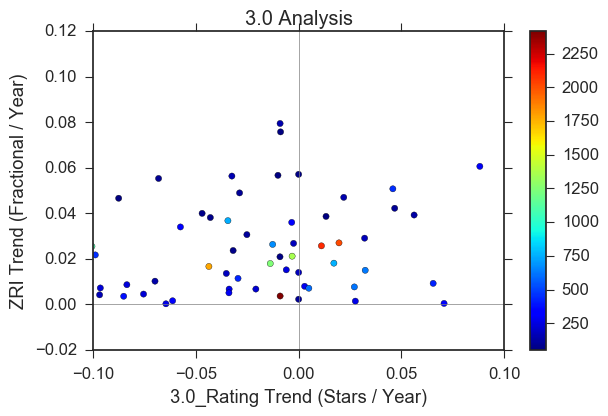

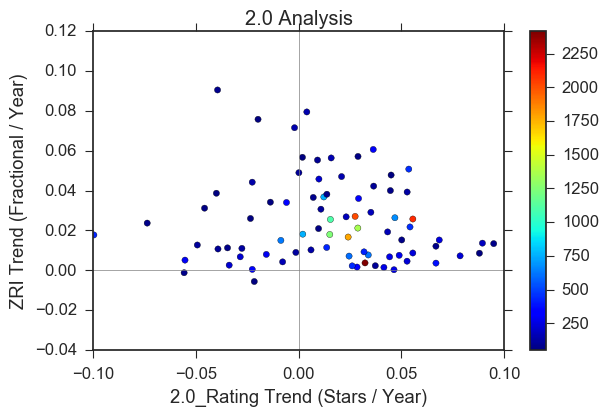

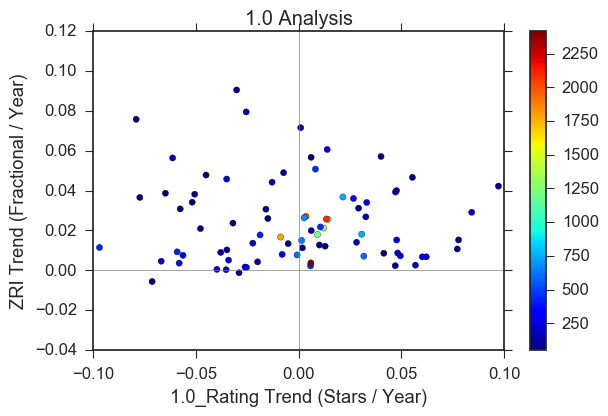

In [15]:
for price in price_list[::-1]:

    plt.figure()
    plt.scatter(nnzy[price+'_slope'],nnzy['zri_slope'], c = nnzy['n'], cmap = 'jet')
    #plt.scatter(nzy['all_yelp_slope'], nzy['zri_slope'], lw = 0.3, c = nzy['n'], cmap = 'jet')
    plt.colorbar()
    plt.axvline(0, c = 'grey', lw = 0.5)
    plt.axhline(0, c = 'grey', lw = 0.5)
    plt.xlim(-0.1, 0.1)
    plt.xlabel(price+'_Rating Trend (Stars / Year)')
    plt.ylabel('ZRI Trend (Fractional / Year)')
    plt.title(price+' Analysis')

# HUGE small neighborhood (in terms of # of restaurants) comparison

## Interesting Pattern for HUGE!


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


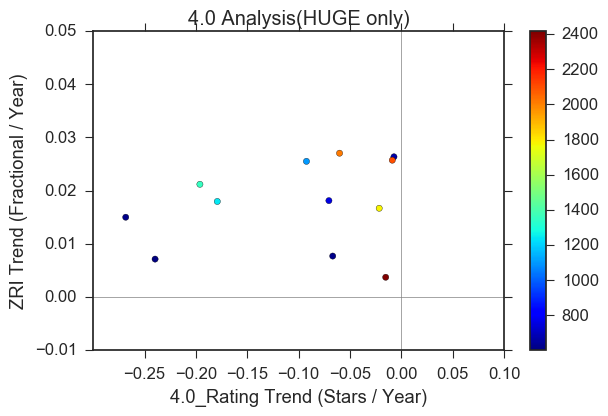

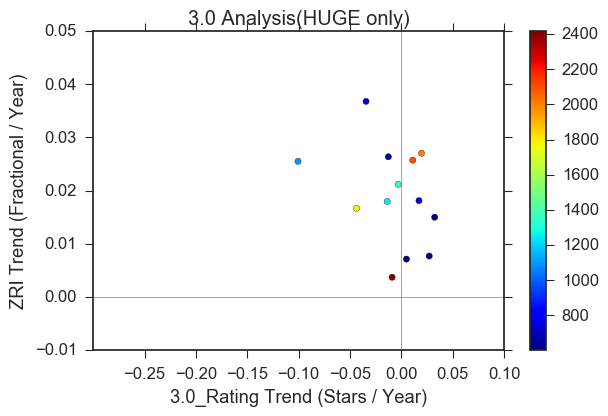

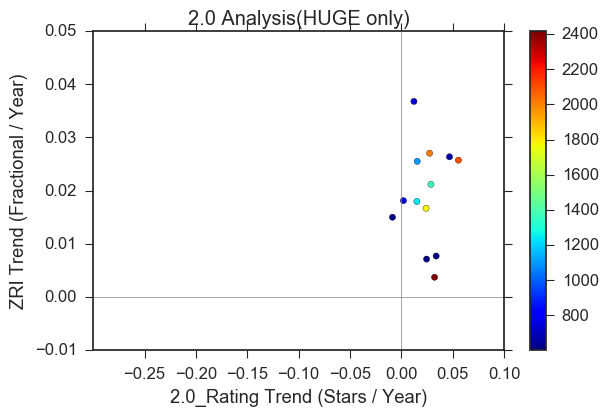

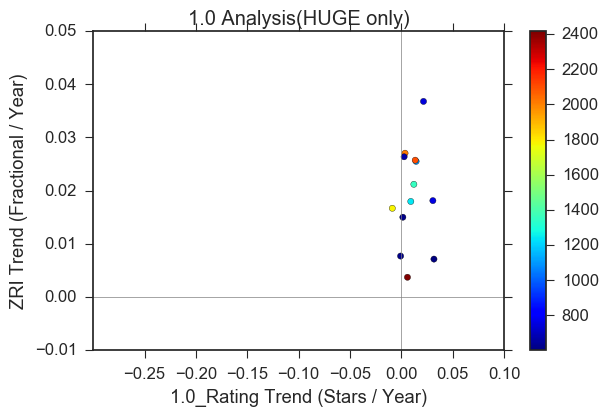

In [27]:
min_n = 500
nnzy = nzy[nzy['n']>min_n]

for price in price_list[::-1]:

    plt.figure()
    plt.scatter(nnzy[price+'_slope'],nnzy['zri_slope'], c = nnzy['n'], cmap = 'jet')
    #plt.scatter(nzy['all_yelp_slope'], nzy['zri_slope'], lw = 0.3, c = nzy['n'], cmap = 'jet')
    plt.colorbar()
    plt.axvline(0, c = 'grey', lw = 0.5)
    plt.axhline(0, c = 'grey', lw = 0.5)
    plt.xlim(-0.3, 0.1)
    plt.xlabel(price+'_Rating Trend (Stars / Year)')
    plt.ylabel('ZRI Trend (Fractional / Year)')
    plt.title(price+' Analysis(HUGE only)')

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


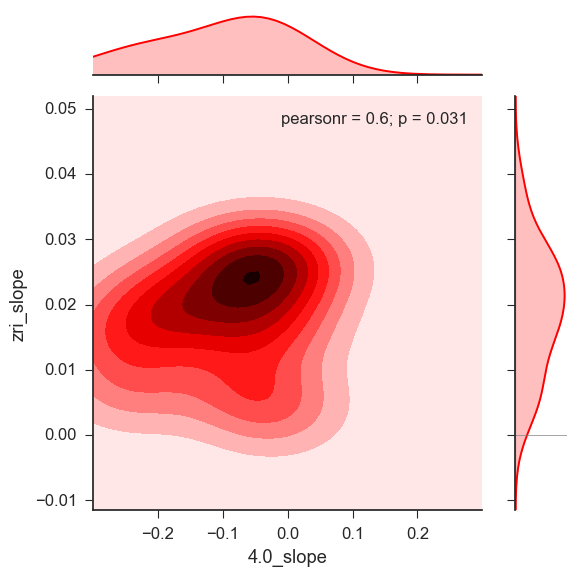

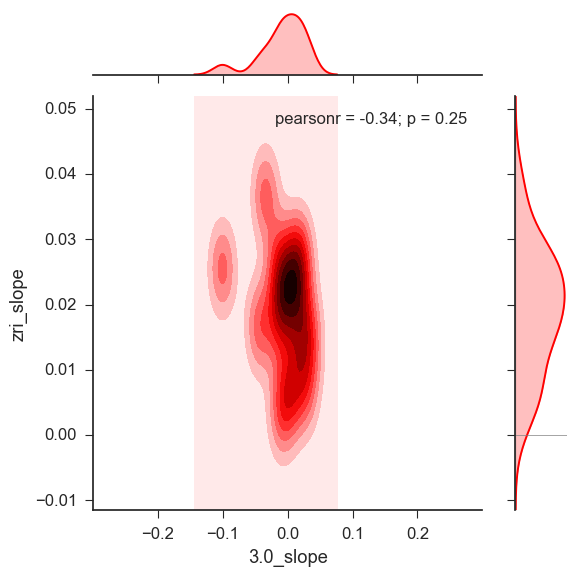

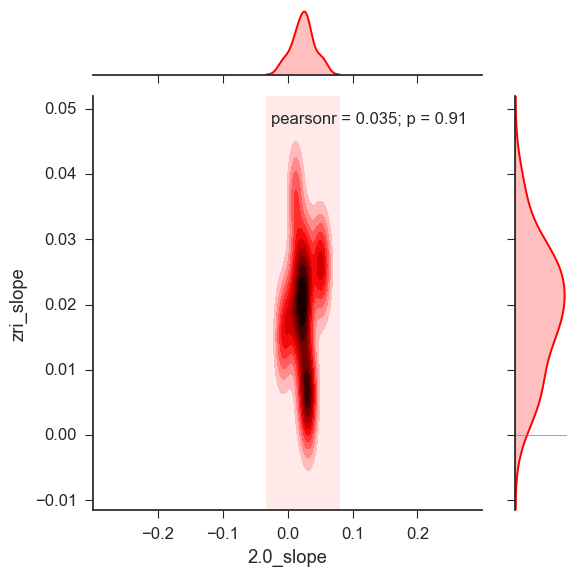

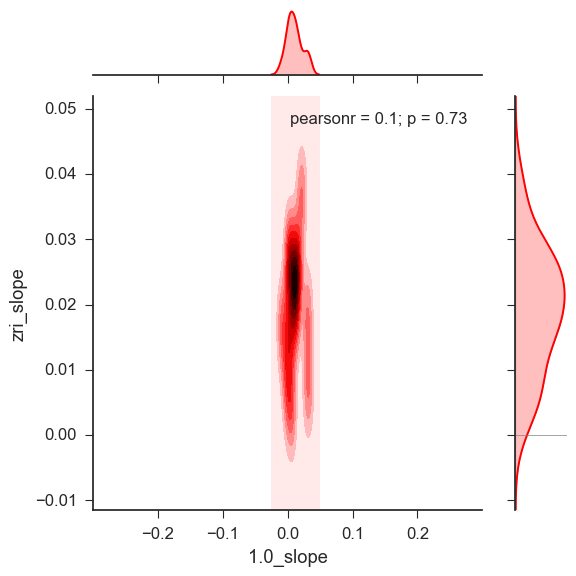

In [30]:
min_n = 500
nnzy = nzy[nzy['n']>min_n]

for price in price_list[::-1]:

    plt.figure()
    sns.jointplot(nnzy[price+'_slope'],nnzy['zri_slope'], kind = 'kde', n_levels = 10, xlim=(-0.3, 0.3), color = 'r')
    plt.axvline(0, c = 'grey', lw = 0.5)
    plt.axhline(0, c = 'grey', lw = 0.5)
    

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


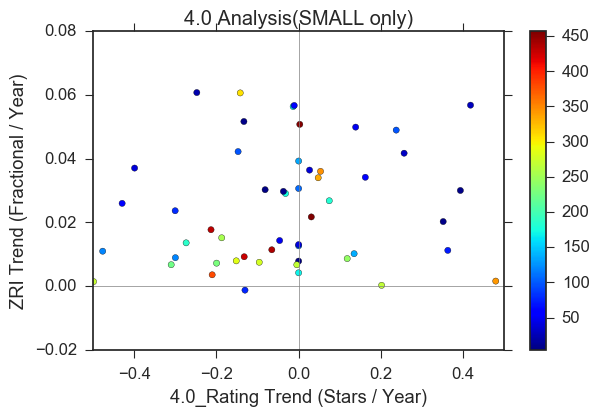

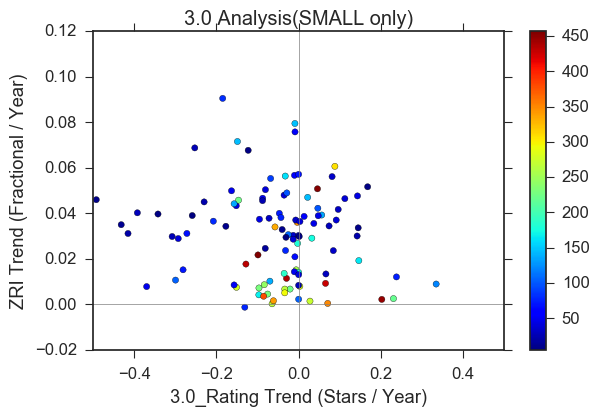

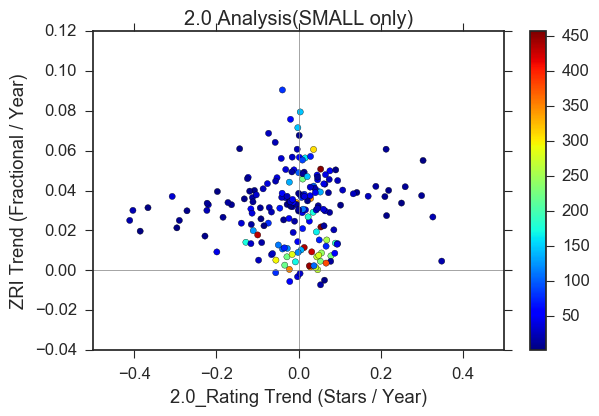

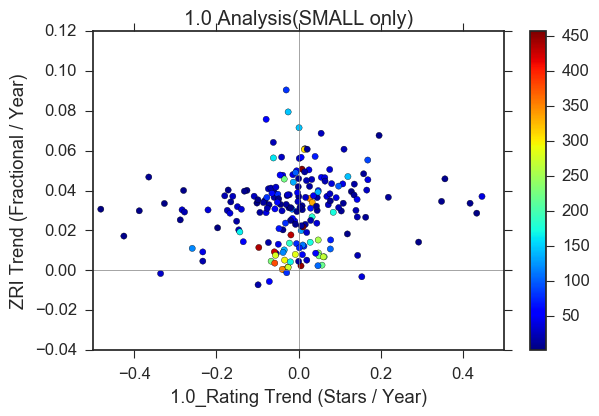

In [34]:
max_n = 500
nnzy = nzy[nzy['n']<max_n]

for price in price_list[::-1]:

    plt.figure()
    plt.scatter(nnzy[price+'_slope'],nnzy['zri_slope'], c = nnzy['n'], cmap = 'jet')
    #plt.scatter(nzy['all_yelp_slope'], nzy['zri_slope'], lw = 0.3, c = nzy['n'], cmap = 'jet')
    plt.colorbar()
    plt.axvline(0, c = 'grey', lw = 0.5)
    plt.axhline(0, c = 'grey', lw = 0.5)
    plt.xlim(-0.5, 0.5)
    plt.xlabel(price+'_Rating Trend (Stars / Year)')
    plt.ylabel('ZRI Trend (Fractional / Year)')
    plt.title(price+' Analysis(SMALL only)')

# Using neighbor hosing price as the color bar

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


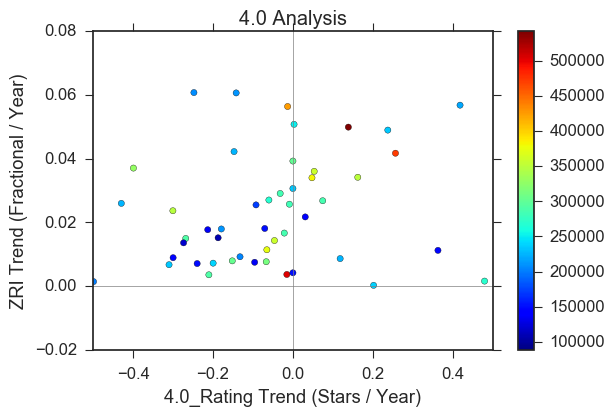

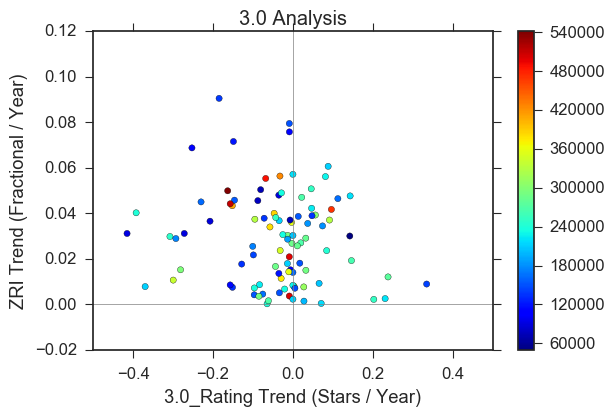

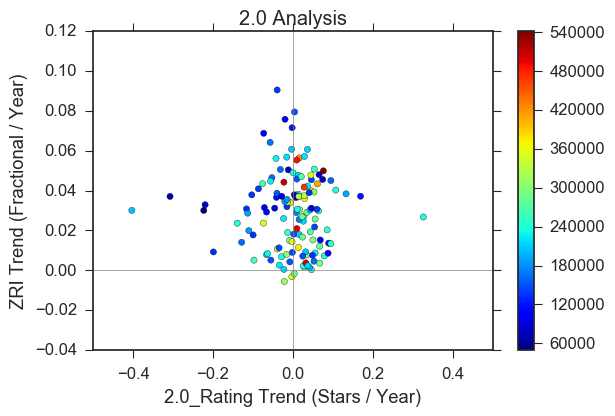

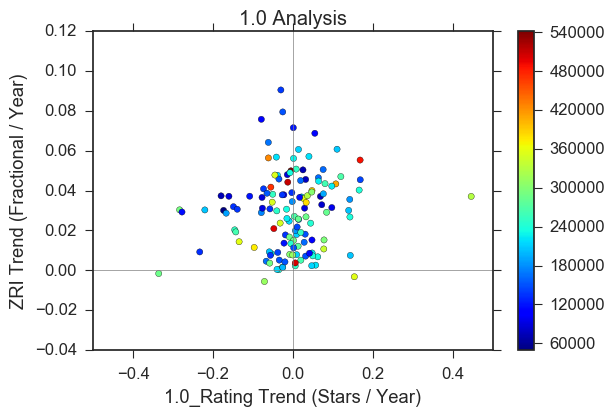

In [35]:
min_n = 20
nnzy = nzy[nzy['n']>min_n]
nnzy = nnzy[nnzy['latest_zhvi']<700000]

for price in price_list[::-1]:

    plt.figure()
    plt.scatter(nnzy[price+'_slope'],nnzy['zri_slope'], c = nnzy['latest_zhvi'], cmap = 'jet')
    #plt.scatter(nzy['all_yelp_slope'], nzy['zri_slope'], lw = 0.3, c = nzy['n'], cmap = 'jet')
    plt.colorbar()
    plt.axvline(0, c = 'grey', lw = 0.5)
    plt.axhline(0, c = 'grey', lw = 0.5)
    plt.xlim(-0.5, 0.5)
    plt.xlabel(price+'_Rating Trend (Stars / Year)')
    plt.ylabel('ZRI Trend (Fractional / Year)')
    plt.title(price+' Analysis')